# <b> <font color='#A20025'> 📚 Chapter 10: Generative Models for De Novo Design


*This notebook contains the code examples in chapter 10. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH10_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers:
- Challenges of navigating chemical space and limitations of traditional methods.
- How generative models, particularly autoencoders, can learn a compressed "latent space" representation of molecules.
- The architectural components of autoencoders, including tokenization, embedding layers, and encoder-decoder structures.
- Why standard autoencoders fail at generating novel molecules and how Variational Autoencoders (VAEs) solve this with a probabilistic approach.
- Advanced techniques like Recurrent Neural Networks (GRUs), cyclical annealing, and sophisticated tokenization that create powerful generative models for chemistry.

> 💡 **Companion Reading**: This notebook accompanies Chapter 10 of "Machine Learning for Drug Discovery". 
> The textbook provides deeper theoretical insights, mathematical derivations, and comprehensive explanations 
> that complement this hands-on implementation.


## <b> <font color='#A20025'> ⚙️ Environment Setup

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🌐 Running in Google Colab - setting up environment...")
    
    # Create directory structure
    dirs = [
        "artifacts/ch10/checkpoints/autoencoder",
        "artifacts/ch10/checkpoints/vae_cyc_spe", 
        "artifacts/ch10/logs",
        "artifacts/ch10/configs",
        "data/ch10",
        "figures/ch10"
    ]
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)
    
    # Download data files
    base_url = "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main"
    files = {
        "data/ch10/fda_approved_drugs.csv": f"{base_url}/data/ch10/fda_approved_drugs.csv",
        "data/ch10/moses_test.csv": f"{base_url}/data/ch10/moses_test.csv",
        "data/ch10/moses_train.csv": f"{base_url}/data/ch10/moses_train.csv",
        "data/ch10/SPE_ChEMBL.txt": f"{base_url}/data/ch10/SPE_ChEMBL.txt",
        "env.yml": f"{base_url}/ml4dd2025.yml"
    }
    
    for local_path, url in files.items():
        if not os.path.exists(local_path):
            os.system(f'wget -q "{url}" -O "{local_path}"')
            print(f"  ✓ Downloaded {local_path}")

In [ ]:
# Download and extract the "best" autoencoder model (it's a zip file)
model_url = f"{base_url}/artifacts/ch10/checkpoints/autoencoder/best_model.pt"
model_path = "artifacts/ch10/checkpoints/autoencoder/best_model.zip"
if not os.path.exists(model_path):
    os.system(f'wget -q "{model_url}" -O "{model_path}"')
    import zipfile
    with zipfile.ZipFile(model_path, 'r') as zip_ref:
        zip_ref.extractall("artifacts/ch10/checkpoints/autoencoder/")
    print("  ✓ Downloaded and extracted pre-trained model")

In [ ]:
# Colab users only - Install conda environment
if IN_COLAB:
    %pip install -q condacolab
    import condacolab
    condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab only - Update environment with dependencies
if IN_COLAB:
    import condacolab
    condacolab.check()
    !mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [13]:
# Standard library imports
import json
import logging
import math
import os
import random
import time
import yaml
from abc import ABC, abstractmethod
from collections import Counter
from datetime import datetime
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

# Scientific computing
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import display, HTML, Markdown

# Machine learning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

# Molecular modeling
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.SimDivFilters import rdSimDivPickers

# Advanced tokenization
import codecs
try:
    from SmilesPE.pretokenizer import atomwise_tokenizer
    from SmilesPE.tokenizer import SPE_Tokenizer
except ImportError:
    print("⚠️ SmilesPE not installed.")
    print("   Install with: pip install SmilesPE")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


 ### <b> <font color='#A20025'> Setup Configuration

In [2]:
# Set random seed for reproducibility
def set_random_seeds(seed: int = 42):
    """Set random seeds for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seeds(42)

In [3]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    colors = ["#A20025", "#6C8EBF", "#F9CBCD", "#D4E1F5", "#A680B8", "#C3ABD0", "#12AAB5", "#9AC7BF"]  
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['legend.fontsize'] = 16   
    plt.rcParams['xtick.labelsize'] = 16   
    plt.rcParams['ytick.labelsize'] = 16    

setup_visualization_style()
%matplotlib inline

In [4]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

In [5]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cpu


In [6]:
# Define path constants
CHECKPOINT_DIR_VAECYCSPE = 'artifacts/ch10/checkpoints/vae_cyc_spe'
LOG_DIR_VAECYCSPE = 'artifacts/ch10/logs/vae_cyc_spe'
SPE_MODEL_PATH = 'data/ch10/SPE_ChEMBL.txt'

CHECKPOINT_DIR_BASIC = 'artifacts/ch10/checkpoints/autoencoder'
LOG_DIR_BASIC = 'artifacts/ch10/logs/ch10/autoencoder'

TRAIN_DATA_PATH = 'data/ch10/moses_train.csv'
TEST_DATA_PATH = 'data/ch10/moses_test.csv'

EVAL_PATH = 'artifacts/ch10/evaluation_results'

## <b> <font color='#A20025'> 1️⃣ The Quest for Designer Molecules

*This section does not contain accompanying code. This section introduces the challenges of chemical space, generative models for molecular design, and reinforcement learning for targeted generation.*

## <b> <font color='#A20025'> 2️⃣ Building the World: Generative Models for Molecules

The number of drug-like molecules is estimated to be 10^60. 
That's more than the number of atoms in the observable universe! How can we possibly navigate this vast chemical space efficiently?
 
The textbook chapter dives deep into this challenge. Here, we'll build the practical tools to tackle it, starting with the fundamental building block: the molecular autoencoder.

### <b> <font color='#A20025'> 🔤 Tokenization: Teaching Computers Chemistry

Before we can process molecules, we need to convert SMILES strings into numerical tokens. This is like teaching a computer to read chemical structures letter by letter.

In [7]:
class Vocab:
    """Vocabulary class for SMILES tokenization in molecular autoencoders.
    
    This class demonstrates the fundamental concept of tokenization - converting
    text (SMILES strings) into sequences of integers that neural networks can process.
    
    Example:
        >>> vocab = Vocab(['CCO', 'c1ccccc1'])
        >>> tokens = vocab.encode('CCO')
        >>> print(tokens)  # [1, 4, 4, 6, 2]  # <sos>, C, C, O, <eos>
        >>> smiles = vocab.decode(tokens)
        >>> print(smiles)  # 'CCO'
    """
    
    def __init__(self, smiles_list: Optional[List[str]] = None):
        """Initialize vocabulary from SMILES data.
        
        Args:
            smiles_list: List of SMILES strings to build vocabulary from.
                        If None, vocabulary must be built later with build_vocab().
        """
        # Character substitutions for efficient tokenization
        # These handle common multi-character SMILES tokens
        self.char_map = {
            'Cl': 'Q',   # Chlorine
            'Br': 'W',   # Bromine  
            '[nH]': 'X', # Pyrrole nitrogen
            '[H]': 'Y'   # Explicit hydrogen
        }
        
        # Special tokens essential for sequence modeling
        self.special_tokens = [
            '<pad>',  # Padding token for batch processing
            '<sos>',  # Start of sequence
            '<eos>',  # End of sequence  
            '<unk>'   # Unknown character (out-of-vocabulary)
        ]
        
        # Initialize mappings
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0
        self._token_counts = Counter()
        
        # Special token indices (set after vocabulary is built)
        self.pad_idx = 0
        self.sos_idx = 1  
        self.eos_idx = 2
        self.unk_idx = 3
        
        if smiles_list:
            self.build_vocab(smiles_list)
    
    def _apply_substitutions(self, smiles: str, substitution_map: dict) -> str:
        """Apply character substitutions to SMILES string.
        
        This unified method handles both forward and reverse character substitutions
        by accepting the appropriate mapping dictionary.
        
        Args:
            smiles: SMILES string to process
            substitution_map: Dictionary mapping source → target characters
            
        Returns:
            SMILES string with substitutions applied
            
        Example:
            >>> # Forward substitution
            >>> vocab._apply_substitutions('CCl', vocab.char_map)
            'CQ'  # Cl → Q
            >>> # Reverse substitution  
            >>> reverse_map = {v: k for k, v in vocab.char_map.items()}
            >>> vocab._apply_substitutions('CQ', reverse_map)
            'CCl'  # Q → Cl
        """
        if not isinstance(smiles, str):
            raise ValueError(f"SMILES must be a string, got {type(smiles)}")
        
        # Apply all substitutions in the mapping
        for source, target in substitution_map.items():
            smiles = smiles.replace(source, target)
        return smiles
    
    def build_vocab(self, smiles_list: List[str]) -> None:
        """Build vocabulary from list of SMILES strings.
        
        The vocabulary construction process:
        1. Preprocess all SMILES strings
        2. Count character frequencies  
        3. Create bidirectional character-index mappings
        4. Set special token indices
        
        Args:
            smiles_list: List of SMILES strings to build vocabulary from
            
        Raises:
            ValueError: If smiles_list is empty or contains invalid data
        """
        if not smiles_list:
            raise ValueError("Cannot build vocabulary from empty SMILES list")
        
        # Collect all characters and count frequencies
        all_chars = set()
        char_counts = Counter()
        
        for smiles in smiles_list:
            if not isinstance(smiles, str) or not smiles.strip():
                continue  # Skip invalid entries
                
            preprocessed = self._apply_substitutions(smiles, self.char_map)
            chars = list(preprocessed)
            all_chars.update(chars)
            char_counts.update(chars)
        
        if not all_chars:
            raise ValueError("No valid characters found in SMILES list")
        
        # Create vocabulary: special tokens first, then sorted characters
        vocab_chars = self.special_tokens + sorted(list(all_chars))
        
        # Create bidirectional mappings
        self.char_to_idx = {char: idx for idx, char in enumerate(vocab_chars)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(vocab_chars)
        self._token_counts = char_counts
        
        # Set special token indices for easy access
        self.pad_idx = self.char_to_idx['<pad>']
        self.sos_idx = self.char_to_idx['<sos>']
        self.eos_idx = self.char_to_idx['<eos>']
        self.unk_idx = self.char_to_idx['<unk>']
    
    def encode(self, smiles: str, add_special_tokens: bool = True) -> List[int]:
        """Convert SMILES string to sequence of token indices.
        
        This is the core tokenization method that neural networks use to
        process text data. Each character becomes an integer index.
        
        Args:
            smiles: SMILES string to encode
            add_special_tokens: Whether to add <sos> and <eos> tokens
            
        Returns:
            List of integer token indices
            
        Example:
            >>> vocab.encode('CO')  
            [1, 4, 6, 2]  # [<sos>, C, O, <eos>]
        """
        if not self.char_to_idx:
            raise RuntimeError("Vocabulary not built. Call build_vocab() first.")
        
        if not isinstance(smiles, str):
            raise ValueError(f"SMILES must be a string, got {type(smiles)}")
        
        preprocessed = self._apply_substitutions(smiles, self.char_map)
        tokens = []
        
        if add_special_tokens:
            tokens.append(self.sos_idx)  # Start token
        
        # Convert each character to its index
        for char in preprocessed:
            tokens.append(self.char_to_idx.get(char, self.unk_idx))
        
        if add_special_tokens:
            tokens.append(self.eos_idx)  # End token
            
        return tokens
    
    def decode(self, tokens: List[int], skip_special_tokens: bool = True) -> str:
        """Convert token indices back to SMILES string.
        
        This reverses the tokenization process, converting integer sequences
        back to human-readable SMILES strings.
        
        Args:
            tokens: List of token indices
            skip_special_tokens: Whether to skip special tokens in output
            
        Returns:
            Reconstructed SMILES string
            
        Example:
            >>> vocab.decode([1, 4, 6, 2])
            'CO'  # Special tokens automatically removed
        """
        if not self.idx_to_char:
            raise RuntimeError("Vocabulary not built. Call build_vocab() first.")
        
        chars = []
        for token in tokens:
            if token == self.eos_idx:
                break  # Stop at end token
            
            if skip_special_tokens and token in [self.pad_idx, self.sos_idx]:
                continue  # Skip special tokens
                
            char = self.idx_to_char.get(token, '')
            if char:  # Only add valid characters
                chars.append(char)
        
        smiles = ''.join(chars)
        reverse_map = {v: k for k, v in self.char_map.items()}
        return self._apply_substitutions(smiles, reverse_map)
    
    def encode_batch(self, smiles_list: List[str], max_length: Optional[int] = None) -> torch.Tensor:
        """Encode multiple SMILES strings into a padded tensor.
        
        This method demonstrates batch processing for neural networks,
        where sequences of different lengths are padded to uniform length.
        
        Args:
            smiles_list: List of SMILES strings
            max_length: Maximum sequence length (auto-determined if None)
            
        Returns:
            Tensor of shape (batch_size, max_length) with padded sequences
        """
        if not smiles_list:
            return torch.empty(0, 0, dtype=torch.long)
        
        # Encode all sequences
        encoded_sequences = [self.encode(smiles) for smiles in smiles_list]
        
        # Determine maximum length
        if max_length is None:
            max_length = max(len(seq) for seq in encoded_sequences)
        
        # Create padded tensor
        batch_size = len(encoded_sequences)
        padded_tensor = torch.full((batch_size, max_length), self.pad_idx, dtype=torch.long)
        
        for i, sequence in enumerate(encoded_sequences):
            seq_len = min(len(sequence), max_length)
            padded_tensor[i, :seq_len] = torch.tensor(sequence[:seq_len])
        
        return padded_tensor
    
    def get_vocab_stats(self) -> dict:
        """Get vocabulary statistics for analysis and debugging.
        
        This method provides insights into the vocabulary composition,
        useful for understanding your data and model behavior.
        
        Returns:
            Dictionary with vocabulary statistics
        """
        stats = {
            'vocab_size': self.vocab_size,
            'num_special_tokens': len(self.special_tokens),
            'num_characters': self.vocab_size - len(self.special_tokens),
            'most_common_chars': self._token_counts.most_common(10) if self._token_counts else [],
            'special_token_indices': {
                'pad': self.pad_idx,
                'sos': self.sos_idx, 
                'eos': self.eos_idx,
                'unk': self.unk_idx
            }
        }
        return stats
    
    def visualize_encoding(self, smiles: str) -> None:
        """Visualize the encoding process step-by-step.
        
        Educational method to show students exactly how tokenization works.
        
        Args:
            smiles: SMILES string to visualize
        """
        print(f"Tokenization Visualization for: '{smiles}'")
        print("-" * 50)
        
        # Step 1: Preprocessing
        preprocessed = self._apply_substitutions(smiles, self.char_map)
        print(f"1. Preprocessing: '{smiles}' → '{preprocessed}'")
        
        if smiles != preprocessed:
            print("   Character substitutions applied:")
            for orig, repl in self.char_map.items():
                if orig in smiles:
                    print(f"   - {orig} → {repl}")
        
        # Step 2: Character breakdown
        chars = list(preprocessed)
        print(f"2. Characters: {chars}")
        
        # Step 3: Token mapping
        tokens = self.encode(smiles)
        print("3. Token mapping:")
        print(f"   <sos> → {self.sos_idx}")
        for char in chars:
            idx = self.char_to_idx.get(char, self.unk_idx)
            status = "(UNK)" if idx == self.unk_idx else ""
            print(f"   '{char}' → {idx} {status}")
        print(f"   <eos> → {self.eos_idx}")
        
        # Step 4: Final result
        print(f"4. Final tokens: {tokens}")
        
        # Step 5: Verify decoding
        decoded = self.decode(tokens)
        print(f"5. Decoded back: '{decoded}'")
        print(f"   Round-trip successful: {smiles == decoded}")
    
    def validate_smiles_coverage(self, test_smiles: List[str]) -> Tuple[float, List[str]]:
        """Check how well the vocabulary covers a test set of SMILES.
        
        Args:
            test_smiles: List of SMILES to test coverage on
            
        Returns:
            Tuple of (coverage_ratio, unknown_characters)
        """
        if not self.char_to_idx:
            raise RuntimeError("Vocabulary not built. Call build_vocab() first.")
        
        total_chars = 0
        unknown_chars = set()
        
        for smiles in test_smiles:
            preprocessed = self._apply_substitutions(smiles, self.char_map)
            for char in preprocessed:
                total_chars += 1
                if char not in self.char_to_idx:
                    unknown_chars.add(char)
        
        coverage = 1.0 - (len(unknown_chars) / max(1, total_chars))
        return coverage, list(unknown_chars)
    
    def __len__(self) -> int:
        """Return vocabulary size."""
        return self.vocab_size
    
    def __str__(self) -> str:
        """String representation of vocabulary."""
        if self.vocab_size == 0:
            return "Vocab(empty - not built yet)"
        return f"Vocab(size={self.vocab_size}, chars={self.vocab_size - len(self.special_tokens)})"

In [8]:
# Test the vocabulary
test_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"  # Aspirin
vocab = Vocab([test_smiles])
tokens = vocab.encode(test_smiles)
reconstructed = vocab.decode(tokens)

print(f"Original SMILES: {test_smiles}")
print(f"Tokenized: {tokens[:20]}...")
print(f"Reconstructed: {reconstructed}")
print(f"Match: {test_smiles == reconstructed}")

Original SMILES: CC(=O)OC1=CC=CC=C1C(=O)O
Tokenized: [1, 8, 8, 4, 7, 9, 5, 9, 8, 6, 7, 8, 8, 7, 8, 8, 7, 8, 6, 8]...
Reconstructed: CC(=O)OC1=CC=CC=C1C(=O)O
Match: True


Later on, we'll make modificatiosn to accommodate more advanced SmilesPE toeknization, learning chemical motifs instead of single characters. The textbook explains how this and other techniques can be leveraged to provide "inductive bias" - giving the model a head start by incorporating chemical knowledge into the architecture.

In [14]:
class SmilesPEVocab:
    """
    SmilesPE-based vocabulary for SMILES tokenization.
    
    This class wraps the pre-trained SmilesPE tokenizer to provide
    the same interface as the character-based Vocab class.
    
    SmilesPE uses Byte-Pair Encoding to learn chemically meaningful
    substructure tokens, resulting in shorter sequences with better
    chemical inductive bias.
    """
    
    def __init__(self, spe_model_path: str = None, smiles_list: List[str] = None):
        """
        Initialize SmilesPE vocabulary.
        
        Args:
            spe_model_path: Path to pre-trained SmilesPE model. If None, uses default.
            smiles_list: Provided for compatibility, but SmilesPE uses pre-trained vocab.
        """
        # Initialize SmilesPE tokenizer
        spe_vob = codecs.open(spe_model_path)
        self.spe_model_path = spe_model_path
        self.spe_tokenizer = SPE_Tokenizer(spe_vob)
        
        # Define special tokens (must match indices with Vocab class)
        self.special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
        self.pad_idx = 0
        self.sos_idx = 1
        self.eos_idx = 2
        self.unk_idx = 3
        
        # Build vocabulary from SPE model
        self._build_vocab_from_spe()

        # Token frequency counter for statistics
        self._token_counts = Counter()
        
        print(f"SmilesPE vocabulary loaded: {self.vocab_size} tokens")
    
    def _build_vocab_from_spe(self):
        """Build vocabulary mappings from SmilesPE model."""
        # Get SPE vocabulary
        with open(self.spe_model_path, "r") as ins:
            lines = ins.readlines()
        
        # Process vocabulary to get both merged pairs and individual tokens
        spe_vocab = []
        individual_tokens = set()
        
        for line in lines:
            # Get the merged version (remove spaces)
            merged_token = line.strip().replace(' ', '')
            spe_vocab.append(merged_token)
            
            # Also extract individual tokens from the pair
            parts = line.strip().split()
            for part in parts:
                individual_tokens.add(part)
        
        # Create mappings with special tokens first
        self.token_to_idx = {}
        self.idx_to_token = {}
        
        # Add special tokens
        for idx, token in enumerate(self.special_tokens):
            self.token_to_idx[token] = idx
            self.idx_to_token[idx] = token
        
        next_idx = len(self.special_tokens)
        
        # First add individual tokens to ensure they're in the vocabulary
        for token in sorted(individual_tokens):  # Sort for consistency
            if token not in self.token_to_idx:
                self.token_to_idx[token] = next_idx
                self.idx_to_token[next_idx] = token
                next_idx += 1
        
        # Then add merged tokens (pairs)
        for token in spe_vocab:
            if token not in self.token_to_idx:
                self.token_to_idx[token] = next_idx
                self.idx_to_token[next_idx] = token
                next_idx += 1
        
        # Additionally, add common SMILES tokens that might not be in the pairs
        # This includes brackets, numbers, and special atoms
        common_smiles_tokens = [
            '[nH]', '[NH]', '[NH2]', '[NH3+]', '[N+]', '[N-]', '[n+]',
            '[O-]', '[O+]', '[OH]', '[S-]', '[S+]', '[P+]', '[P-]',
            'Cl', 'Br', 'F', 'I', 'B', 'P', 'S', 'N', 'O', 'C',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '0',
            '(', ')', '[', ']', '=', '#', '-', '+', '/', '\\', '.', '@',
            'c', 'n', 'o', 's', 'p'  # aromatic atoms
        ]
        
        for token in common_smiles_tokens:
            if token not in self.token_to_idx:
                self.token_to_idx[token] = next_idx
                self.idx_to_token[next_idx] = token
                next_idx += 1
        
        self.vocab_size = len(self.token_to_idx)

        # For compatibility with original Vocab class
        self.char_to_idx = self.token_to_idx
        self.idx_to_char = self.idx_to_token
    
    def encode(self, smiles: str, add_special_tokens: bool = True) -> List[int]:
        """
        Convert SMILES string to sequence of token indices.
        
        Args:
            smiles: SMILES string to encode
            add_special_tokens: Whether to add <sos> and <eos> tokens
            
        Returns:
            List of integer token indices
        """
        if not isinstance(smiles, str):
            raise ValueError(f"SMILES must be a string, got {type(smiles)}")
        
        # Tokenize with SmilesPE
        spe_tokens = self.spe_tokenizer.tokenize(smiles).split()
        
        # Convert tokens to indices
        indices = []
        if add_special_tokens:
            indices.append(self.sos_idx)
        
        for token in spe_tokens:
            idx = self.token_to_idx.get(token, self.unk_idx)
            indices.append(idx)
            self._token_counts[token] += 1
        
        if add_special_tokens:
            indices.append(self.eos_idx)
        
        return indices
    
    def decode(self, indices: List[int], skip_special_tokens: bool = True) -> str:
        """
        Convert token indices back to SMILES string.
        
        Args:
            indices: List of token indices
            skip_special_tokens: Whether to skip special tokens in output
            
        Returns:
            Reconstructed SMILES string
        """
        if not self.idx_to_token:
            raise RuntimeError("Vocabulary not built. Call _build_vocab_from_spe() first.")
        
        tokens = []
        for idx in indices:
            if idx == self.eos_idx:
                break
            
            if skip_special_tokens and idx in [self.pad_idx, self.sos_idx]:
                continue
            
            token = self.idx_to_token.get(idx, '')
            if token and token not in self.special_tokens:
                tokens.append(token)
        
        # Join tokens to form SMILES
        # SmilesPE tokens should concatenate directly
        smiles = ''.join(tokens)
        return smiles
    
    def encode_batch(self, smiles_list: List[str], max_length: Optional[int] = None) -> torch.Tensor:
        """Encode multiple SMILES strings into a padded tensor."""
        if not smiles_list:
            return torch.empty(0, 0, dtype=torch.long)
        
        # Encode all sequences
        encoded_sequences = [self.encode(smiles) for smiles in smiles_list]
        
        # Determine maximum length
        if max_length is None:
            max_length = max(len(seq) for seq in encoded_sequences)
        
        # Create padded tensor
        batch_size = len(encoded_sequences)
        padded_tensor = torch.full((batch_size, max_length), self.pad_idx, dtype=torch.long)
        
        for i, sequence in enumerate(encoded_sequences):
            seq_len = min(len(sequence), max_length)
            padded_tensor[i, :seq_len] = torch.tensor(sequence[:seq_len])
        
        return padded_tensor
    
    def get_vocab_stats(self) -> Dict:
        """Get vocabulary statistics."""
        # Count subword vs special tokens
        num_special = len(self.special_tokens)
        num_subwords = self.vocab_size - num_special
        
        # Get most common tokens
        most_common = self._token_counts.most_common(20)
        
        # Calculate average token length
        avg_token_length = np.mean([len(token) for token in self.token_to_idx.keys() 
                                   if token not in self.special_tokens])
        
        stats = {
            'vocab_size': self.vocab_size,
            'num_special_tokens': num_special,
            'num_subword_tokens': num_subwords,
            'most_common_tokens': most_common,
            'average_token_length': avg_token_length,
            'special_token_indices': {
                'pad': self.pad_idx,
                'sos': self.sos_idx,
                'eos': self.eos_idx,
                'unk': self.unk_idx
            }
        }
        
        return stats

    def __len__(self) -> int:
        """Return vocabulary size."""
        return self.vocab_size
    
    def __str__(self) -> str:
        """String representation of vocabulary."""
        return f"SmilesPEVocab(size={self.vocab_size})"

The below cell compares how these different tokenization strategies apply to the same initial SMILES input for Aspirin.

In [16]:
spe_tokenizer = SmilesPEVocab('data/ch10/SPE_ChEMBL.txt')

test_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"  # Aspirin

# Compare tokenizations
char_vocab = Vocab([test_smiles])
char_tokens = char_vocab.encode(test_smiles)
spe_tokens = spe_tokenizer.encode(test_smiles)

print(f"\n🔤 Tokenization Comparison for Aspirin:")
print(f"   SMILES: {test_smiles}")
print(f"   Character tokens ({len(char_tokens)}): {char_tokens}")
print(f"   SPE tokens ({len(spe_tokens)}): {spe_tokens}")
print(f"   Compression ratio: {len(char_tokens) / len(spe_tokens):.1f}x")

# Show actual tokens
spe_token_strings = [spe_tokenizer.idx_to_token[idx] for idx in spe_tokens 
                        if idx not in [0, 1, 2]]
print(f"   SPE tokens decoded: {' '.join(spe_token_strings)}")


SmilesPE vocabulary loaded: 3061 tokens

🔤 Tokenization Comparison for Aspirin:
   SMILES: CC(=O)OC1=CC=CC=C1C(=O)O
   Character tokens (26): [1, 8, 8, 4, 7, 9, 5, 9, 8, 6, 7, 8, 8, 7, 8, 8, 7, 8, 6, 8, 4, 7, 9, 5, 9, 2]
   SPE tokens (8): [1, 841, 181, 225, 202, 100, 143, 2]
   Compression ratio: 3.2x
   SPE tokens decoded: CC(=O)O C1= CC= CC =C1 C(=O)O


### <b> <font color='#A20025'> 📊 Dataset Exploration 

Let's explore the MOSES dataset - a curated collection of drug-like molecules perfect for training generative models.

📊 Analyzing data/ch10/moses_train.csv
   Total molecules: 1,584,663


Calculating properties: 100%|██████████| 5000/5000 [00:05<00:00, 902.04it/s] 



📈 Dataset Statistics:
   Validity rate: 100.0%
   SMILES length: 35.9 ± 4.6
   Length range: [15, 57]
   Molecular weight: 307.0 ± 28.2 Da
   LogP: 2.44 ± 0.91
   Atoms per molecule: 21.6 ± 2.3


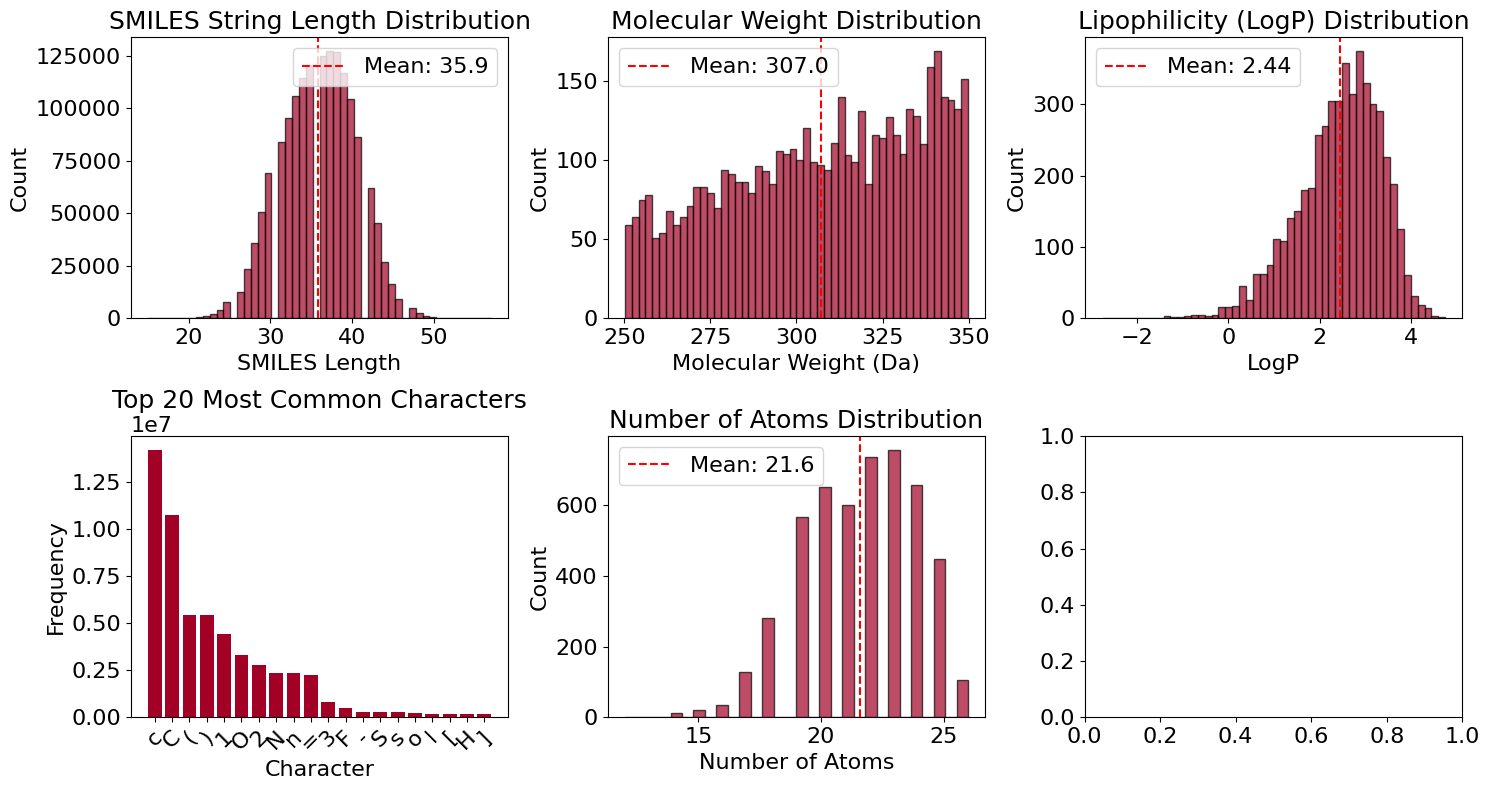

In [10]:
def analyze_dataset(filepath: str, sample_size: int = 10000) -> Dict:
    """
    Analyze a SMILES dataset to understand its characteristics.
    
    This helps us understand what our model will be learning from.
    """
    df = pd.read_csv(filepath)
    smiles_list = df['SMILES'].tolist()
    
    print(f"📊 Analyzing {filepath}")
    print(f"   Total molecules: {len(smiles_list):,}")
    
    # Sample for property calculation (full dataset takes too long)
    sample = random.sample(smiles_list, min(sample_size, len(smiles_list)))
    
    # Analyze SMILES strings
    lengths = [len(s) for s in smiles_list]
    
    # Calculate molecular properties
    properties = {'mol_weight': [], 'logp': [], 'num_atoms': []}
    valid_count = 0
    
    for smiles in tqdm(sample, desc="Calculating properties"):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            valid_count += 1
            properties['mol_weight'].append(Descriptors.MolWt(mol))
            properties['logp'].append(Descriptors.MolLogP(mol))
            properties['num_atoms'].append(mol.GetNumAtoms())
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Length distribution
    axes[0, 0].hist(lengths, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('SMILES Length')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('SMILES String Length Distribution')
    axes[0, 0].axvline(np.mean(lengths), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(lengths):.1f}')
    axes[0, 0].legend()
    
    # Molecular weight distribution
    if properties['mol_weight']:
        axes[0, 1].hist(properties['mol_weight'], bins=50, edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('Molecular Weight (Da)')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_title('Molecular Weight Distribution')
        axes[0, 1].axvline(np.mean(properties['mol_weight']), color='red', 
                           linestyle='--', label=f"Mean: {np.mean(properties['mol_weight']):.1f}")
        axes[0, 1].legend()
    
    # LogP distribution
    if properties['logp']:
        axes[0, 2].hist(properties['logp'], bins=50, edgecolor='black', alpha=0.7)
        axes[0, 2].set_xlabel('LogP')
        axes[0, 2].set_ylabel('Count')
        axes[0, 2].set_title('Lipophilicity (LogP) Distribution')
        axes[0, 2].axvline(np.mean(properties['logp']), color='red', 
                           linestyle='--', label=f"Mean: {np.mean(properties['logp']):.2f}")
        axes[0, 2].legend()
    
    # Character frequency
    all_chars = ''.join(smiles_list)
    char_counts = Counter(all_chars)
    top_chars = char_counts.most_common(20)
    
    axes[1, 0].bar(range(len(top_chars)), [c[1] for c in top_chars])
    axes[1, 0].set_xticks(range(len(top_chars)))
    axes[1, 0].set_xticklabels([c[0] for c in top_chars], rotation=45)
    axes[1, 0].set_xlabel('Character')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Top 20 Most Common Characters')
    
    # Number of atoms distribution
    if properties['num_atoms']:
        axes[1, 1].hist(properties['num_atoms'], bins=30, edgecolor='black', alpha=0.7)
        axes[1, 1].set_xlabel('Number of Atoms')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Number of Atoms Distribution')
        axes[1, 1].axvline(np.mean(properties['num_atoms']), color='red', 
                           linestyle='--', label=f"Mean: {np.mean(properties['num_atoms']):.1f}")
        axes[1, 1].legend()
    
    print(f"\n📈 Dataset Statistics:")
    print(f"   Validity rate: {valid_count/len(sample)*100:.1f}%")
    print(f"   SMILES length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f}")
    print(f"   Length range: [{min(lengths)}, {max(lengths)}]")
    
    if properties['mol_weight']:
        print(f"   Molecular weight: {np.mean(properties['mol_weight']):.1f} ± {np.std(properties['mol_weight']):.1f} Da")
        print(f"   LogP: {np.mean(properties['logp']):.2f} ± {np.std(properties['logp']):.2f}")
        print(f"   Atoms per molecule: {np.mean(properties['num_atoms']):.1f} ± {np.std(properties['num_atoms']):.1f}")
    
    plt.tight_layout()
    plt.show()
    return {
        'num_molecules': len(smiles_list),
        'smiles_list': smiles_list,
        'lengths': lengths,
        'properties': properties,
        'char_counts': char_counts
    }

train_stats = analyze_dataset('data/ch10/moses_train.csv', sample_size=5000)

### <b> <font color='#A20025'> 🏗️ Building the Basic Autoencoder

Now we'll build our first molecular autoencoder. Think of it as a compression algorithm specifically designed for molecules. This basic approach, while achieving high reconstruction accuracy, fundamentally fails at generating new molecules. Can you guess why before we reveal it?

First, we create an interface that represents the core functionality we'll implement for a basic autoencoder as well as, later in the notebook, our more advanced variational autoencoder (VAE).


In [ ]:
class AbstractMolecularAutoencoder(nn.Module, ABC):
    """
    Abstract base class for molecular autoencoders.
    
    This class defines the common interface and shared functionality
    for all molecular autoencoder variants (Basic, VAE, VAE-CYC, etc.).
    """
    
    def __init__(self):
        super().__init__()
        
    @abstractmethod
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode input sequences to latent representations."""
        pass
    
    @abstractmethod
    def decode(self, *args, **kwargs) -> torch.Tensor:
        """Decode latent representations to output sequences.
        
        Note: Different models may have different decode signatures:
        - BasicAutoencoder: decode(z)
        - VAECYC: decode(x, z)
        """
        pass
    
    @abstractmethod
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        """Forward pass through the model."""
        pass
    
    @abstractmethod
    def loss_function(self, *args, **kwargs) -> Dict[str, torch.Tensor]:
        """Compute loss for training."""
        pass
    
    @abstractmethod
    def generate_from_latent(self, z: torch.Tensor, vocab=None) -> List[str]:
        """Generate sequences from latent vectors."""
        pass
    
    def interpolate_molecules(self, x1: torch.Tensor, x2: torch.Tensor, 
                            steps: int = 10, vocab=None) -> List[List[str]]:
        """
        Interpolate between two molecules in latent space.
        
        This demonstrates the continuity of the learned latent space.
        If the space is well-structured, interpolations should produce
        valid intermediate molecules.
        
        Args:
            x1, x2: Input sequences for two molecules
            steps: Number of interpolation steps
            vocab: Vocabulary for decoding
            
        Returns:
            List of interpolated SMILES at each step
        """
        self.eval()
        with torch.no_grad():
            # Encode both molecules
            # Handle different encoder return types
            if hasattr(self, '__class__') and self.__class__.__name__ == 'VAECYC':
                # VAECYC encoder returns (mu, logvar)
                mu1, _ = self.encode(x1)
                mu2, _ = self.encode(x2)
                z1, z2 = mu1, mu2  # Use means for interpolation
            else:
                # BasicAutoencoder returns z directly
                z1 = self.encode(x1)
                z2 = self.encode(x2)
            
            # Linear interpolation in latent space
            interpolated = []
            for alpha in np.linspace(0, 1, steps):
                z_interp = (1 - alpha) * z1 + alpha * z2
                smiles = self.generate_from_latent(z_interp, vocab)
                interpolated.append(smiles)
            
            return interpolated
    
    def get_latent_representation(self, x: torch.Tensor) -> np.ndarray:
        """
        Get latent representations for analysis.
        
        Useful for visualizing the learned molecular space.
        
        Args:
            x: Input sequences
            
        Returns:
            Latent vectors as numpy array
        """
        self.eval()
        with torch.no_grad():
            if hasattr(self, '__class__') and self.__class__.__name__ == 'VAECYC':
                # For VAE models, use the mean
                mu, _ = self.encode(x)
                z = mu
            else:
                z = self.encode(x)
            return z.cpu().numpy()
    
    def analyze_reconstruction_quality(self, x: torch.Tensor, vocab=None) -> Dict:
        """
        Analyze how well the model reconstructs input sequences.
        
        Useful for debugging and understanding model performance.
        
        Args:
            x: Input sequences
            vocab: Vocabulary for decoding
            
        Returns:
            Dictionary with reconstruction analysis
        """
        self.eval()
        with torch.no_grad():
            # Get reconstruction based on model type
            if hasattr(self, '__class__') and self.__class__.__name__ == 'VAECYC':
                # VAECYC needs target sequence
                target = x[:, 1:]  # Shift by one for teacher forcing
                x_input = x[:, :-1]
                recon, mu, logvar = self.forward(x_input, target)
                z = mu
            else:
                recon, z = self.forward(x)
                target = self._pad_or_truncate(x)
            
            # Get predictions
            pred_tokens = torch.argmax(recon, dim=-1)
            
            # Calculate token-level accuracy
            if hasattr(self, '__class__') and self.__class__.__name__ == 'VAECYC':
                # For VAECYC, predictions correspond to target sequence
                correct = (pred_tokens == target).float()
                mask = target != 0  # Assuming 0 is padding
            else:
                correct = (pred_tokens == target).float()
                mask = target != 0
            
            accuracy = (correct * mask).sum() / mask.sum() if mask.sum() > 0 else torch.tensor(0.0)
            
            results = {
                'token_accuracy': accuracy.item(),
                'latent_stats': {
                    'mean': z.mean().item(),
                    'std': z.std().item(),
                    'min': z.min().item(),
                    'max': z.max().item()
                }
            }
            
            # Add SMILES if vocab provided
            if vocab is not None:
                if hasattr(self, '__class__') and self.__class__.__name__ == 'VAECYC':
                    # Reconstruct full sequences
                    original = []
                    reconstructed = []
                    for i in range(x.size(0)):
                        orig_seq = x[i].cpu().tolist()
                        original.append(vocab.decode(orig_seq))
                        
                        # Prepend SOS to predictions
                        pred_seq = [vocab.sos_idx] + pred_tokens[i].cpu().tolist()
                        reconstructed.append(vocab.decode(pred_seq[:len(orig_seq)]))
                else:
                    original = [vocab.decode(seq.cpu().tolist()) for seq in x]
                    reconstructed = [vocab.decode(seq.cpu().tolist()) for seq in pred_tokens]
                
                results['examples'] = list(zip(original, reconstructed))[:5]
            
            return results

    def _pad_or_truncate(self, x: torch.Tensor) -> torch.Tensor:
        """Ensure sequences are exactly max_length."""
        batch_size = x.size(0)
        current_length = x.size(1)
        
        if current_length > self.max_length:
            # Truncate sequences that are too long
            return x[:, :self.max_length]
        elif current_length < self.max_length:
            # Pad sequences that are too short
            padding = torch.zeros(
                batch_size, 
                self.max_length - current_length,
                dtype=torch.long, 
                device=x.device
            )
            return torch.cat([x, padding], dim=1)
        else:
            return x

We now implement the basic autoencoder.

In [ ]:
class BasicAutoencoder(AbstractMolecularAutoencoder):
    """
    Basic Autoencoder for SMILES molecular representation learning.
    
    This autoencoder demonstrates the fundamental concept of representation learning:
    compressing high-dimensional molecular data into a lower-dimensional latent space
    while preserving essential information for reconstruction.
    
    Architecture Overview:
    
    Input SMILES → Embedding → Encoder → Latent Space → Decoder → Output SMILES
         ↓             ↓           ↓            ↓           ↓            ↓
    [Tokens]    [Dense Vecs]  [Compress]   [Bottleneck]  [Expand]   [Tokens]
    
    Key Components:
    1. Embedding Layer: Converts discrete tokens to continuous vectors
    2. Encoder: Compresses embedded sequences to fixed-size latent vectors
    3. Latent Space: Low-dimensional representation capturing molecular essence
    4. Decoder: Reconstructs token sequences from latent representations
    
    Educational Notes:
    - The latent space acts as a molecular "fingerprint" 
    - Similar molecules should have similar latent representations
    - The reconstruction quality indicates how well the model captures molecular structure
    """
    
    def __init__(self, vocab_size: int, latent_dim: int = 64, max_length: int = 100,
                 embed_dim: int = 128, hidden_dims: List[int] = [512, 256]):
        """
        Initialize the BasicAutoencoder.
        
        Args:
            vocab_size: Size of vocabulary (number of unique tokens)
            latent_dim: Dimensionality of latent space (molecular fingerprint size)
            max_length: Maximum sequence length to process
            embed_dim: Dimension of token embeddings
            hidden_dims: List of hidden layer dimensions for encoder/decoder
        
        Example:
            >>> model = BasicAutoencoder(vocab_size=50, latent_dim=32)
            >>> # This creates a model that:
            >>> # - Accepts sequences with 50 possible tokens
            >>> # - Compresses them to 32-dimensional vectors
            >>> # - Can reconstruct the original sequences
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        self.hidden_dims = hidden_dims
        
        # ===== EMBEDDING LAYER =====
        # Converts discrete tokens (integers) to dense vectors
        # This is crucial because neural networks work better with continuous values
        # padding_idx=0 means the <pad> token always maps to a zero vector
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0  # <pad> token always has index 0
        )
        
        # ===== ENCODER NETWORK =====
        # Progressively compresses information from sequence to latent vector
        # Input size: embed_dim * max_length (flattened embedded sequence)
        encoder_layers = []
        input_dim = embed_dim * max_length
        
        # Build encoder layers with decreasing dimensions
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),  # Stabilizes training
                nn.Dropout(0.1)  # Prevents overfitting
            ])
            input_dim = hidden_dim
        
        # Final compression to latent space
        encoder_layers.append(nn.Linear(input_dim, latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # ===== DECODER NETWORK =====
        # Expands latent vector back to sequence space
        # Mirror architecture of encoder (but reversed)
        decoder_layers = []
        input_dim = latent_dim
        
        # Build decoder layers with increasing dimensions
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.1)
            ])
            input_dim = hidden_dim
        
        # Final expansion to vocabulary logits
        decoder_layers.extend([
            nn.Linear(input_dim, vocab_size * max_length),
            # Reshape to (batch, max_length, vocab_size)
            nn.Unflatten(1, (max_length, vocab_size))
        ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Initialize weights for better training
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using Kaiming initialization for ReLU networks."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.1)
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Encode input sequences to latent representations.
        
        This is the compression step where variable-length sequences
        are converted to fixed-size latent vectors.
        
        Args:
            x: Input tensor of token indices, shape (batch_size, sequence_length)
            
        Returns:
            z: Latent vectors, shape (batch_size, latent_dim)
            
        Process:
            1. Pad/truncate sequences to max_length
            2. Convert tokens to embeddings
            3. Flatten and compress through encoder network
        """
        batch_size = x.size(0)
        
        # Ensure all sequences have the same length for batch processing
        x = self._pad_or_truncate(x)
        
        # Step 1: Token indices → Embedding vectors
        # Shape: (batch, max_length) → (batch, max_length, embed_dim)
        embedded = self.embedding(x)
        
        # Step 2: Flatten for feedforward network
        # Shape: (batch, max_length, embed_dim) → (batch, max_length * embed_dim)
        embedded_flat = embedded.view(batch_size, -1)
        
        # Step 3: Compress through encoder
        # Shape: (batch, max_length * embed_dim) → (batch, latent_dim)
        z = self.encoder(embedded_flat)
        
        return z
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode latent representations to output logits.
        
        This is the reconstruction step where compressed latent vectors
        are expanded back to sequence predictions.
        
        Args:
            z: Latent vectors, shape (batch_size, latent_dim)
            
        Returns:
            logits: Output logits, shape (batch_size, max_length, vocab_size)
        """
        return self.decoder(z)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Complete forward pass: encode then decode.
        
        Args:
            x: Input sequences, shape (batch_size, sequence_length)
            
        Returns:
            Tuple of (reconstructed_logits, latent_vectors)
        """
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z
    
    def _pad_or_truncate(self, x: torch.Tensor) -> torch.Tensor:
        """Ensure sequences are exactly max_length."""
        batch_size = x.size(0)
        current_length = x.size(1)
        
        if current_length > self.max_length:
            # Truncate sequences that are too long
            return x[:, :self.max_length]
        elif current_length < self.max_length:
            # Pad sequences that are too short
            padding = torch.zeros(
                batch_size, 
                self.max_length - current_length,
                dtype=torch.long, 
                device=x.device
            )
            return torch.cat([x, padding], dim=1)
        else:
            return x
    
    def loss_function(self, recon: torch.Tensor, target: torch.Tensor,
                     z: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        """
        Compute reconstruction loss.
        
        For autoencoders, we only have reconstruction loss.
        VAEs will add KL divergence here.
        
        Args:
            recon: Reconstructed logits, shape (batch, max_length, vocab_size)
            target: Target sequences, shape (batch, sequence_length)
            z: Latent vectors (not used in basic autoencoder)
            
        Returns:
            Dictionary with 'loss' and 'recon_loss' keys
        """
        # Ensure target has same length as reconstruction
        target = self._pad_or_truncate(target)
        
        # Flatten for cross-entropy computation
        # Shape: (batch * max_length, vocab_size)
        recon_flat = recon.view(-1, self.vocab_size)
        # Shape: (batch * max_length,)
        target_flat = target.view(-1)
        
        # Compute cross-entropy loss, ignoring padding tokens
        recon_loss = F.cross_entropy(
            recon_flat,
            target_flat,
            ignore_index=0  # Don't compute loss on padding tokens
        )

        with torch.no_grad():
            if isinstance(recon_loss, torch.Tensor):
                perplexity = torch.exp(recon_loss).clamp(max=1000.0).item()
            else:
                perplexity = min(np.exp(recon_loss), 1000.0)
        
        return {
            'loss': recon_loss,
            'recon_loss': recon_loss,
            'perplexity': perplexity
        }
    
    def generate_from_latent(self, z: torch.Tensor, vocab=None) -> List[str]:
        """
        Generate SMILES strings from latent vectors.
        
        This demonstrates the decoder's ability to create molecules
        from compressed representations.
        
        Args:
            z: Latent vectors, shape (batch_size, latent_dim)
            vocab: Vocabulary object for decoding tokens to SMILES
            
        Returns:
            List of generated SMILES strings
        """
        self.eval()
        with torch.no_grad():
            # Decode latent vectors to logits
            logits = self.decode(z)  # (batch, max_length, vocab_size)
            
            # Greedy decoding: take the most likely token at each position
            tokens = torch.argmax(logits, dim=-1)  # (batch, max_length)
            
            # Convert tokens to SMILES strings
            generated = []
            for i in range(z.size(0)):
                if vocab is not None:
                    smiles = vocab.decode(tokens[i].cpu().tolist())
                    generated.append(smiles)
                else:
                    # Return token indices if no vocab provided
                    generated.append(tokens[i].cpu().tolist())
            
            return generated

To facilitate training and evaluation, we implement separate `Trainer` and `MoleculeEvaluator` classes in the following two cells. See the docstrings for brief summaries of each class.

In [ ]:
class Trainer:
    """
    A comprehensive trainer class for molecular autoencoders.
    
    This trainer implements best practices for deep learning training:
    - Early stopping to prevent overfitting
    - Gradient clipping for stable training
    - Regular checkpointing for fault tolerance
    - Detailed logging for experiment tracking
    - Learning rate scheduling for better convergence
    
    The trainer is designed to be model-agnostic and can be extended
    for different types of autoencoders (basic, VAE, etc.).
    """
    
    def __init__(self, 
                 model: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 device: str = 'cuda',
                 max_epochs: int = 300,
                 gradient_clip_val: float = 5.0,
                 early_stopping_patience: int = 10,
                 checkpoint_dir: str = 'checkpoints',
                 log_dir: str = 'logs',
                 save_every_n_epochs: int = 5,
                 verbose: bool = True):
        """
        Initialize the trainer.
        
        Args:
            model: The model to train
            optimizer: Optimizer for training
            device: Device to train on ('cuda' or 'cpu')
            max_epochs: Maximum number of training epochs
            gradient_clip_val: Value for gradient clipping (prevents exploding gradients)
            early_stopping_patience: Epochs to wait before early stopping
            checkpoint_dir: Directory to save model checkpoints
            log_dir: Directory to save training logs
            save_every_n_epochs: Frequency of checkpoint saves
            verbose: Whether to print training progress
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.max_epochs = max_epochs
        self.gradient_clip_val = gradient_clip_val
        self.early_stopping_patience = early_stopping_patience
        self.save_every_n_epochs = save_every_n_epochs
        self.verbose = verbose
        
        # Setup directories
        self.checkpoint_dir = Path(checkpoint_dir)
        self.log_dir = Path(log_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Setup logging
        self._setup_logging()
        
        # Training state
        self.current_epoch = 0
        self.global_step = 0
        self.best_val_loss = float('inf')
        self.epochs_without_improvement = 0
        self.training_history = {
            'train_losses': [],
            'val_losses': [],
            'train_recon_losses': [],
            'val_recon_losses': [],
            'train_perplexities': [],
            'val_perplexities': [],
            'learning_rates': [],
            'epoch_times': []
        }
        
        # Optional callbacks
        self.callbacks = []
    
    def _setup_logging(self):
        """Setup logging configuration."""
        log_file = self.log_dir / f'training_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
        
        # Create logger
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.INFO)
        
        # File handler
        fh = logging.FileHandler(log_file)
        fh.setLevel(logging.INFO)
        
        # Console handler (if verbose)
        if self.verbose:
            ch = logging.StreamHandler()
            ch.setLevel(logging.INFO)
            self.logger.addHandler(ch)
        
        # Formatter
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        fh.setFormatter(formatter)
        self.logger.addHandler(fh)
        
        self.logger.info(f"Training started. Logs saved to {log_file}")
    
    def train(self, 
              train_loader: DataLoader, 
              val_loader: DataLoader,
              num_epochs: Optional[int] = None) -> Dict:
        """
        Main training loop with early stopping and checkpointing.
        
        Args:
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            num_epochs: Number of epochs to train (uses max_epochs if None)
            
        Returns:
            Dictionary containing training history
        """
        num_epochs = num_epochs or self.max_epochs
        self.logger.info(f"Starting training for {num_epochs} epochs")
        
        # Training loop
        for epoch in range(self.current_epoch, min(self.current_epoch + num_epochs, self.max_epochs)):
            self.current_epoch = epoch
            epoch_start_time = time.time()
            
            # Train one epoch
            train_metrics = self._train_epoch(train_loader, epoch)
            
            # Validate
            val_metrics = self._validate_epoch(val_loader, epoch)
            
            # Update history
            self._update_history(train_metrics, val_metrics)
            
            # Learning rate for logging
            current_lr = self.optimizer.param_groups[0]['lr']
            self.training_history['learning_rates'].append(current_lr)
            
            # Epoch time
            epoch_time = time.time() - epoch_start_time
            self.training_history['epoch_times'].append(epoch_time)
            
            # Log epoch results
            self._log_epoch_results(epoch, train_metrics, val_metrics, current_lr, epoch_time)
            
            # Check for improvement (early stopping)
            if val_metrics['loss'] < self.best_val_loss:
                self.best_val_loss = val_metrics['loss']
                self.epochs_without_improvement = 0
                self._save_checkpoint('best_model.pt', is_best=True)
                self.logger.info(f"New best model! Val loss: {self.best_val_loss:.4f}")
            else:
                self.epochs_without_improvement += 1
            
            # Regular checkpoint
            if (epoch + 1) % self.save_every_n_epochs == 0:
                self._save_checkpoint(f'checkpoint_epoch_{epoch+1}.pt')
            
            # Early stopping check
            if self.epochs_without_improvement >= self.early_stopping_patience:
                self.logger.info(f"Early stopping triggered after {epoch + 1} epochs")
                self.logger.info(f"Best validation loss: {self.best_val_loss:.4f}")
                break
            
            # Run callbacks
            for callback in self.callbacks:
                callback(self, epoch, train_metrics, val_metrics)
        
        # Save final model
        self._save_checkpoint('final_model.pt')
        self._save_training_history()
        
        self.logger.info("Training completed!")
        return self.training_history
    
    def _train_epoch(self, train_loader: DataLoader, epoch: int) -> Dict[str, float]:
        """Train for one epoch."""
        self.model.train()
        epoch_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_perplexity = 0.0
        num_batches = len(train_loader)
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.max_epochs} [Train]', 
                    disable=not self.verbose)
        
        for batch_idx, batch in enumerate(pbar):
            # Move batch to device
            input_seq = batch['input'].to(self.device)
            target_seq = batch['target'].to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass - handle different model types
            if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
                # VAECYC requires both input and target
                recon, mu, logvar = self.model(input_seq, target_seq)
                z = None  # Not used for VAECYC loss computation
            else:
                # BasicAutoencoder takes only input
                recon, z = self.model(input_seq)
                mu, logvar = None, None
            
            # Compute loss - pass appropriate arguments based on model type
            if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
                loss_dict = self.model.loss_function(recon, target_seq, mu, logvar)
            else:
                loss_dict = self.model.loss_function(recon, target_seq, z)
            
            loss = loss_dict['loss']
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            if self.gradient_clip_val > 0:
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), 
                    self.gradient_clip_val
                )
            
            # Optimizer step
            self.optimizer.step()
            
            # Update metrics
            epoch_loss += loss.item()
            epoch_recon_loss += loss_dict['recon_loss'].item()

            if 'perplexity' in loss_dict:
                epoch_perplexity += loss_dict['perplexity'].item()

            self.global_step += 1
            
            # Update progress bar
            if batch_idx % 10 == 0:
                pbar_dict ={
                    'loss': f'{loss.item():.4f}',
                    'recon': f'{loss_dict["recon_loss"].item():.4f}'
                }
                if 'perplexity' in loss_dict:
                    pbar_dict['ppl'] = f'{loss_dict["perplexity"].item():.2f}'
                pbar.set_postfix(pbar_dict)
        
        # Average metrics
        metrics = {
            'loss': epoch_loss / num_batches,
            'recon_loss': epoch_recon_loss / num_batches
        }
        
        # Add perplexity if it was tracked
        if epoch_perplexity > 0:
            metrics['perplexity'] = epoch_perplexity / num_batches
        
        return metrics
    
    def _validate_epoch(self, val_loader: DataLoader, epoch: int) -> Dict[str, float]:
        """Validate for one epoch."""
        self.model.eval()
        epoch_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_perplexity = 0.0
        num_batches = len(val_loader)
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{self.max_epochs} [Val]', 
                       disable=not self.verbose)
            
            for batch in pbar:
                # Move batch to device
                input_seq = batch['input'].to(self.device)
                target_seq = batch['target'].to(self.device)
                
                # Forward pass - handle different model types
                if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
                    # VAECYC requires both input and target
                    recon, mu, logvar = self.model(input_seq, target_seq)
                    z = None
                else:
                    # BasicAutoencoder takes only input
                    recon, z = self.model(input_seq)
                    mu, logvar = None, None
                
                # Compute loss
                if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
                    loss_dict = self.model.loss_function(recon, target_seq, mu, logvar)
                else:
                    loss_dict = self.model.loss_function(recon, target_seq, z)
                
                # Update metrics
                epoch_loss += loss_dict['loss'].item()
                epoch_recon_loss += loss_dict['recon_loss'].item()
                epoch_perplexity += loss_dict['perplexity'].item() if 'perplexity' in loss_dict else 0.0
        
        # Average metrics
        metrics = {
            'loss': epoch_loss / num_batches,
            'recon_loss': epoch_recon_loss / num_batches,
            'perplexity': epoch_perplexity / num_batches if epoch_perplexity > 0 else None
        }
        
        return metrics
    
    def _update_history(self, train_metrics: Dict, val_metrics: Dict):
        """Update training history."""
        self.training_history['train_losses'].append(train_metrics['loss'])
        self.training_history['val_losses'].append(val_metrics['loss'])
        self.training_history['train_recon_losses'].append(train_metrics['recon_loss'])
        self.training_history['val_recon_losses'].append(val_metrics['recon_loss'])
        if 'perplexity' in train_metrics:
            self.training_history['train_perplexities'].append(train_metrics['perplexity'])
        if 'perplexity' in val_metrics:
            self.training_history['val_perplexities'].append(val_metrics['perplexity'])
    
    
    def _log_epoch_results(self, epoch: int, train_metrics: Dict, val_metrics: Dict, 
                          lr: float, epoch_time: float):
        """Log results for one epoch."""
        log_str = (
            f"Epoch {epoch+1}/{self.max_epochs} | "
            f"Train Loss: {train_metrics['loss']:.4f} | "
            f"Val Loss: {val_metrics['loss']:.4f} | "
            f"LR: {lr:.6f} | "
            f"Time: {epoch_time:.1f}s | "
            f"No Improv: {self.epochs_without_improvement}"
        )
        self.logger.info(log_str)
    
    def _save_checkpoint(self, filename: str, is_best: bool = False):
        """Save model checkpoint."""
        model_config = {}

        tokenizer_type = 'char'
        if hasattr(self.model, 'vocab') and isinstance(self.model.vocab, SmilesPEVocab):
            tokenizer_type = 'spe'

        if isinstance(self.model, BasicAutoencoder):
            model_config = {
                'model_type': 'basic',
                'tokenizer_type': tokenizer_type,
                'vocab_size': self.model.vocab_size, 
                'latent_dim': self.model.latent_dim, 'max_length': self.model.max_length,
                'embed_dim': self.model.embed_dim, 'hidden_dims': self.model.hidden_dims
            }
        else:
            model_config = {
                'model_type': 'vae-cyc',
                'tokenizer_type': tokenizer_type,
                'vocab': self.model.vocab,
                'latent_dim': self.model.latent_dim, 'embed_dim': self.model.embed_dim,
                'hidden_dim': self.model.hidden_dim, 'max_length': self.model.max_length,
                'word_dropout': self.model.word_dropout, 'cycle_ratio': self.model.cycle_ratio,
                'max_kl_weight': self.model.max_kl_weight, 'n_cycles': self.model.n_cycles,
                'encoder_bidirectional': self.model.encoder_bidirectional, 
                'decoder_num_layers': self.model.decoder_num_layers,
                'encoder_num_layers': self.model.encoder_num_layers,
                'decoder_bidirectional': self.model.decoder_bidirectional,
                'encoder_dropout': self.model.encoder_dropout,
                'decoder_dropout': self.model.decoder_dropout
            }
            

        checkpoint = {
            'epoch': self.current_epoch,
            'global_step': self.global_step,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_loss': self.best_val_loss,
            'training_history': self.training_history,
            'epochs_without_improvement': self.epochs_without_improvement,
            'model_config': model_config,
        }
        
        filepath = self.checkpoint_dir / filename
        torch.save(checkpoint, filepath)
        
        if self.verbose and not is_best:
            self.logger.info(f"Checkpoint saved: {filepath}")
    
    def load_checkpoint(self, checkpoint_path: str):
        """Load training state from checkpoint."""
        checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.current_epoch = checkpoint['epoch']
        self.global_step = checkpoint['global_step']
        self.best_val_loss = checkpoint['best_val_loss']
        self.training_history = checkpoint['training_history']
        self.epochs_without_improvement = checkpoint['epochs_without_improvement']
        
        self.logger.info(f"Checkpoint loaded from {checkpoint_path}")
        self.logger.info(f"Resuming from epoch {self.current_epoch + 1}")
    
    def _save_training_history(self):
        """Save training history to JSON."""
        history_file = self.log_dir / 'training_history.json'
        
        # Convert numpy values to Python types for JSON serialization
        json_history = {}
        for key, values in self.training_history.items():
            json_history[key] = [float(v) if isinstance(v, np.ndarray) else v for v in values]
        
        with open(history_file, 'w') as f:
            json.dump(json_history, f, indent=2)
        
        self.logger.info(f"Training history saved to {history_file}")
    
    def plot_training_curves(self, save_path: Optional[str] = None):
        """Plot training and validation curves."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        epochs = range(1, len(self.training_history['train_losses']) + 1)
        
        # Loss curves
        ax = axes[0, 0]
        ax.plot(epochs, self.training_history['train_losses'], label='Train', linewidth=2)
        ax.plot(epochs, self.training_history['val_losses'], label='Validation', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Total Loss')
        ax.set_title('Training and Validation Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Reconstruction loss curves
        ax = axes[0, 1]
        ax.plot(epochs, self.training_history['train_recon_losses'], label='Train', linewidth=2)
        ax.plot(epochs, self.training_history['val_recon_losses'], label='Validation', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Reconstruction Loss')
        ax.set_title('Reconstruction Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Perplexity curves
        ax = axes[0, 2]
        if self.training_history.get('train_perplexities'):
            ax.plot(epochs[:len(self.training_history['train_perplexities'])], 
                   self.training_history['train_perplexities'], 
                   label='Train', linewidth=2, color='purple')
        if self.training_history.get('val_perplexities'):
            ax.plot(epochs[:len(self.training_history['val_perplexities'])], 
                   self.training_history['val_perplexities'], 
                   label='Validation', linewidth=2, color='orange')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Perplexity')
        ax.set_title('Perplexity (Lower is Better)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')  # Log scale for perplexity
        
        # Learning rate
        ax = axes[1, 0]
        ax.plot(epochs, self.training_history['learning_rates'], linewidth=2, color='green')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Learning Rate')
        ax.set_title('Learning Rate Schedule')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        
        # Epoch times
        ax = axes[1, 1]
        ax.plot(epochs, self.training_history['epoch_times'], linewidth=2, color='orange')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Time (seconds)')
        ax.set_title('Training Time per Epoch')
        ax.grid(True, alpha=0.3)
        
        # KL weight for VAE (if available)
        ax = axes[1, 2]
        if hasattr(self.model, 'get_kl_weight'):
            kl_weights = []
            original_step = self.model.step_count.item()
            for epoch in epochs:
                self.model.step_count.data.fill_(epoch * len(self.training_history['train_losses']))
                kl_weights.append(self.model.get_kl_weight())
            self.model.step_count.data.fill_(original_step)
            
            ax.plot(epochs, kl_weights, linewidth=2, color='red')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('KL Weight')
            ax.set_title('KL Annealing Schedule')
        else:
            ax.text(0.5, 0.5, 'N/A\n(Not VAE)', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14, color='gray')
            ax.set_title('KL Weight (VAE Only)')
        ax.grid(True, alpha=0.3)
        
        plt.suptitle('Training Metrics', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        else:
            plt.show()
        
        return fig
    
    def add_callback(self, callback: Callable):
        """Add a callback function to be called after each epoch."""
        self.callbacks.append(callback)
    
    def get_best_model(self) -> nn.Module:
        """Load and return the best model from checkpoints."""
        best_checkpoint_path = self.checkpoint_dir / 'best_model.pt'
        if best_checkpoint_path.exists():
            checkpoint = torch.load(best_checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.logger.info(f"Best model loaded (val loss: {checkpoint['best_val_loss']:.4f})")
        return self.model


class LearningRateScheduler:
    """
    Custom learning rate scheduler for molecular autoencoders.
    
    Implements various scheduling strategies:
    - Step decay: Reduce LR at specific epochs
    - Exponential decay: Smooth exponential reduction
    - Cosine annealing: Cosine-shaped LR curve
    - Reduce on plateau: Reduce when validation loss plateaus
    """
    
    def __init__(self, optimizer: torch.optim.Optimizer, mode: str = 'step',
                 step_size: int = 50, gamma: float = 0.5, patience: int = 10):
        """
        Initialize scheduler.
        
        Args:
            optimizer: The optimizer to schedule
            mode: Scheduling mode ('step', 'exponential', 'cosine', 'plateau')
            step_size: Epochs between LR reductions (for step mode)
            gamma: Multiplicative factor for LR reduction
            patience: Epochs to wait before reducing LR (for plateau mode)
        """
        self.optimizer = optimizer
        self.mode = mode
        self.step_size = step_size
        self.gamma = gamma
        self.patience = patience
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0
        self.initial_lr = optimizer.param_groups[0]['lr']
        
    def step(self, epoch: int, val_loss: Optional[float] = None):
        """Update learning rate based on current epoch and/or validation loss."""
        if self.mode == 'step':
            if epoch > 0 and epoch % self.step_size == 0:
                self._reduce_lr()
                
        elif self.mode == 'exponential':
            new_lr = self.initial_lr * (self.gamma ** epoch)
            self._set_lr(new_lr)
            
        elif self.mode == 'cosine':
            # Cosine annealing
            new_lr = self.initial_lr * 0.5 * (1 + np.cos(np.pi * epoch / 300))
            self._set_lr(new_lr)
            
        elif self.mode == 'plateau' and val_loss is not None:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1
                
            if self.epochs_without_improvement >= self.patience:
                self._reduce_lr()
                self.epochs_without_improvement = 0
    
    def _reduce_lr(self):
        """Reduce learning rate by gamma factor."""
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= self.gamma
    
    def _set_lr(self, lr: float):
        """Set specific learning rate."""
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
class MolecularEvaluator:
    """
    Comprehensive evaluation suite for molecular autoencoders.
    
    This evaluator focuses on three key aspects:
    1. Reconstruction Quality: How well can the model reconstruct input molecules?
    2. Latent Space Quality: Is the latent space smooth and meaningful?
    3. Generation Quality: Can the model generate valid, novel molecules?
    
    The evaluator is designed to work with individual models and provide
    clear, interpretable metrics and visualizations.
    """
    
    def __init__(self, model: nn.Module, vocab, device: str = 'cuda'):
        """
        Initialize evaluator.
        
        Args:
            model: Trained autoencoder model
            vocab: Vocabulary object for encoding/decoding
            device: Device to run evaluation on
        """
        self.model = model.to(device)
        self.vocab = vocab
        self.device = device
        self.model.eval()
    
    def evaluate_reconstruction(self, test_smiles: List[str], 
                              num_samples: int = 1000,
                              verbose: bool = True) -> Dict:
        """
        Evaluate reconstruction quality on test molecules.
        
        Metrics computed:
        - Token-level accuracy
        - SMILES exact match rate
        - Tanimoto similarity (chemical similarity)
        - Valid reconstruction rate
        
        Args:
            test_smiles: List of test SMILES strings
            num_samples: Number of samples to evaluate
            verbose: Whether to show progress bar
            
        Returns:
            Dictionary with reconstruction metrics
        """
        # Sample molecules if needed
        if len(test_smiles) > num_samples:
            import random
            test_smiles = random.sample(test_smiles, num_samples)
        
        metrics = {
            'token_accuracies': [],
            'exact_matches': [],
            'tanimoto_similarities': [],
            'valid_reconstructions': [],
            'examples': []
        }
        
        self.model.eval()
        self.model.training = False
        with torch.no_grad():
            iterator = tqdm(test_smiles, desc="Evaluating reconstruction") if verbose else test_smiles
            
            for smiles in iterator:
                # Skip invalid molecules
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    continue
                
                # Encode SMILES
                try:
                    tokens = self.vocab.encode(smiles)
                    if len(tokens) > self.model.max_length:
                        continue
                    
                    # Prepare input
                    input_tensor = torch.tensor([tokens[:-1]], device=self.device)
                    target_tensor = torch.tensor([tokens[1:]], device=self.device)
                    
                    # Get reconstruction
                    if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
                        # VAECYC requires both input and target
                        recon, mu, logvar = self.model(input_tensor, target_tensor)
                        # For evaluation, we just need the reconstruction
                    else:
                        # BasicAutoencoder takes only input
                        recon, z = self.model(input_tensor)
                    pred_tokens = torch.argmax(recon, dim=-1)
                    
                    # Token-level accuracy
                    # For teacher forcing models, pred_tokens predicts target_tensor
                    # So we compare pred_tokens with target_tensor directly
                    pred_tokens_trimmed = pred_tokens[:, :target_tensor.size(1)]
                    target_trimmed = target_tensor[:, :pred_tokens.size(1)]
                    
                    # Create mask for valid positions (non-padding)
                    mask = target_trimmed != self.vocab.pad_idx
                    
                    if mask.sum() > 0:
                        correct = (pred_tokens_trimmed == target_trimmed).float()
                        token_acc = (correct * mask).sum() / mask.sum()
                        metrics['token_accuracies'].append(token_acc.item())
                    #target_padded = self.model._pad_or_truncate(target_tensor)
                    #mask = target_padded != 0
                    #correct = (pred_tokens == target_padded).float()
                    #token_acc = (correct * mask).sum() / mask.sum()
                    #metrics['token_accuracies'].append(token_acc.item())
                    
                    # Decode to SMILES
                    full_pred_sequence = torch.cat([
                        torch.tensor([[self.vocab.sos_idx]], device=self.device),
                        pred_tokens
                    ], dim=1)
                    # Ensure we don't exceed original length
                    full_pred_sequence = full_pred_sequence[:, :len(tokens)]
                    reconstructed_smiles = self.vocab.decode(full_pred_sequence[0].cpu().tolist())

                    if len(metrics['examples']) < 5:  # Print for the first 5 examples
                        print("\n--- DIAGNOSTIC CHECK ---")
                        print(f"Original SMILES:      {smiles}")

                        tokens = self.vocab.encode(smiles)
                        print(f"Encoded Tokens:       {tokens}")
                        decoded = self.vocab.decode(tokens)
                        print(f"Roundtrip: {decoded}")
                        
                        # Manually decode the raw prediction tokens correctly
                        correctly_decoded_smiles = self.vocab.decode(pred_tokens[0].cpu().tolist())
                        print(f"Correctly Decoded:    {correctly_decoded_smiles}")
                        
                        print(f"Incorrectly Decoded:  {reconstructed_smiles}")
                        print("------------------------")
                    
                    # Exact match
                    exact_match = smiles == reconstructed_smiles
                    metrics['exact_matches'].append(exact_match)
                    
                    # Chemical similarity
                    tanimoto = self._calculate_tanimoto_similarity(smiles, reconstructed_smiles)
                    metrics['tanimoto_similarities'].append(tanimoto)
                    
                    # Valid reconstruction
                    recon_mol = Chem.MolFromSmiles(reconstructed_smiles)
                    metrics['valid_reconstructions'].append(recon_mol is not None)
                    
                    # Store examples
                    if len(metrics['examples']) < 10:
                        metrics['examples'].append({
                            'original': smiles,
                            'reconstructed': reconstructed_smiles,
                            'tanimoto': tanimoto,
                            'exact_match': exact_match,
                            'token_accuracy': token_acc.item() if mask.sum() > 0 else 0.0
                        })
                        
                except Exception as e:
                    if verbose:
                        print(f"Error processing {smiles}: {str(e)}")
                    continue
        
        # Compute summary statistics
        summary = {
            'num_evaluated': len(metrics['token_accuracies']),
            'avg_token_accuracy': np.mean(metrics['token_accuracies']) if metrics['token_accuracies'] else 0,
            'exact_match_rate': np.mean(metrics['exact_matches']) if metrics['exact_matches'] else 0,
            'avg_tanimoto_similarity': np.mean(metrics['tanimoto_similarities']) if metrics['tanimoto_similarities'] else 0,
            'valid_reconstruction_rate': np.mean(metrics['valid_reconstructions']) if metrics['valid_reconstructions'] else 0,
            'examples': metrics['examples']
        }
        
        return summary

    def evaluate_continuity(self, test_smiles: List[str], 
                        noise_levels: List[float] = [0.1, 0.25, 0.5],
                        num_perturbations: int = 30,
                        max_molecules: int = 200) -> Dict[float, List[float]]:
        """
        Evaluate latent space continuity by measuring similarity preservation under noise.
        
        This method tests how "smooth" the latent space is by progressively adding
        noise to latent representations and measuring how molecular similarity degrades.
        A smooth latent space should show gradual similarity decline rather than
        sudden drops.
        
        Process:
        1. Encode molecules to latent vectors
        2. For each noise level:
        - Add cumulative Gaussian noise to latent vectors
        - Decode perturbed vectors back to molecules
        - Measure Tanimoto similarity to original molecules
        - Track similarity degradation over perturbation steps
        
        Args:
            test_smiles: List of SMILES strings to test continuity on
            noise_levels: Standard deviations of noise to test
            num_perturbations: Number of progressive noise steps
            max_molecules: Maximum number of molecules to test (for speed)
            
        Returns:
            Dictionary mapping noise levels to similarity scores over steps
            Format: {noise_level: [sim_step1, sim_step2, ...]}
            
        Example:
            >>> continuity_results = evaluator.evaluate_continuity(test_smiles)
            >>> # Results show how similarity degrades with increasing noise
            >>> # Smoother latent spaces show more gradual degradation
        """
        print(f"\n🔬 Evaluating latent space continuity...")
        print(f"   Testing {len(noise_levels)} noise levels with {num_perturbations} steps each")
        
        self.model.eval()
        results = {noise: [] for noise in noise_levels}
        
        # Sample molecules for speed
        test_molecules = test_smiles[:max_molecules] if len(test_smiles) > max_molecules else test_smiles
        
        with torch.no_grad():
            for noise_std in noise_levels:
                step_similarities = [[] for _ in range(num_perturbations)]
                
                print(f"   Testing noise level σ={noise_std:.2f}...")
                
                for smiles in tqdm(test_molecules, desc=f"Continuity σ={noise_std}", disable=False):
                    # Skip invalid molecules
                    mol = Chem.MolFromSmiles(smiles)
                    if mol is None:
                        continue
                    
                    try:
                        # Encode original SMILES
                        tokens = self.vocab.encode(smiles)
                        if len(tokens) > self.model.max_length:
                            continue
                        
                        input_tensor = torch.tensor([tokens[:-1]], device=self.device)
                        
                        # Get latent representation (handle both model types)
                        if hasattr(self.model, 'encode') and len(input_tensor.shape) == 2:
                            if hasattr(self.model, 'reparameterize'):  # VAECYC
                                mu, logvar = self.model.encode(input_tensor)
                                z0 = self.model.reparameterize(mu, logvar)
                            else:  # BasicAutoencoder
                                z0 = self.model.encode(input_tensor)
                        else:
                            continue  # Skip if encoding fails
                        
                        # Progressive perturbation
                        z_current = z0.clone()
                        
                        for step in range(num_perturbations):
                            # Add noise to current latent vector
                            noise = torch.randn_like(z_current) * noise_std
                            z_current = z_current + noise
                            
                            # Decode perturbed latent vector
                            try:
                                perturbed_smiles = self.model.generate_from_latent(
                                    z_current, 
                                    voacb=self.vocab,
                                    max_length=self.model.max_length
                                )
                                
                                if perturbed_smiles and perturbed_smiles[0]:
                                    # Calculate similarity to original
                                    similarity = self._calculate_tanimoto_similarity(
                                        smiles, perturbed_smiles[0]
                                    )
                                    step_similarities[step].append(similarity)
                                    
                            except Exception:
                                # Skip failed generations
                                continue
                                
                    except Exception:
                        # Skip molecules that cause encoding errors
                        continue
                
                # Average similarities for each step
                results[noise_std] = [
                    np.mean(sims) if sims else 0.0 
                    for sims in step_similarities
                ]
                
                print(f"     → Average similarity after {num_perturbations} steps: {results[noise_std][-1]:.3f}")
        
        print(f"✅ Continuity evaluation completed")
        return results

    def evaluate_latent_space(self, smiles_list: List[str], 
                            num_samples: int = 500) -> Dict:
        """
        Evaluate the quality of the learned latent space.
        
        Analyzes:
        - Latent space statistics
        - Smoothness via interpolation
        - Clustering of similar molecules
        
        Args:
            smiles_list: List of SMILES to analyze
            num_samples: Number of samples to use
            
        Returns:
            Dictionary with latent space metrics
        """
        if len(smiles_list) > num_samples:
            import random
            smiles_list = random.sample(smiles_list, num_samples)
        
        latent_vectors = []
        valid_smiles = []
        
        self.model.eval()
        with torch.no_grad():
            for smiles in tqdm(smiles_list, desc="Encoding molecules"):
                try:
                    mol = Chem.MolFromSmiles(smiles)
                    if mol is None:
                        continue
                    
                    tokens = self.vocab.encode(smiles)
                    if len(tokens) > self.model.max_length:
                        continue
                    
                    input_tensor = torch.tensor([tokens[:-1]], device=self.device)
                    if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
                        mu, logvar = self.model.encode(input_tensor)
                        z = mu  # Use mean for analysis
                    else:
                        z = self.model.encode(input_tensor)
                    
                    latent_vectors.append(z.cpu().numpy().squeeze())
                    valid_smiles.append(smiles)
                    
                except Exception:
                    continue
        
        if len(latent_vectors) < 10:
            return {'error': 'Too few valid molecules encoded'}
        
        latent_vectors = np.array(latent_vectors)
        
        # Compute statistics
        stats = {
            'num_molecules': len(latent_vectors),
            'latent_dim': latent_vectors.shape[1],
            'mean': np.mean(latent_vectors, axis=0).tolist(),
            'std': np.std(latent_vectors, axis=0).tolist(),
            'min': np.min(latent_vectors, axis=0).tolist(),
            'max': np.max(latent_vectors, axis=0).tolist(),
        }
        
        # Analyze smoothness via interpolation
        smoothness_scores = self._evaluate_interpolation_smoothness(valid_smiles[:20])
        stats['interpolation_smoothness'] = smoothness_scores
        
        # Store latent vectors for visualization
        stats['latent_vectors'] = latent_vectors
        stats['smiles'] = valid_smiles
        
        return stats
    
    def evaluate_latent_space_enhanced(self, smiles_list: List[str], 
                            num_samples: int = 500,
                            include_variance: bool = False) -> Dict:
        """
        Evaluate the quality of the learned latent space.
        
        Analyzes:
        - Latent space statistics
        - Smoothness via interpolation
        - Clustering of similar molecules
        - Optionally: variance/uncertainty information for VAE models
        
        Args:
            smiles_list: List of SMILES to analyze
            num_samples: Number of samples to use
            include_variance: Whether to include variance analysis for VAE models
            
        Returns:
            Dictionary with latent space metrics
        """
        if len(smiles_list) > num_samples:
            import random
            smiles_list = random.sample(smiles_list, num_samples)
        
        latent_vectors = []
        latent_variances = []  # For VAE models
        valid_smiles = []
        
        self.model.eval()
        with torch.no_grad():
            for smiles in tqdm(smiles_list, desc="Encoding molecules"):
                try:
                    mol = Chem.MolFromSmiles(smiles)
                    if mol is None:
                        continue
                    
                    tokens = self.vocab.encode(smiles)
                    if len(tokens) > self.model.max_length:
                        continue
                    
                    input_tensor = torch.tensor([tokens[:-1]], device=self.device)
                    
                    if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
                        mu, logvar = self.model.encode(input_tensor)
                        z = mu  # Use mean for primary analysis
                        
                        # Store variance information if requested
                        if include_variance:
                            var = torch.exp(logvar)
                            latent_variances.append(var.cpu().numpy().squeeze())
                    else:
                        z = self.model.encode(input_tensor)
                    
                    latent_vectors.append(z.cpu().numpy().squeeze())
                    valid_smiles.append(smiles)
                    
                except Exception:
                    continue
        
        if len(latent_vectors) < 10:
            return {'error': 'Too few valid molecules encoded'}
        
        latent_vectors = np.array(latent_vectors)
        
        # Compute statistics
        stats = {
            'num_molecules': len(latent_vectors),
            'latent_dim': latent_vectors.shape[1],
            'mean': np.mean(latent_vectors, axis=0).tolist(),
            'std': np.std(latent_vectors, axis=0).tolist(),
            'min': np.min(latent_vectors, axis=0).tolist(),
            'max': np.max(latent_vectors, axis=0).tolist(),
        }
        
        # Add variance statistics for VAE models
        if latent_variances and include_variance:
            latent_variances = np.array(latent_variances)
            stats['variance_stats'] = {
                'mean_variance': np.mean(latent_variances, axis=0).tolist(),
                'std_variance': np.std(latent_variances, axis=0).tolist(),
                'avg_uncertainty': np.mean(latent_variances),  # Average uncertainty across all dimensions
            }
        
        # Analyze smoothness via interpolation
        smoothness_scores = self._evaluate_interpolation_smoothness(valid_smiles[:20])
        stats['interpolation_smoothness'] = smoothness_scores
        
        # Store latent vectors for visualization
        stats['latent_vectors'] = latent_vectors
        stats['latent_variances'] = latent_variances if include_variance else None
        stats['smiles'] = valid_smiles
        
        return stats


    def visualize_latent_space_enhanced(self, latent_data: Dict, method: str = 'tsne', 
                                    show_variance: bool = False):
        """
        Enhanced visualization of the latent space using dimensionality reduction.
        
        For VAE models, can optionally visualize uncertainty/variance information.
        
        Args:
            latent_data: Output from evaluate_latent_space()
            method: 'pca' or 'tsne'
            show_variance: Whether to show variance information (VAE only)
        """
        if 'latent_vectors' not in latent_data:
            print("No latent vectors available for visualization")
            return
        
        latent_vectors = latent_data['latent_vectors']
        latent_variances = latent_data.get('latent_variances', None)
        
        # Dimensionality reduction
        if method == 'pca':
            reducer = PCA(n_components=2)
            embedded = reducer.fit_transform(latent_vectors)
            title = 'PCA of Latent Space'
        else:  # tsne
            reducer = TSNE(n_components=2, random_state=42)
            embedded = reducer.fit_transform(latent_vectors)
            title = 't-SNE of Latent Space'
        
        # Create figure
        if show_variance and latent_variances is not None:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Basic scatter plot
        scatter = ax1.scatter(embedded[:, 0], embedded[:, 1], alpha=0.6, s=30)
        ax1.set_xlabel('Component 1')
        ax1.set_ylabel('Component 2')
        ax1.set_title(f'{title} - Latent Means')
        ax1.grid(True, alpha=0.3)
        
        # Density plot
        ax2.hexbin(embedded[:, 0], embedded[:, 1], gridsize=30, cmap='YlOrRd')
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        ax2.set_title(f'{title} - Density')
        
        # Variance/uncertainty plot for VAE models
        if show_variance and latent_variances is not None:
            # Color points by average uncertainty
            avg_uncertainty = np.mean(latent_variances, axis=1)
            scatter = ax3.scatter(embedded[:, 0], embedded[:, 1], 
                                c=avg_uncertainty, cmap='viridis', 
                                alpha=0.6, s=30)
            ax3.set_xlabel('Component 1')
            ax3.set_ylabel('Component 2')
            ax3.set_title(f'{title} - Colored by Uncertainty')
            ax3.grid(True, alpha=0.3)
            
            # Add colorbar
            cbar = plt.colorbar(scatter, ax=ax3)
            cbar.set_label('Average Variance')
            
            # Add statistics text
            textstr = f'Avg Uncertainty: {np.mean(avg_uncertainty):.3f}\n'
            textstr += f'Std Uncertainty: {np.std(avg_uncertainty):.3f}'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            ax3.text(0.02, 0.98, textstr, transform=ax3.transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
        
        plt.suptitle(f'Latent Space Analysis{"" if not show_variance else " with Uncertainty"}', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return fig

    def evaluate_generation(self, num_samples: int = 1000) -> Dict:
        """
        Evaluate the model's ability to generate molecules.
        
        Metrics:
        - Validity rate: Percentage of chemically valid SMILES
        - Uniqueness rate: Percentage of unique molecules
        - Novelty rate: Percentage not in training set (if provided)
        - Chemical properties distribution
        
        Args:
            num_samples: Number of molecules to generate
            
        Returns:
            Dictionary with generation metrics
        """
        generated_smiles = []
        
        self.model.eval()
        with torch.no_grad():
            # Generate from random latent vectors
            for _ in tqdm(range(num_samples), desc="Generating molecules"):
                z = torch.randn(1, self.model.latent_dim, device=self.device)
                smiles_list = self.model.generate_from_latent(z, self.vocab)
                if smiles_list:
                    generated_smiles.append(smiles_list[0])
        
        # Compute metrics
        valid_molecules = []
        valid_smiles = []
        
        for smiles in generated_smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_molecules.append(mol)
                valid_smiles.append(smiles)
        
        validity_rate = len(valid_molecules) / len(generated_smiles) if generated_smiles else 0
        
        # Uniqueness
        unique_smiles = set(valid_smiles)
        uniqueness_rate = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0
        
        # Chemical properties
        properties = self._compute_molecular_properties(valid_molecules[:100])  # Sample for speed
        
        results = {
            'num_generated': len(generated_smiles),
            'validity_rate': validity_rate,
            'num_valid': len(valid_molecules),
            'uniqueness_rate': uniqueness_rate,
            'num_unique': len(unique_smiles),
            'property_statistics': properties,
            'sample_molecules': valid_smiles[:10]  # Examples
        }
        
        return results
    
    def _calculate_tanimoto_similarity(self, smiles1: str, smiles2: str) -> float:
        """Calculate Tanimoto similarity between two SMILES."""
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        if mol1 is None or mol2 is None:
            return 0.0
        
        # Generate Morgan fingerprints
        morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)
        
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    
    def _evaluate_interpolation_smoothness(self, smiles_list: List[str], 
                                         num_steps: int = 10) -> List[float]:
        """
        Evaluate smoothness of latent space via interpolation.
        
        For each pair of molecules, interpolate between them and measure
        the chemical similarity at each step.
        """
        smoothness_scores = []
        
        for i in range(len(smiles_list) - 1):
            try:
                # Encode molecules
                tokens1 = self.vocab.encode(smiles_list[i])
                tokens2 = self.vocab.encode(smiles_list[i + 1])
                
                if len(tokens1) > self.model.max_length or len(tokens2) > self.model.max_length:
                    continue
                
                input1 = torch.tensor([tokens1[:-1]], device=self.device)
                input2 = torch.tensor([tokens2[:-1]], device=self.device)
                
                # Interpolate
                interpolated = self.model.interpolate_molecules(input1, input2, num_steps, self.vocab)
                
                # Measure similarity between consecutive steps
                similarities = []
                for j in range(len(interpolated) - 1):
                    if interpolated[j] and interpolated[j+1] and len(interpolated[j]) > 0 and len(interpolated[j+1]) > 0:
                        sim = self._calculate_tanimoto_similarity(
                            interpolated[j][0], interpolated[j+1][0]
                        )
                        similarities.append(sim)
                
                if similarities:
                    smoothness_scores.append(np.mean(similarities))
                    
            except Exception:
                continue
        
        return smoothness_scores
    
    def _compute_molecular_properties(self, molecules: List) -> Dict:
        """Compute statistics of molecular properties."""
        properties = {
            'molecular_weight': [],
            'logp': [],
            'num_atoms': [],
            'num_bonds': [],
            'num_rings': []
        }
        
        for mol in molecules:
            if mol is not None:
                properties['molecular_weight'].append(Descriptors.MolWt(mol))
                properties['logp'].append(Descriptors.MolLogP(mol))
                properties['num_atoms'].append(mol.GetNumAtoms())
                properties['num_bonds'].append(mol.GetNumBonds())
                properties['num_rings'].append(len(mol.GetRingInfo().AtomRings()))
        
        # Compute statistics
        stats = {}
        for prop_name, values in properties.items():
            if values:
                stats[prop_name] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values)
                }
        
        return stats
    
    def visualize_latent_space(self, latent_data: Dict, method: str = 'tsne'):
        """
        Visualize the latent space using dimensionality reduction.
        
        Args:
            latent_data: Output from evaluate_latent_space()
            method: 'pca' or 'tsne'
        """
        if 'latent_vectors' not in latent_data:
            print("No latent vectors available for visualization")
            return
        
        latent_vectors = latent_data['latent_vectors']
        
        # Dimensionality reduction
        if method == 'pca':
            reducer = PCA(n_components=2)
            embedded = reducer.fit_transform(latent_vectors)
            title = 'PCA of Latent Space'
        else:  # tsne
            reducer = TSNE(n_components=2, random_state=42)
            embedded = reducer.fit_transform(latent_vectors)
            title = 't-SNE of Latent Space'
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Basic scatter plot
        scatter = ax1.scatter(embedded[:, 0], embedded[:, 1], alpha=0.6, s=30)
        ax1.set_xlabel('Component 1')
        ax1.set_ylabel('Component 2')
        ax1.set_title(title)
        ax1.grid(True, alpha=0.3)
        
        # Density plot
        ax2.hexbin(embedded[:, 0], embedded[:, 1], gridsize=30, cmap='YlOrRd')
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        ax2.set_title(f'{title} - Density')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def visualize_reconstructions(self, reconstruction_data: Dict, num_examples: int = 5):
        """
        Visualize reconstruction examples.
        
        Args:
            reconstruction_data: Output from evaluate_reconstruction()
            num_examples: Number of examples to show
        """
        examples = reconstruction_data['examples'][:num_examples]
        
        if not examples:
            print("No reconstruction examples available")
            return
        
        fig, axes = plt.subplots(num_examples, 2, figsize=(12, 3 * num_examples))
        if num_examples == 1:
            axes = axes.reshape(1, -1)
        
        for i, example in enumerate(examples):
            # Original molecule
            mol1 = Chem.MolFromSmiles(example['original'])
            if mol1:
                img1 = Chem.Draw.MolToImage(mol1, size=(300, 300))
                axes[i, 0].imshow(img1)
                axes[i, 0].set_title(f"Original: {example['original']}")
                axes[i, 0].axis('off')
            
            # Reconstructed molecule
            mol2 = Chem.MolFromSmiles(example['reconstructed'])
            if mol2:
                img2 = Chem.Draw.MolToImage(mol2, size=(300, 300))
                axes[i, 1].imshow(img2)
                axes[i, 1].set_title(f"Reconstructed: {example['reconstructed']}\n"
                                   f"Tanimoto: {example['tanimoto']:.3f}")
                axes[i, 1].axis('off')
            else:
                axes[i, 1].text(0.5, 0.5, 'Invalid\nReconstruction', 
                              ha='center', va='center', fontsize=16)
                axes[i, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return fig

    def plot_continuity_analysis(self, continuity_results: Dict[float, List[float]], 
                            model_name: str = "Model", save_path: Optional[str] = None):
        """
        Visualize latent space continuity analysis results.
        
        Creates a plot showing how molecular similarity degrades as cumulative
        noise is added to latent representations. Smoother latent spaces show
        more gradual degradation curves.
        
        Args:
            continuity_results: Output from evaluate_continuity()
            model_name: Name to display in plot title and legend
            save_path: Optional path to save the plot
            
        Returns:
            matplotlib figure object
            
        Example:
            >>> results = evaluator.evaluate_continuity(test_smiles)
            >>> fig = evaluator.plot_continuity_analysis(results, "VAE-CYC")
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Color palette for different noise levels
        colors = plt.cm.viridis(np.linspace(0, 1, len(continuity_results)))
        
        for (noise_std, similarities), color in zip(continuity_results.items(), colors):
            steps = range(1, len(similarities) + 1)
            
            ax.plot(steps, similarities, 
                marker='o', 
                label=f'{model_name} σ = {noise_std}',
                markersize=4, 
                alpha=0.8,
                linewidth=2,
                color=color)
        
        ax.set_xlabel('Perturbation Step', fontsize=12)
        ax.set_ylabel('Average Tanimoto Similarity', fontsize=12)
        ax.set_title(f'Latent Space Continuity Analysis - {model_name}', fontsize=14, fontweight='bold')
        ax.legend(frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.05)
        
        # Add interpretation text
        textstr = 'Smoother latent spaces show\nmore gradual similarity decline'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Continuity plot saved to: {save_path}")
        
        plt.show()
        return fig
    
    def create_evaluation_report(self, test_smiles: List[str], 
                               save_path: Optional[str] = None) -> Dict:
        """
        Create a comprehensive evaluation report.
        
        Args:
            test_smiles: Test SMILES for evaluation
            save_path: Optional path to save the report
            
        Returns:
            Dictionary with all evaluation results
        """
        print("=" * 60)
        print("MOLECULAR AUTOENCODER EVALUATION REPORT")
        print("=" * 60)
        
        # 1. Reconstruction evaluation
        print("\n1. Evaluating Reconstruction Quality...")
        recon_results = self.evaluate_reconstruction(test_smiles, num_samples=1000)
        
        print(f"   Token Accuracy: {recon_results['avg_token_accuracy']:.3f}")
        print(f"   Exact Match Rate: {recon_results['exact_match_rate']:.3f}")
        print(f"   Tanimoto Similarity: {recon_results['avg_tanimoto_similarity']:.3f}")
        print(f"   Valid Reconstruction Rate: {recon_results['valid_reconstruction_rate']:.3f}")
        
        # 2. Latent space evaluation
        print("\n2. Evaluating Latent Space Quality...")
        if hasattr(self.model, '__class__') and self.model.__class__.__name__ == 'VAECYC':
            latent_results = self.evaluate_latent_space_enhanced(test_smiles, num_samples=1000, include_variance=True)
        else:
            latent_results = self.evaluate_latent_space_enhanced(test_smiles, num_samples=1000, include_variance=False)
        
        if 'error' not in latent_results:
            print(f"   Latent Dimension: {latent_results['latent_dim']}")
            print(f"   Number of Molecules Encoded: {latent_results['num_molecules']}")
            if latent_results['interpolation_smoothness']:
                print(f"   Interpolation Smoothness: {np.mean(latent_results['interpolation_smoothness']):.3f}")
        
        # 3. Continuity evaluation (NEW)
        print("\n3. Evaluating Latent Space Continuity...")
        continuity_results = self.evaluate_continuity(
            test_smiles, 
            noise_levels=[0.1, 0.25, 0.5],
            num_perturbations=20,
            max_molecules=100
        )
        
        # Print continuity summary
        for noise_level, similarities in continuity_results.items():
            if similarities:
                final_sim = similarities[-1]
                print(f"   Noise σ={noise_level}: Final similarity {final_sim:.3f}")

        # 4. Generation evaluation
        print("\n4. Evaluating Generation Quality...")
        gen_results = self.evaluate_generation(num_samples=1000)
        
        print(f"   Validity Rate: {gen_results['validity_rate']:.3f}")
        print(f"   Uniqueness Rate: {gen_results['uniqueness_rate']:.3f}")
        print(f"   Number of Valid Molecules: {gen_results['num_valid']}")
        
        # Compile results
        report = {
            'reconstruction': recon_results,
            'latent_space': latent_results,
            'continuity': continuity_results,
            'generation': gen_results,
            'timestamp': str(np.datetime64('now'))
        }
        
        # Save report if requested
        if save_path:
            import json
            with open(save_path, 'w') as f:
                # Convert numpy arrays to lists for JSON serialization
                json_report = self._prepare_for_json(report)
                json.dump(json_report, f, indent=2)
            print(f"\nReport saved to: {save_path}")
        
        print("\n" + "=" * 60)
        print("EVALUATION COMPLETE")
        print("=" * 60)
        
        return report
    
    def _prepare_for_json(self, obj):
        """Recursively convert numpy arrays to lists for JSON serialization."""
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.integer, np.floating, np.bool_)):
            return obj.item()
        elif isinstance(obj, dict):
            return {k: self._prepare_for_json(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._prepare_for_json(v) for v in obj]
        else:
            return obj

The following are additional itility functions for molecular autoencoder training and analysis, providing help for:
- Data preprocessing and analysis
- Model inspection and debugging
- Visualization helpers
- Common molecular operations

In [ ]:
def analyze_smiles_dataset(smiles_list: List[str], name: str = "Dataset") -> Dict:
    """
    Analyze a dataset of SMILES strings.
    
    Provides statistics about:
    - Length distribution
    - Character frequencies
    - Validity rate
    - Molecular properties
    
    Args:
        smiles_list: List of SMILES strings
        name: Name of the dataset for display
        
    Returns:
        Dictionary with dataset statistics
    """
    print(f"\n{'='*60}")
    print(f"Analyzing {name}")
    print(f"{'='*60}")
    
    # Basic statistics
    lengths = [len(s) for s in smiles_list]
    
    # Validity check
    valid_count = 0
    valid_molecules = []
    invalid_examples = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1
            valid_molecules.append(mol)
        elif len(invalid_examples) < 5:
            invalid_examples.append(smiles)
    
    # Character analysis
    all_chars = Counter()
    for smiles in smiles_list:
        all_chars.update(smiles)
    
    # Molecular properties (sample for speed)
    sample_size = min(10000, len(valid_molecules))
    sample_mols = random.sample(valid_molecules, sample_size) if valid_molecules else []
    
    properties = {
        'mol_weight': [],
        'logp': [],
        'num_atoms': [],
        'num_bonds': [],
        'num_rings': []
    }
    
    for mol in sample_mols:
        properties['mol_weight'].append(Descriptors.MolWt(mol))
        properties['logp'].append(Descriptors.MolLogP(mol))
        properties['num_atoms'].append(mol.GetNumAtoms())
        properties['num_bonds'].append(mol.GetNumBonds())
        properties['num_rings'].append(len(mol.GetRingInfo().AtomRings()))
    
    # Compile results
    stats = {
        'num_molecules': len(smiles_list),
        'validity_rate': valid_count / len(smiles_list) if smiles_list else 0,
        'length_stats': {
            'mean': np.mean(lengths),
            'std': np.std(lengths),
            'min': np.min(lengths) if lengths else 0,
            'max': np.max(lengths) if lengths else 0,
            'median': np.median(lengths) if lengths else 0
        },
        'unique_chars': len(all_chars),
        'most_common_chars': all_chars.most_common(10),
        'property_stats': {
            prop: {
                'mean': np.mean(values) if values else 0,
                'std': np.std(values) if values else 0,
                'min': np.min(values) if values else 0,
                'max': np.max(values) if values else 0
            } for prop, values in properties.items()
        },
        'invalid_examples': invalid_examples
    }
    
    # Print summary
    print(f"Total molecules: {stats['num_molecules']:,}")
    print(f"Validity rate: {stats['validity_rate']:.2%}")
    print(f"Length: {stats['length_stats']['mean']:.1f} ± {stats['length_stats']['std']:.1f}")
    print(f"Length range: [{stats['length_stats']['min']}, {stats['length_stats']['max']}]")
    print(f"Unique characters: {stats['unique_chars']}")
    print(f"\nMost common characters:")
    for char, count in stats['most_common_chars'][:5]:
        print(f"  '{char}': {count:,}")
    
    if stats['property_stats']['mol_weight']['mean'] > 0:
        print(f"\nMolecular properties (sample of {sample_size}):")
        print(f"  MW: {stats['property_stats']['mol_weight']['mean']:.1f} ± "
              f"{stats['property_stats']['mol_weight']['std']:.1f}")
        print(f"  LogP: {stats['property_stats']['logp']['mean']:.2f} ± "
              f"{stats['property_stats']['logp']['std']:.2f}")
        print(f"  Atoms: {stats['property_stats']['num_atoms']['mean']:.1f} ± "
              f"{stats['property_stats']['num_atoms']['std']:.1f}")
    
    return stats

def visualize_dataset_comparison(datasets: Dict[str, List[str]]):
    """
    Create comparative visualizations of multiple SMILES datasets.
    
    Args:
        datasets: Dictionary mapping dataset names to SMILES lists
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Length distributions
    ax = axes[0, 0]
    for name, smiles_list in datasets.items():
        lengths = [len(s) for s in smiles_list]
        ax.hist(lengths, bins=50, alpha=0.6, label=name, density=True)
    ax.set_xlabel('SMILES Length')
    ax.set_ylabel('Density')
    ax.set_title('SMILES Length Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Molecular weight distributions
    ax = axes[0, 1]
    for name, smiles_list in datasets.items():
        # Sample for speed
        sample_smiles = random.sample(smiles_list, min(1000, len(smiles_list)))
        mw_values = []
        for smiles in sample_smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                mw_values.append(Descriptors.MolWt(mol))
        if mw_values:
            ax.hist(mw_values, bins=50, alpha=0.6, label=name, density=True)
    ax.set_xlabel('Molecular Weight')
    ax.set_ylabel('Density')
    ax.set_title('Molecular Weight Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Validity rates
    ax = axes[1, 0]
    validity_rates = []
    names = []
    for name, smiles_list in datasets.items():
        valid_count = sum(1 for s in smiles_list if Chem.MolFromSmiles(s) is not None)
        validity_rates.append(valid_count / len(smiles_list) * 100)
        names.append(name)
    
    bars = ax.bar(names, validity_rates)
    ax.set_ylabel('Validity Rate (%)')
    ax.set_title('Dataset Validity Rates')
    ax.set_ylim(0, 105)
    for bar, rate in zip(bars, validity_rates):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # Dataset sizes
    ax = axes[1, 1]
    sizes = [len(smiles_list) for smiles_list in datasets.values()]
    bars = ax.bar(names, sizes)
    ax.set_ylabel('Number of Molecules')
    ax.set_title('Dataset Sizes')
    ax.set_yscale('log')
    for bar, size in zip(bars, sizes):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                f'{size:,}', ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.show()

def inspect_model_architecture(model: torch.nn.Module, input_shape: Tuple[int, int]):
    """
    Print detailed model architecture with layer shapes.
    
    Args:
        model: PyTorch model to inspect
        input_shape: Expected input shape (batch_size, sequence_length)
    """
    print("\n" + "="*60)
    print("MODEL ARCHITECTURE")
    print("="*60)
    
    # Create dummy input
    dummy_input = torch.zeros(input_shape, dtype=torch.long)
    
    # Track shapes through forward pass
    def register_hook(module, input, output):
        class_name = module.__class__.__name__
        if hasattr(output, 'shape'):
            shapes_trace.append((class_name, output.shape))
    
    shapes_trace = []
    hooks = []
    
    # Register hooks
    for module in model.modules():
        if len(list(module.children())) == 0:  # Leaf modules only
            hooks.append(module.register_forward_hook(register_hook))
    
    # Forward pass
    with torch.no_grad():
        model.eval()
        _ = model(dummy_input)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Print architecture
    print(f"Input shape: {input_shape}")
    print("\nLayer trace:")
    for i, (layer_type, shape) in enumerate(shapes_trace):
        print(f"  {i+1}. {layer_type}: {tuple(shape)}")
    
    # Parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

def create_interpolation_grid(model: torch.nn.Module, smiles_list: List[str], 
                            vocab, device: str = 'cuda', grid_size: int = 5):
    """
    Create a grid of molecular interpolations.
    
    Args:
        model: Trained autoencoder
        smiles_list: List of SMILES to interpolate between
        vocab: Vocabulary object
        device: Device to run on
        grid_size: Size of interpolation grid
    """
    if len(smiles_list) < 2:
        print("Need at least 2 molecules for interpolation")
        return
    
    # Encode molecules
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for smiles in smiles_list[:grid_size]:
            tokens = vocab.encode(smiles)
            if len(tokens) > model.max_length:
                continue
            input_tensor = torch.tensor([tokens[:-1]], device=device)
            z = model.encode(input_tensor)
            latent_vectors.append(z)
    
    if len(latent_vectors) < 2:
        print("Could not encode enough molecules")
        return
    
    # Create interpolation grid
    fig, axes = plt.subplots(len(latent_vectors), len(latent_vectors), 
                           figsize=(3*len(latent_vectors), 3*len(latent_vectors)))
    
    for i in range(len(latent_vectors)):
        for j in range(len(latent_vectors)):
            ax = axes[i, j] if len(latent_vectors) > 1 else axes
            
            if i == j:
                # Diagonal: original molecule
                z = latent_vectors[i]
            else:
                # Off-diagonal: interpolation
                alpha = 0.5  # Midpoint interpolation
                z = (1 - alpha) * latent_vectors[i] + alpha * latent_vectors[j]
            
            # Generate molecule
            generated = model.generate_from_latent(z, vocab)
            if generated and generated[0]:
                mol = Chem.MolFromSmiles(generated[0])
                if mol:
                    img = Draw.MolToImage(mol, size=(200, 200))
                    ax.imshow(img)
                    ax.set_title(f"{i} → {j}" if i != j else f"Original {i}", fontsize=8)
                else:
                    ax.text(0.5, 0.5, 'Invalid', ha='center', va='center')
            else:
                ax.text(0.5, 0.5, 'Failed', ha='center', va='center')
            
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def save_model_for_deployment(model: torch.nn.Module, vocab, 
                            save_path: str, metadata: Dict = None):
    """
    Save model with all necessary components for deployment.
    
    Args:
        model: Trained model
        vocab: Vocabulary object
        save_path: Path to save the deployment package
        metadata: Optional metadata to include
    """
    import pickle
    from pathlib import Path
    
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Prepare deployment package
    deployment_package = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'vocab_size': model.vocab_size,
            'latent_dim': model.latent_dim,
            'max_length': model.max_length,
            'embed_dim': model.embed_dim,
            'hidden_dims': model.hidden_dims
        },
        'vocab': vocab,
        'metadata': metadata or {}
    }
    
    # Save as pickle
    with open(save_path, 'wb') as f:
        pickle.dump(deployment_package, f)
    
    print(f"Model saved for deployment at: {save_path}")
    
    # Also save a TorchScript version for production inference
    script_path = save_path.with_suffix('.pt')
    model.eval()
    dummy_input = torch.zeros(1, model.max_length, dtype=torch.long)
    
    try:
        traced_model = torch.jit.trace(model, dummy_input)
        torch.jit.save(traced_model, script_path)
        print(f"TorchScript model saved at: {script_path}")
    except Exception as e:
        print(f"Could not save TorchScript version: {e}")

def load_model_from_deployment(load_path: str, device: str = 'cuda'):
    """
    Load model from deployment package.
    
    Args:
        load_path: Path to deployment package
        device: Device to load model on
        
    Returns:
        Tuple of (model, vocab, metadata)
    """
    import pickle
    from pathlib import Path
    
    # Load deployment package
    with open(load_path, 'rb') as f:
        package = pickle.load(f)
    
    config = package['model_config']
    model = BasicAutoencoder(
        vocab_size=config['vocab_size'],
        latent_dim=config['latent_dim'],
        max_length=config['max_length'],
        embed_dim=config['embed_dim'],
        hidden_dims=config['hidden_dims']
    )
    
    # Load weights
    model.load_state_dict(package['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model, package['vocab'], package['metadata']

# Example molecular interpolation visualization
def visualize_molecular_journey(model: torch.nn.Module, start_smiles: str, 
                              end_smiles: str, vocab, steps: int = 10,
                              device: str = 'cuda'):
    """
    Visualize the interpolation journey between two molecules.
    
    This creates a visual story of how one molecule transforms into another
    through the latent space.
    """
    model.eval()
    
    # Encode molecules
    tokens1 = vocab.encode(start_smiles)
    tokens2 = vocab.encode(end_smiles)
    
    input1 = torch.tensor([tokens1[:-1]], device=device)
    input2 = torch.tensor([tokens2[:-1]], device=device)
    
    # Get interpolations
    interpolated = model.interpolate_molecules(input1, input2, steps, vocab)
    
    # Create visualization
    fig, axes = plt.subplots(2, (steps + 1) // 2, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, smiles_list in enumerate(interpolated):
        if smiles_list and smiles_list[0]:
            mol = Chem.MolFromSmiles(smiles_list[0])
            if mol:
                img = Draw.MolToImage(mol, size=(200, 200))
                axes[i].imshow(img)
                axes[i].set_title(f'Step {i}/{steps-1}', fontsize=10)
            else:
                axes[i].text(0.5, 0.5, 'Invalid', ha='center', va='center')
        else:
            axes[i].text(0.5, 0.5, 'Failed', ha='center', va='center')
        
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(interpolated), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Molecular Interpolation: {start_smiles} → {end_smiles}', fontsize=12)
    plt.tight_layout()
    plt.show()

The next cell demonstrates the complete training pipeline:
1. Data loading and preprocessing
2. Model initialization
3. Training with early stopping and checkpointing
4. Evaluation and visualization
5. Saving results

It defines an example config dictionary for the basic autoencoder, which we'll use to train the model shortly.

In [ ]:
class SMILESDataset(Dataset):
    """
    PyTorch Dataset for SMILES strings.
    
    This dataset handles the conversion of SMILES strings to tensor format
    suitable for training autoencoders.
    """
    
    def __init__(self, smiles_list: List[str], vocab: Vocab, max_length: int = 100):
        """
        Initialize dataset.
        
        Args:
            smiles_list: List of SMILES strings
            vocab: Vocabulary object for encoding
            max_length: Maximum sequence length
        """
        self.vocab = vocab
        self.max_length = max_length
        self.is_smilespe = isinstance(vocab, SmilesPEVocab)
        
        # Filter and encode SMILES
        self.encoded_data = []
        self.valid_smiles = []
        
        print(f"Processing {len(smiles_list)} SMILES strings...")
        print(f"Using tokenizer: {type(vocab).__name__}")
        for smiles in smiles_list:
            if len(smiles) > 0 and len(smiles) < max_length - 2:  # Account for SOS/EOS
                try:
                    encoded = vocab.encode(smiles)
                    if len(encoded) <= max_length:
                        self.encoded_data.append(encoded)
                        self.valid_smiles.append(smiles)
                except:
                    continue
        
        print(f"Dataset contains {len(self.encoded_data)} valid SMILES")

        # Calculate average sequence length
        avg_len = np.mean([len(seq) for seq in self.encoded_data])
        print(f"Average sequence length: {avg_len:.1f} tokens")
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        encoded = self.encoded_data[idx]
        
        # For autoencoder training, we use teacher forcing
        # Input: all tokens except last
        # Target: all tokens except first
        input_seq = encoded[:-1]
        target_seq = encoded[1:]
        
        # Pad sequences to max_length
        input_padded = input_seq + [self.vocab.pad_idx] * (self.max_length - len(input_seq))
        target_padded = target_seq + [self.vocab.pad_idx] * (self.max_length - len(target_seq))
        
        return {
            'input': torch.tensor(input_padded[:self.max_length], dtype=torch.long),
            'target': torch.tensor(target_padded[:self.max_length], dtype=torch.long),
            'length': len(input_seq),
            'smiles': self.valid_smiles[idx]  # Keep original SMILES for analysis
        }

def create_vocab(tokenizer_type: str, train_smiles: List[str], spe_model_path: str = None):
    """
    Create vocabulary based on tokenizer type.
    
    Args:
        tokenizer_type: 'char' for character-based, 'spe' for SmilesPE
        train_smiles: Training SMILES for character-based vocab
        spe_model_path: Path to SmilesPE model (for 'spe' type)
        
    Returns:
        Vocabulary object (Vocab or SmilesPEVocab)
    """
    if tokenizer_type.lower() == 'char':
        print("Building character-based vocabulary...")
        return Vocab(train_smiles)
    elif tokenizer_type.lower() == 'spe':
        print("Loading SmilesPE vocabulary...")
        return SmilesPEVocab(spe_model_path)
    else:
        raise ValueError(f"Unknown tokenizer type: {tokenizer_type}")

def load_data(train_path: str, test_path: str, sample_size: int = None) -> tuple:
    """
    Load training and test data from CSV files.
    
    Args:
        train_path: Path to training CSV file
        test_path: Path to test CSV file
        sample_size: Optional sample size for quick testing
        
    Returns:
        Tuple of (train_smiles, test_smiles)
    """
    print("Loading data...")
    
    # Load CSVs
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # Extract SMILES column
    train_smiles = train_df['SMILES'].dropna().tolist()
    test_smiles = test_df['SMILES'].dropna().tolist()
    
    print(f"Loaded {len(train_smiles)} training and {len(test_smiles)} test SMILES")
    
    # Sample if requested (for quick testing)
    if sample_size:
        train_smiles = random.sample(train_smiles, min(sample_size, len(train_smiles)))
        test_smiles = random.sample(test_smiles, min(sample_size // 10, len(test_smiles)))
        print(f"Sampled to {len(train_smiles)} training and {len(test_smiles)} test SMILES")
    
    return train_smiles, test_smiles

def create_data_loaders(train_smiles: List[str], test_smiles: List[str], 
                       vocab: Vocab, batch_size: int = 128, 
                       max_length: int = 100) -> tuple:
    """
    Create PyTorch DataLoaders for training.
    
    Args:
        train_smiles: Training SMILES
        test_smiles: Test SMILES
        vocab: Vocabulary object
        batch_size: Batch size for training
        max_length: Maximum sequence length
        
    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    """
    # Split test set into validation and test
    val_size = len(test_smiles) // 2
    val_smiles = test_smiles[:val_size]
    test_smiles = test_smiles[val_size:]
    
    # Create datasets
    train_dataset = SMILESDataset(train_smiles, vocab, max_length)
    val_dataset = SMILESDataset(val_smiles, vocab, max_length)
    test_dataset = SMILESDataset(test_smiles, vocab, max_length)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

def train_autoencoder(config: Dict) -> Dict:
    """
    Main training function for molecular autoencoder.
    
    Args:
        config: Configuration dictionary with training parameters
        
    Returns:
        Dictionary with training results
    """
    # Set random seeds
    set_random_seeds(config.get('seed', 42))
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    train_smiles, test_smiles = load_data(
        config['train_path'],
        config['test_path'],
        config.get('sample_size', None)
    )
    
    # Build vocabulary
    print("\nBuilding vocabulary...")
    vocab = Vocab(train_smiles + test_smiles)
    print(f"Vocabulary size: {vocab.vocab_size}")
    vocab_stats = vocab.get_vocab_stats()
    print(f"Special tokens: {vocab_stats['special_token_indices']}")
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        train_smiles, test_smiles, vocab,
        batch_size=config.get('batch_size', 128),
        max_length=config.get('max_length', 100)
    )
    
    # Initialize model
    print("\nInitializing model...")
    model = BasicAutoencoder(
        vocab_size=vocab.vocab_size,
        latent_dim=config.get('latent_dim', 64),
        max_length=config.get('max_length', 100),
        embed_dim=config.get('embed_dim', 128),
        hidden_dims=config.get('hidden_dims', [512, 256])
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.get('learning_rate', 0.0001),
        weight_decay=config.get('weight_decay', 1e-5)
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        device=device,
        max_epochs=config.get('max_epochs', 300),
        gradient_clip_val=config.get('gradient_clip_val', 5.0),
        early_stopping_patience=config.get('early_stopping_patience', 30),
        checkpoint_dir=config.get('checkpoint_dir', 'checkpoints'),
        log_dir=config.get('log_dir', 'logs'),
        save_every_n_epochs=config.get('save_every_n_epochs', 10),
        verbose=config.get('verbose', True)
    )
    
    # Add learning rate scheduler if requested
    if config.get('use_lr_scheduler', True):
        lr_scheduler = LearningRateScheduler(
            optimizer,
            mode=config.get('lr_schedule_mode', 'step'),
            step_size=config.get('lr_step_size', 50),
            gamma=config.get('lr_gamma', 0.5)
        )
        
        # Add scheduler callback
        def lr_callback(trainer, epoch, train_metrics, val_metrics):
            lr_scheduler.step(epoch, val_metrics['loss'])
        
        trainer.add_callback(lr_callback)
    
    # Train model
    print("\nStarting training...")
    print("=" * 60)
    
    training_history = trainer.train(train_loader, val_loader)
    
    print("\nTraining completed!")
    print("=" * 60)
    
    # Load best model
    best_model = trainer.get_best_model()
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    evaluator = MolecularEvaluator(best_model, vocab, device)
    
    # Get test SMILES for evaluation
    test_smiles_for_eval = [item['smiles'] for item in test_loader.dataset]
    
    # Create evaluation report
    eval_report = evaluator.create_evaluation_report(
        test_smiles_for_eval,
        save_path=Path(config.get('log_dir', 'logs')) / 'evaluation_report.json'
    )
    
    # Visualize results
    if config.get('visualize', True):
        print("\nCreating visualizations...")
        
        # Training curves
        trainer.plot_training_curves(
            save_path=Path(config.get('log_dir', 'logs')) / 'training_curves.png'
        )
        
        # Latent space visualization
        if 'latent_space' in eval_report and 'error' not in eval_report['latent_space']:
            evaluator.visualize_latent_space_enhanced(eval_report['latent_space'])
        
        # Reconstruction examples
        if 'reconstruction' in eval_report:
            evaluator.visualize_reconstructions(eval_report['reconstruction'])
    
    # Save final results
    results = {
        'config': config,
        'vocab_size': vocab.vocab_size,
        'training_history': training_history,
        'evaluation_report': evaluator._prepare_for_json(eval_report)
    }
    
    results_path = Path(config.get('log_dir', 'logs')) / 'final_results.json'
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\nResults saved to: {results_path}")
    
    return results

# Example configuration
example_config = {
    # Data paths
    'train_path': TRAIN_DATA_PATH,
    'test_path': TEST_DATA_PATH,
    
    # Model architecture
    'latent_dim': 64,
    'embed_dim': 128,
    'hidden_dims': [512, 256],
    'max_length': 150,
    
    # Training parameters
    'batch_size': 128,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'max_epochs': 50,
    'gradient_clip_val': 5.0,
    'early_stopping_patience': 30,
    
    # Learning rate scheduling
    'use_lr_scheduler': False,
    'lr_schedule_mode': 'step',  # 'step', 'exponential', 'cosine', 'plateau'
    'lr_step_size': 50,
    'lr_gamma': 0.5,
    
    # Checkpointing
    'checkpoint_dir': CHECKPOINT_DIR_BASIC,
    'log_dir': LOG_DIR_BASIC,
    'save_every_n_epochs': 5,
    
    # Other options
    'sample_size': None,  # Set to small number for quick testing
    'seed': 42,
    'verbose': True,
    'visualize': True
}

We now run a brief, example training and evaluation run for our basic autoencoder. Training a performant autoencoder would take a long time without extensive GPU compute, so the following results are illustrative of the process as a whole rather than a testament to the model's utility (which is quite low in this case). You'll see that the log contains a lot of SMILES related parsing errors, which is due to the poor autoencoder performance and its inability to reconstruct a valid SMILES string, let alone one that matches to the original, input SMILES.

Using device: cpu
Loading data...
Loaded 1584663 training and 176074 test SMILES
Sampled to 1000 training and 100 test SMILES

Building vocabulary...
Vocabulary size: 25
Special tokens: {'pad': 0, 'sos': 1, 'eos': 2, 'unk': 3}
Processing 1000 SMILES strings...
Dataset contains 1000 valid SMILES
Processing 50 SMILES strings...
Dataset contains 50 valid SMILES
Processing 50 SMILES strings...
Dataset contains 50 valid SMILES

Initializing model...
Total parameters: 12,056,934
Trainable parameters: 12,056,934


Training started. Logs saved to artifacts/ch10/logs/ch10/autoencoder/training_20250723_201639.log
Starting training for 10 epochs



Starting training...


Epoch 1/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]/home/noahrf/anaconda3/envs/ml4dd_py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
Epoch 1/10 | Train Loss: 3.1880 | Val Loss: 4.1304 | LR: 0.001000 | Time: 19.2s | No Improv: 0
New best model! Val loss: 4.1304
Checkpoint saved: artifacts/ch10/checkpoints/autoencoder/checkpoint_epoch_1.pt
Epoch 2/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
Epoch 2/10 | Train Loss: 2.6596 | Val Loss: 3.3007 | LR: 0.001000 | Time: 5.0s | No Improv: 0
New best model! Val loss: 3.3007
Checkpoint saved: artifacts/ch10/checkpoints/autoencoder/checkpoint_epoch_2.pt
Epoch 3/10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
Epoch 3/10 | Train Loss: 2.2327 | Val Loss: 2.4026 | LR: 0.001000 | Time: 3.4s | No Imp


Training completed!


Best model loaded (val loss: 1.4373)



Evaluating on test set...
MOLECULAR AUTOENCODER EVALUATION REPORT

1. Evaluating Reconstruction Quality...


Evaluating reconstruction:   0%|          | 0/50 [00:00<?, ?it/s][20:18:14] SMILES Parse Error: extra close parentheses while parsing: COc1cc(CCCC=O)N2ccccccc(O)CC1)
[20:18:14] SMILES Parse Error: check for mistakes around position 30:
[20:18:14] CC=O)N2ccccccc(O)CC1)
[20:18:14] ~~~~~~~~~~~~~~~~~~~~^
[20:18:14] SMILES Parse Error: Failed parsing SMILES 'COc1cc(CCCC=O)N2ccccccc(O)CC1)' for input: 'COc1cc(CCCC=O)N2ccccccc(O)CC1)'
[20:18:14] SMILES Parse Error: extra close parentheses while parsing: COc1cc(CCCC=O)N2ccccccc(O)CC1)
[20:18:14] SMILES Parse Error: check for mistakes around position 30:
[20:18:14] CC=O)N2ccccccc(O)CC1)
[20:18:14] ~~~~~~~~~~~~~~~~~~~~^
[20:18:14] SMILES Parse Error: Failed parsing SMILES 'COc1cc(CCCC=O)N2ccccccc(O)CC1)' for input: 'COc1cc(CCCC=O)N2ccccccc(O)CC1)'
Evaluating reconstruction:   2%|▏         | 1/50 [00:00<00:21,  2.31it/s][20:18:14] SMILES Parse Error: syntax error while parsing: Cc1ccc(C((O)(=O)NCCC=C)cnccccc3)c21
[20:18:14] SMILES Parse Error: ch

   Token Accuracy: 0.606
   Exact Match Rate: 0.000
   Tanimoto Similarity: 0.000
   Valid Reconstruction Rate: 0.000

2. Evaluating Latent Space Quality...


Encoding molecules: 100%|██████████| 50/50 [00:00<00:00, 173.64it/s]
[20:18:15] SMILES Parse Error: extra close parentheses while parsing: COc1cc(CCCC=O)N2ccccccc(O)CC1)
[20:18:15] SMILES Parse Error: check for mistakes around position 30:
[20:18:15] CC=O)N2ccccccc(O)CC1)
[20:18:15] ~~~~~~~~~~~~~~~~~~~~^
[20:18:15] SMILES Parse Error: Failed parsing SMILES 'COc1cc(CCCC=O)N2ccccccc(O)CC1)' for input: 'COc1cc(CCCC=O)N2ccccccc(O)CC1)'
[20:18:15] SMILES Parse Error: extra close parentheses while parsing: COc1cc(CCCC=O)N2ccc2ccc2O)C=1)
[20:18:15] SMILES Parse Error: check for mistakes around position 26:
[20:18:15] c(CCCC=O)N2ccc2ccc2O)C=1)
[20:18:15] ~~~~~~~~~~~~~~~~~~~~^
[20:18:15] SMILES Parse Error: Failed parsing SMILES 'COc1cc(CCCC=O)N2ccc2ccc2O)C=1)' for input: 'COc1cc(CCCC=O)N2ccc2ccc2O)C=1)'
[20:18:15] SMILES Parse Error: extra close parentheses while parsing: COc1cc(CCCC=O)N2ccc2ccc2O)C=1)
[20:18:15] SMILES Parse Error: check for mistakes around position 26:
[20:18:15] c(CCCC=O)N2

   Latent Dimension: 64
   Number of Molecules Encoded: 50
   Interpolation Smoothness: 0.000

3. Evaluating Generation Quality...


Generating molecules: 100%|██████████| 1000/1000 [00:01<00:00, 614.27it/s]
[20:18:18] SMILES Parse Error: extra open parentheses while parsing: CC1cC(=C(C(CC)(n1Cnc(c(cccO))n)11)1
[20:18:18] SMILES Parse Error: check for mistakes around position 6:
[20:18:18] CC1cC(=C(C(CC)(n1Cnc(c(cccO))n)11)1
[20:18:18] ~~~~~^
[20:18:18] SMILES Parse Error: Failed parsing SMILES 'CC1cC(=C(C(CC)(n1Cnc(c(cccO))n)11)1' for input: 'CC1cC(=C(C(CC)(n1Cnc(c(cccO))n)11)1'
[20:18:18] SMILES Parse Error: syntax error while parsing: CC1cn(O)(C(CC)(n1cnc(c(CCc())))11
[20:18:18] SMILES Parse Error: check for mistakes around position 28:
[20:18:18] )(C(CC)(n1cnc(c(CCc())))11
[20:18:18] ~~~~~~~~~~~~~~~~~~~~^
[20:18:18] SMILES Parse Error: Failed parsing SMILES 'CC1cn(O)(C(CC)(n1cnc(c(CCc())))11' for input: 'CC1cn(O)(C(CC)(n1cnc(c(CCc())))11'
[20:18:18] SMILES Parse Error: extra close parentheses while parsing: CC1cn(=C)C(CC)Nn)cn22cC(()O)c)c11
[20:18:18] SMILES Parse Error: check for mistakes around position 17:
[2

   Validity Rate: 0.000
   Uniqueness Rate: 0.000
   Number of Valid Molecules: 0

Report saved to: artifacts/ch10/logs/ch10/autoencoder/evaluation_report.json

EVALUATION COMPLETE

Creating visualizations...


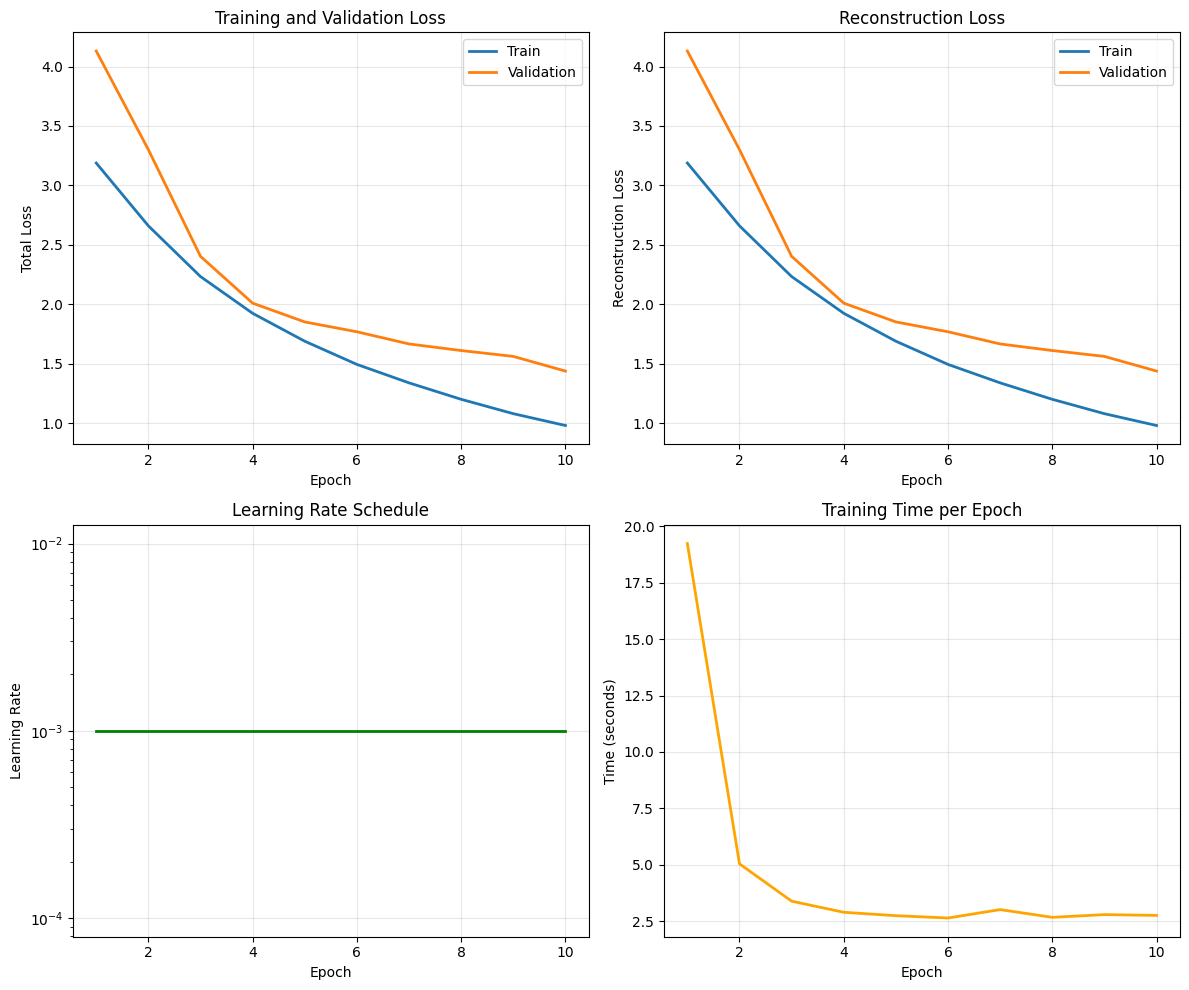

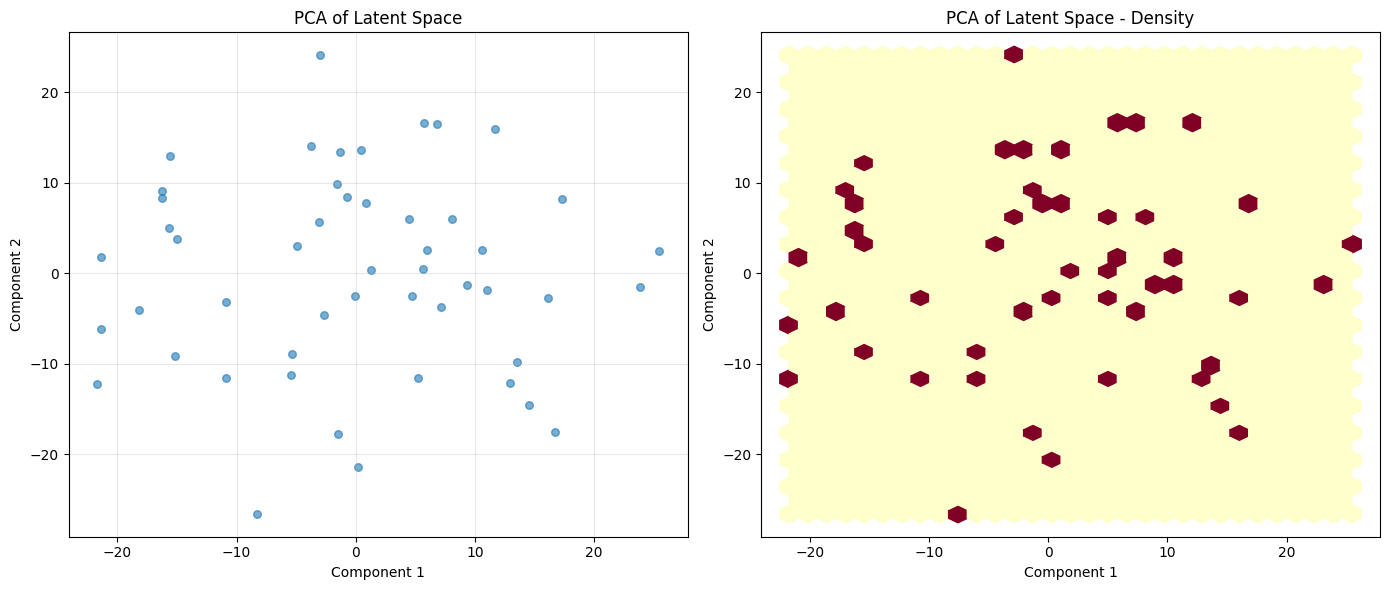

[20:18:24] SMILES Parse Error: extra close parentheses while parsing: COc1cc(CCCC=O)N2ccccccc(O)CC1)
[20:18:24] SMILES Parse Error: check for mistakes around position 30:
[20:18:24] CC=O)N2ccccccc(O)CC1)
[20:18:24] ~~~~~~~~~~~~~~~~~~~~^
[20:18:24] SMILES Parse Error: Failed parsing SMILES 'COc1cc(CCCC=O)N2ccccccc(O)CC1)' for input: 'COc1cc(CCCC=O)N2ccccccc(O)CC1)'
[20:18:24] SMILES Parse Error: syntax error while parsing: Cc1ccc(C((O)(=O)NCCC=C)cnccccc3)c21
[20:18:24] SMILES Parse Error: check for mistakes around position 10:
[20:18:24] Cc1ccc(C((O)(=O)NCCC=C)cnccccc3)c21
[20:18:24] ~~~~~~~~~^
[20:18:24] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(C((O)(=O)NCCC=C)cnccccc3)c21' for input: 'Cc1ccc(C((O)(=O)NCCC=C)cnccccc3)c21'
[20:18:24] SMILES Parse Error: extra open parentheses while parsing: O=C(NCC(C)COCNC(=O)11cccc1c11
[20:18:24] SMILES Parse Error: check for mistakes around position 4:
[20:18:24] O=C(NCC(C)COCNC(=O)11cccc1c11
[20:18:24] ~~~^
[20:18:24] SMILES Parse Error: Fai

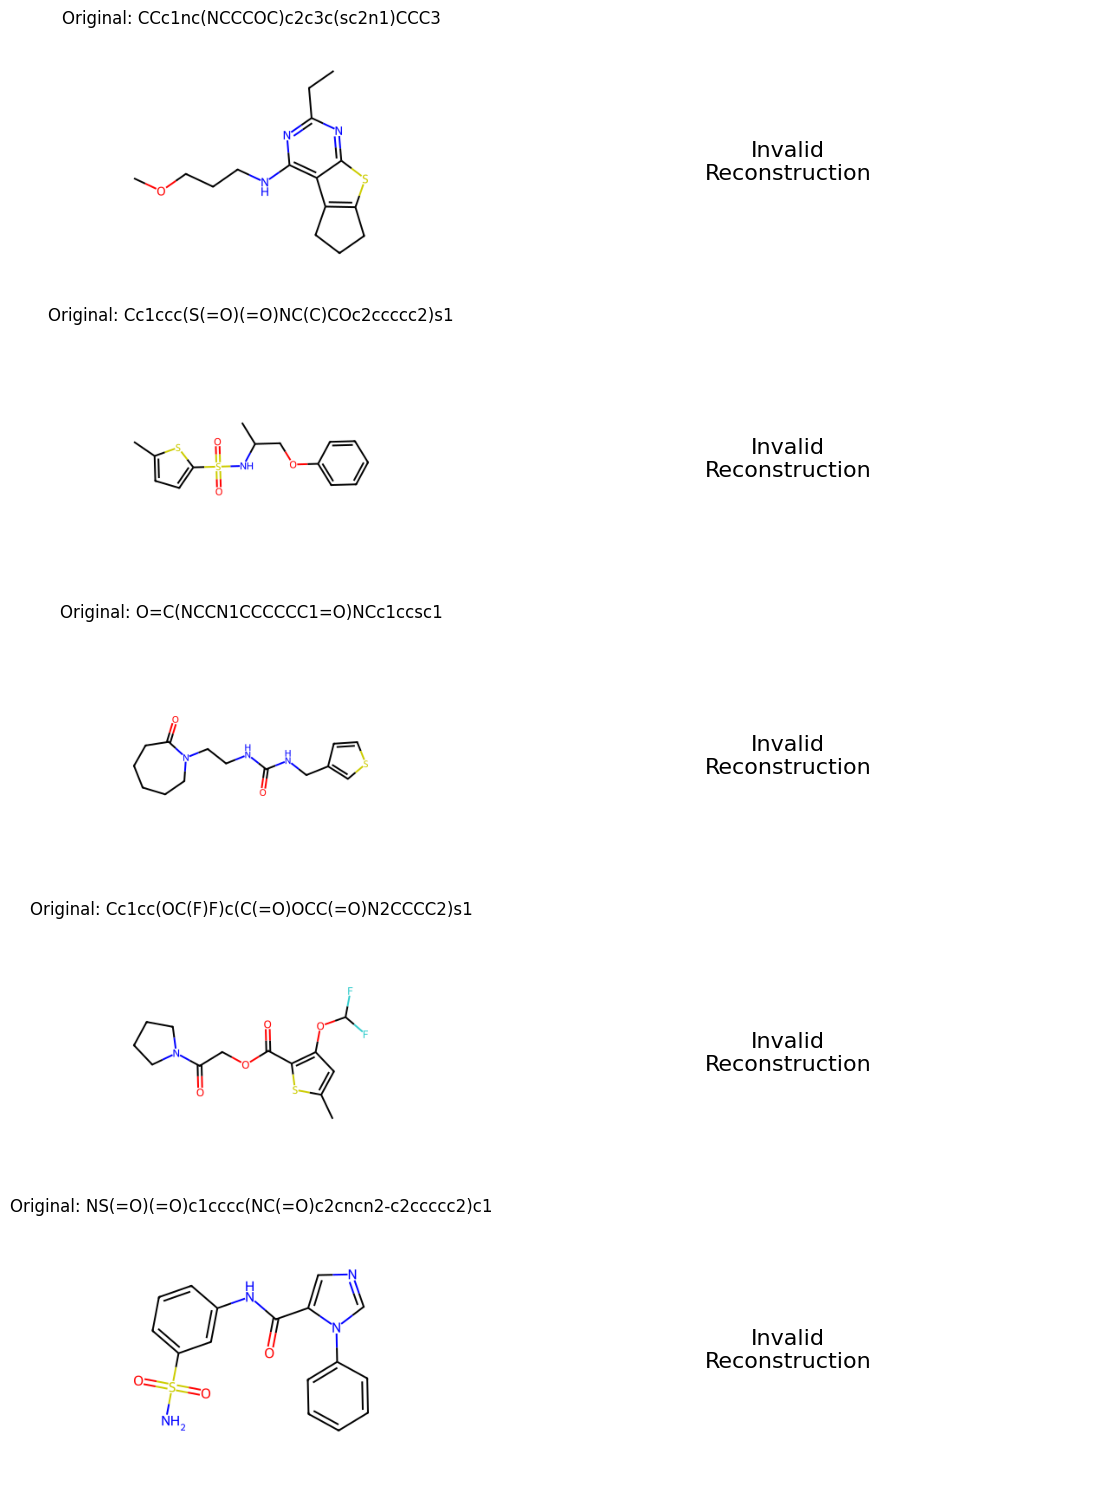


Results saved to: artifacts/ch10/logs/ch10/autoencoder/final_results.json

TRAINING SUMMARY
Final validation loss: 1.4373
Best validation loss: 1.4373
Total epochs trained: 10

Reconstruction accuracy: 0.606
Tanimoto similarity: 0.000
Generation validity: 0.000


In [ ]:
# Example: Quick test with small sample
test_config = example_config.copy()
test_config['sample_size'] = 1000  # Use only 1000 molecules for quick test
test_config['max_epochs'] = 10     # Train for only 10 epochs
test_config['save_every_n_epochs'] = 1  # Save every epoch for quick debugging

# Run training
results = train_autoencoder(test_config)

# Print summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Final validation loss: {results['training_history']['val_losses'][-1]:.4f}")
print(f"Best validation loss: {min(results['training_history']['val_losses']):.4f}")
print(f"Total epochs trained: {len(results['training_history']['train_losses'])}")

eval_report = results['evaluation_report']
print(f"\nReconstruction accuracy: {eval_report['reconstruction']['avg_token_accuracy']:.3f}")
print(f"Tanimoto similarity: {eval_report['reconstruction']['avg_tanimoto_similarity']:.3f}")
print(f"Generation validity: {eval_report['generation']['validity_rate']:.3f}")

The following cell loads a better, basic autoencoder checkpoint and uses it to generate another evaluation report, generating more informative examples of detailed reports on reconstruction quality, latent space analysis, and generation capabilities.

🔬 MOLECULAR AUTOENCODER EVALUATION
Loading best checkpoint and running comprehensive evaluation...
Using device: cpu
Loading checkpoint: artifacts/ch10/checkpoints/autoencoder/best_model.pt
✅ Checkpoint loaded successfully
   - Epoch: 18
   - Best validation loss: 0.0254
   - Global step: 235239

Loading test data: data/ch10/moses_test.csv
✅ Loaded 176074 test SMILES

Rebuilding vocabulary from test data...
✅ Vocabulary rebuilt: 28 tokens

Reconstructing model architecture...
⚠️  Using default model configuration
✅ Model loaded and ready for evaluation
   - Total parameters: 12,288,168
   - Latent dimension: 64
   - Max sequence length: 150

🔬 Initializing molecular evaluator...
✅ Evaluator ready

🚀 Starting comprehensive evaluation...
MOLECULAR AUTOENCODER EVALUATION REPORT

1. Evaluating Reconstruction Quality...


Evaluating reconstruction:   0%|          | 4/1000 [00:00<01:05, 15.12it/s][22:54:38] SMILES Parse Error: extra open parentheses while parsing: CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1
[22:54:38] SMILES Parse Error: check for mistakes around position 4:
[22:54:38] CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2
[22:54:38] ~~~^
[22:54:39] SMILES Parse Error: Failed parsing SMILES 'CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1' for input: 'CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1'
[22:54:39] SMILES Parse Error: extra open parentheses while parsing: CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1
[22:54:39] SMILES Parse Error: check for mistakes around position 4:
[22:54:39] CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2
[22:54:39] ~~~^
[22:54:39] SMILES Parse Error: Failed parsing SMILES 'CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1' for input: 'CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1'
Evaluating reconstruction:   2%|▏         | 15/1000 [00:00<00:47, 20.77it/s][22:54:39] SMILES Parse Error

   Token Accuracy: 0.994
   Exact Match Rate: 0.847
   Tanimoto Similarity: 0.870
   Valid Reconstruction Rate: 0.882

2. Evaluating Latent Space Quality...


Encoding molecules: 100%|██████████| 1000/1000 [00:27<00:00, 35.91it/s]
[22:55:58] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(C(=O)N1OCC(C2ncc3ccccc3c2)C=O)C1'
[22:55:58] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(C(=O)N1OCC(C2ncc3ccccc3c2)C=O)C1'
[22:55:58] SMILES Parse Error: extra open parentheses while parsing: CN1cccc(C(=O)N(OCC(C22cc3ccccc)c1)C=O
[22:55:58] SMILES Parse Error: check for mistakes around position 8:
[22:55:58] CN1cccc(C(=O)N(OCC(C22cc3ccccc)c1)C=O
[22:55:58] ~~~~~~~^
[22:55:58] SMILES Parse Error: Failed parsing SMILES 'CN1cccc(C(=O)N(OCC(C22cc3ccccc)c1)C=O' for input: 'CN1cccc(C(=O)N(OCC(C22cc3ccccc)c1)C=O'
[22:55:58] SMILES Parse Error: extra open parentheses while parsing: CN1cccc(C(=O)N(OCC(C22cc3ccccc)c1)C=O
[22:55:58] SMILES Parse Error: check for mistakes around position 8:
[22:55:58] CN1cccc(C(=O)N(OCC(C22cc3ccccc)c1)C=O
[22:55:58] ~~~~~~~^
[22:55:58] SMILES Parse Error: Failed parsing SMILES 'CN1cccc(C(=O)N(OCC(C22cc3ccccc)c1)C=O' for

   Latent Dimension: 64
   Number of Molecules Encoded: 1000
   Interpolation Smoothness: 0.360

3. Evaluating Generation Quality...


Generating molecules: 100%|██████████| 1000/1000 [00:08<00:00, 124.85it/s]
[22:56:09] SMILES Parse Error: syntax error while parsing: Oc1cccc(cc2c(C((CFc(F)sFF)c1NF)c1Cn11(=O
[22:56:09] SMILES Parse Error: check for mistakes around position 16:
[22:56:09] Oc1cccc(cc2c(C((CFc(F)sFF)c1NF)c1Cn11(=O
[22:56:09] ~~~~~~~~~~~~~~~^
[22:56:09] SMILES Parse Error: Failed parsing SMILES 'Oc1cccc(cc2c(C((CFc(F)sFF)c1NF)c1Cn11(=O' for input: 'Oc1cccc(cc2c(C((CFc(F)sFF)c1NF)c1Cn11(=O'
[22:56:09] SMILES Parse Error: extra open parentheses while parsing: OC1ccNn[nH]nn(C(N3(CcBrcFcFFF)F2N1sNOCN11(=O
[22:56:09] SMILES Parse Error: check for mistakes around position 14:
[22:56:09] OC1ccNn[nH]nn(C(N3(CcBrcFcFFF)F2N1sNOCN11
[22:56:09] ~~~~~~~~~~~~~^
[22:56:09] SMILES Parse Error: extra open parentheses while parsing: OC1ccNn[nH]nn(C(N3(CcBrcFcFFF)F2N1sNOCN11(=O
[22:56:09] SMILES Parse Error: check for mistakes around position 16:
[22:56:09] OC1ccNn[nH]nn(C(N3(CcBrcFcFFF)F2N1sNOCN11
[22:56:09] ~~~~~~~~~~~~~~

   Validity Rate: 0.000
   Uniqueness Rate: 0.000
   Number of Valid Molecules: 0

Report saved to: artifacts/ch10/evaluation_results/evaluation_report_20250723_225438.json

EVALUATION COMPLETE

💾 Detailed results saved to: artifacts/ch10/evaluation_results/detailed_evaluation_20250723_225438.json

📈 Generating visualizations...
   - Creating latent space visualization...


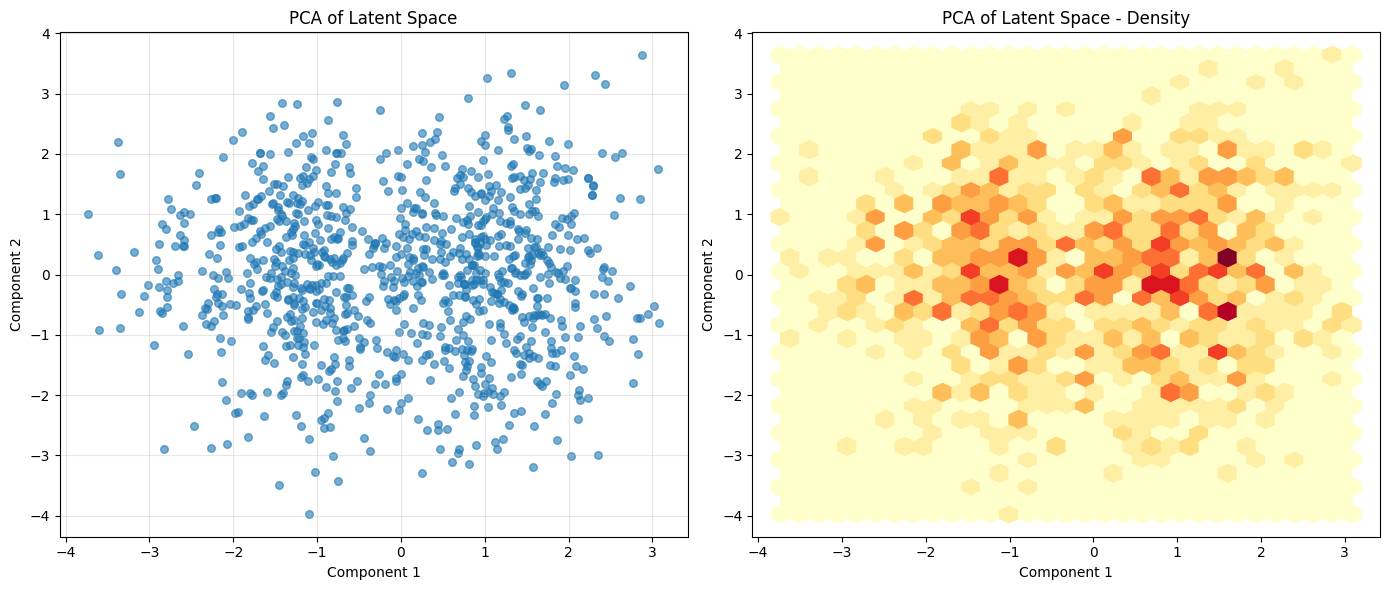

     ✅ Saved latent space plot
   - Creating reconstruction examples...


[22:56:15] SMILES Parse Error: extra open parentheses while parsing: CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1
[22:56:15] SMILES Parse Error: check for mistakes around position 4:
[22:56:15] CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2
[22:56:15] ~~~^
[22:56:15] SMILES Parse Error: Failed parsing SMILES 'CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1' for input: 'CCC(CCNC(=O)N(C)CCc1noc(-c2cc3ccccc3[nH]2)n1'


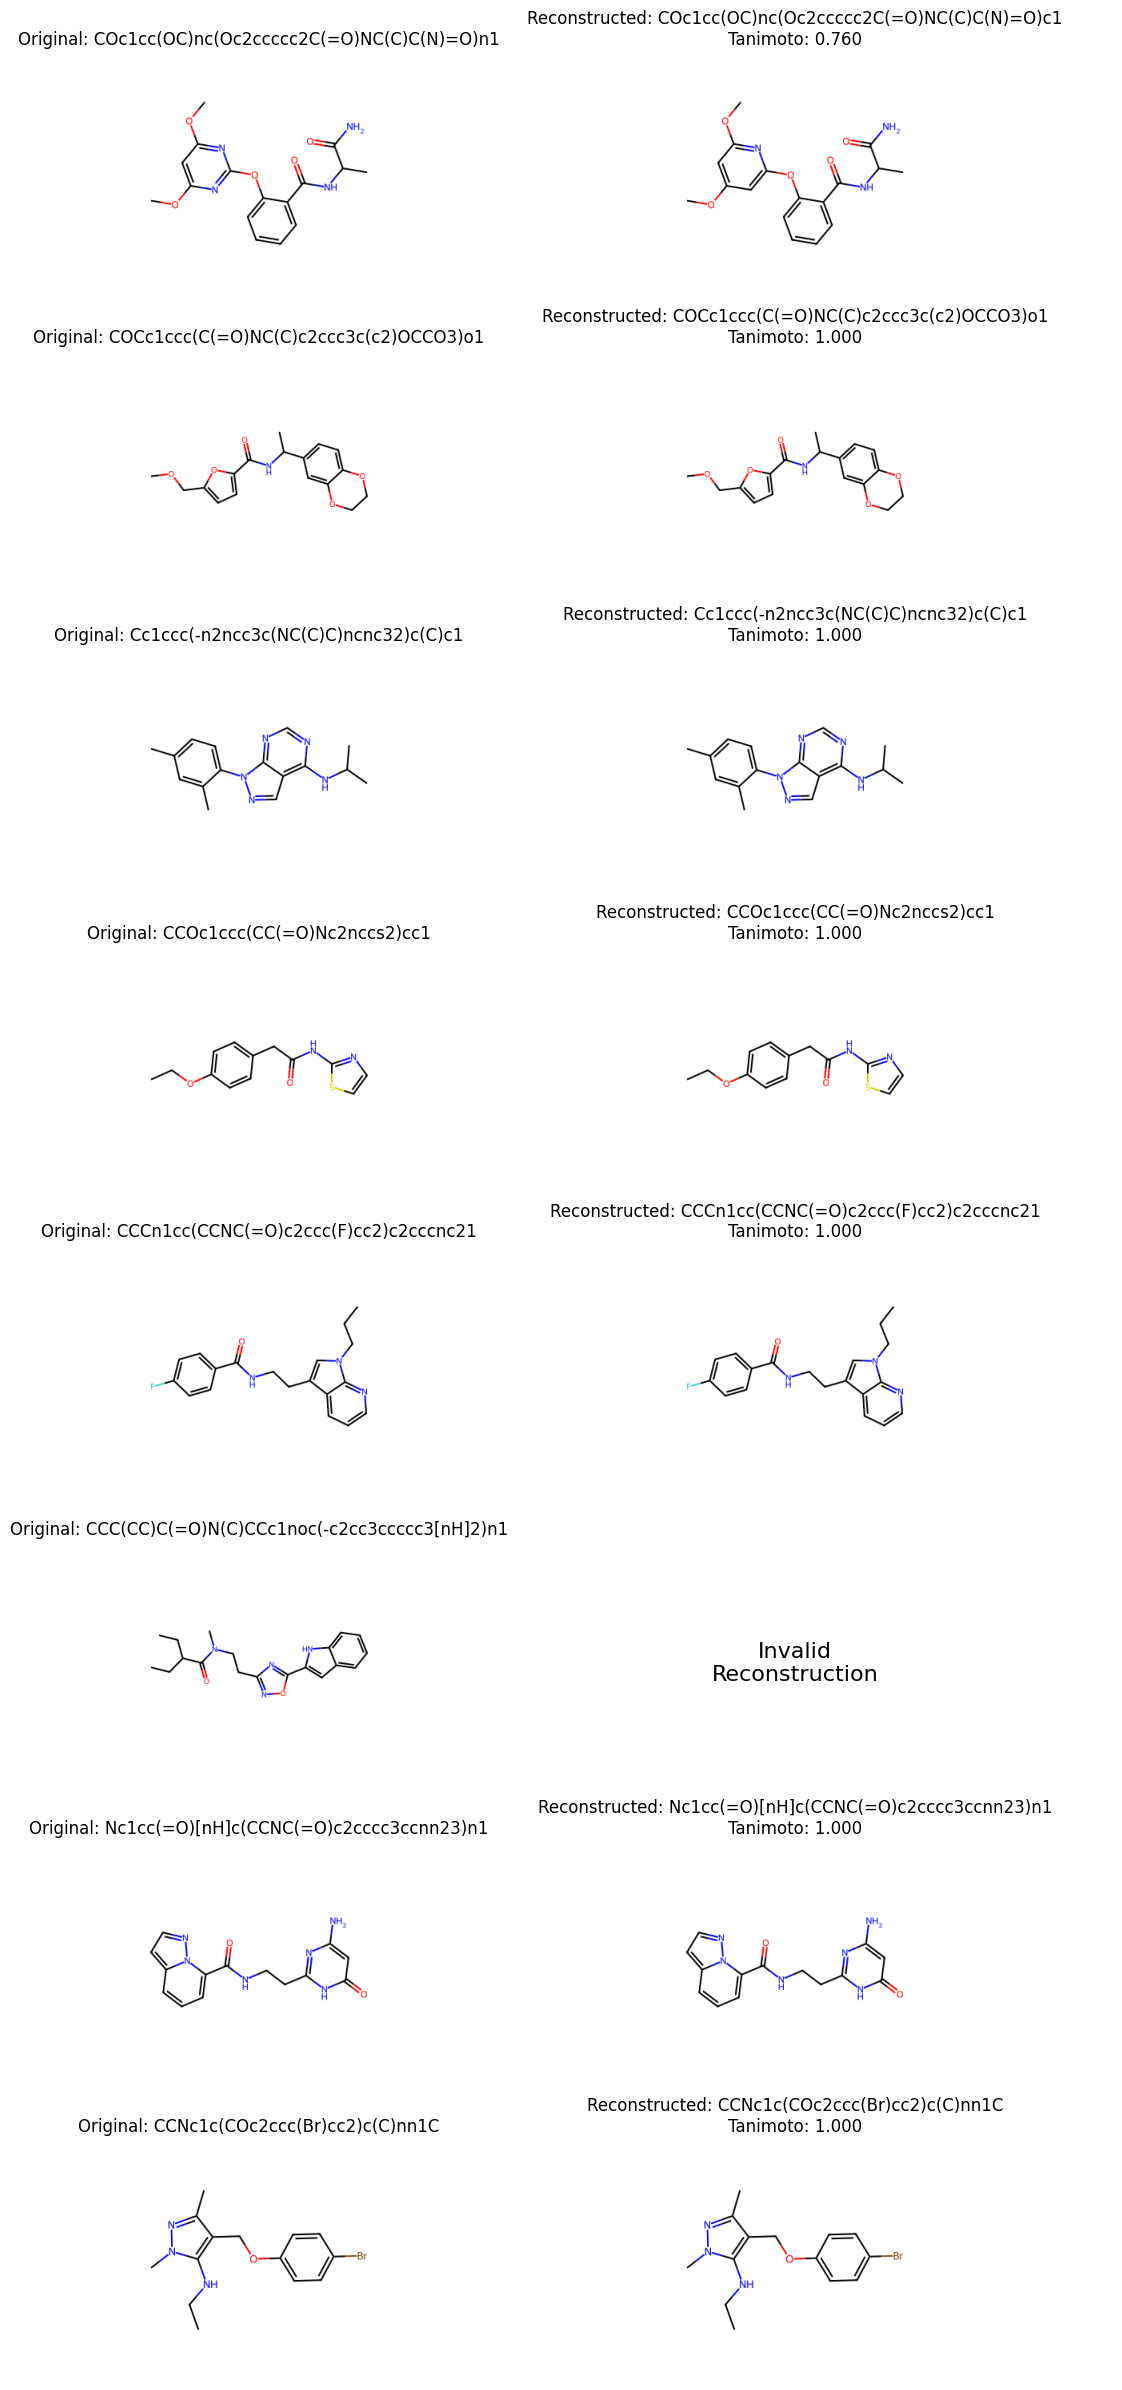

     ✅ Saved reconstruction examples

🏆 EVALUATION SUMMARY
📝 Reconstruction Quality:
   • Token Accuracy: 0.994
   • Exact Match Rate: 0.847
   • Tanimoto Similarity: 0.870
   • Valid Reconstruction Rate: 0.882

🧬 Generation Quality:
   • Validity Rate: 0.000
   • Uniqueness Rate: 0.000
   • Valid Molecules Generated: 0
   • Unique Molecules Generated: 0

🌌 Latent Space Analysis:
   • Molecules Encoded: 1,000
   • Latent Dimensions: 64
   • Interpolation Smoothness: 0.360

📁 All results saved to: artifacts/ch10/evaluation_results

✅ Evaluation completed successfully!
📊 Results timestamp: 20250723_225438


In [ ]:
def load_best_checkpoint_and_evaluate():
    """
    Load the best model checkpoint and run comprehensive evaluation.
    
    Returns:
        Dictionary containing all evaluation results
    """

    # Configuration - adjust these paths as needed
    CHECKPOINT_DIR = Path('artifacts/ch10/checkpoints/autoencoder')
    TRAIN_DATA_PATH = 'data/ch10/moses_train.csv'
    TEST_DATA_PATH = 'data/ch10/moses_test.csv'
    RESULTS_DIR = Path('artifacts/ch10/evaluation_results')

    # Create results directory
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Find best checkpoint
    best_checkpoint_path = CHECKPOINT_DIR / 'best_model.pt'

    if not best_checkpoint_path.exists():
        print(f"Best checkpoint not found at {best_checkpoint_path}")
        return None

    print(f"Loading checkpoint: {best_checkpoint_path}")

    checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    print(f"✅ Checkpoint loaded successfully")
    print(f"   - Epoch: {checkpoint.get('epoch', 'Unknown')}")
    print(f"   - Best validation loss: {checkpoint.get('best_val_loss', 'Unknown'):.4f}")
    print(f"   - Global step: {checkpoint.get('global_step', 'Unknown')}")

    print(f"\nLoading train data: {TRAIN_DATA_PATH}")
    train_df = pd.read_csv(TRAIN_DATA_PATH)
    train_smiles = train_df['SMILES'].dropna().tolist()
    print(f"✅ Loaded {len(train_smiles)} train SMILES")

    print(f"\nLoading test data: {TEST_DATA_PATH}")
    test_df = pd.read_csv(TEST_DATA_PATH)
    test_smiles = test_df['SMILES'].dropna().tolist()
    print(f"✅ Loaded {len(test_smiles)} test SMILES")

    # Reconstruct vocabulary from training history
    # In practice, you should save the vocab with the checkpoint
    print(f"\nRebuilding vocabulary from test data...")

    # For this example, we'll build vocab from test data
    # In production, save vocab with checkpoint
    vocab = Vocab(train_smiles)
    print(f"✅ Vocabulary rebuilt: {vocab.vocab_size} tokens")

    # Reconstruct model architecture
    print(f"\nReconstructing model architecture...")

    # Extract model config from checkpoint or use defaults
    model_config = {
        'vocab_size': vocab.vocab_size,
        'latent_dim': 64,  # Default - should be saved with checkpoint
        'max_length': 150,
        'embed_dim': 128,
        'hidden_dims': [512, 256]
    }

    # Override with saved config if available
    if 'model_config' in checkpoint:
        model_config.update(checkpoint['model_config'])
        print("✅ Used saved model configuration")
    else:
        print("⚠️  Using default model configuration")

    model = BasicAutoencoder(**model_config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"✅ Model loaded and ready for evaluation")

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   - Total parameters: {total_params:,}")
    print(f"   - Latent dimension: {model.latent_dim}")
    print(f"   - Max sequence length: {model.max_length}")

    # Initialize evaluator
    print(f"\n🔬 Initializing molecular evaluator...")
    evaluator = MolecularEvaluator(model, vocab, device)
    print("✅ Evaluator ready")

    # Run comprehensive evaluation
    print(f"\n🚀 Starting comprehensive evaluation...")
    print("=" * 80)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    eval_report = evaluator.create_evaluation_report(
        test_smiles,
        save_path=RESULTS_DIR / f'evaluation_report_{timestamp}.json'
    )

    # Save additional detailed results
    detailed_results = {
        'timestamp': timestamp,
        'checkpoint_info': {
            'path': str(best_checkpoint_path),
            'epoch': checkpoint.get('epoch', None),
            'best_val_loss': checkpoint.get('best_val_loss', None),
            'global_step': checkpoint.get('global_step', None)
        },
        'model_config': model_config,
        'test_data_info': {
            'path': TEST_DATA_PATH,
            'num_molecules': len(test_smiles)
        },
        'evaluation_results': eval_report
    }

    # Save detailed results
    detailed_path = RESULTS_DIR / f'detailed_evaluation_{timestamp}.json'
    with open(detailed_path, 'w') as f:
        json.dump(detailed_results, f, indent=2, default=str)

    print(f"\n💾 Detailed results saved to: {detailed_path}")

    # Generate visualizations
    print(f"\n📈 Generating visualizations...")

    # Latent space visualization
    if 'latent_space' in eval_report and 'error' not in eval_report['latent_space']:
        print("   - Creating latent space visualization...")
        fig = evaluator.visualize_latent_space(eval_report['latent_space'])
        if fig:
            fig.savefig(RESULTS_DIR / f'latent_space_{timestamp}.png',
                        dpi=300, bbox_inches='tight')
            print(f"     ✅ Saved latent space plot")

    # Reconstruction examples
    if 'reconstruction' in eval_report:
        print("   - Creating reconstruction examples...")
        fig = evaluator.visualize_reconstructions(eval_report['reconstruction'], num_examples=8)
        if hasattr(fig, 'savefig'):
            fig.savefig(RESULTS_DIR / f'reconstructions_{timestamp}.png',
                        dpi=300, bbox_inches='tight')
            print(f"     ✅ Saved reconstruction examples")

    # Print summary to console
    print(f"\n" + "=" * 80)
    print("🏆 EVALUATION SUMMARY")
    print("=" * 80)

    # Reconstruction metrics
    recon = eval_report.get('reconstruction', {})
    print(f"📝 Reconstruction Quality:")
    print(f"   • Token Accuracy: {recon.get('avg_token_accuracy', 0):.3f}")
    print(f"   • Exact Match Rate: {recon.get('exact_match_rate', 0):.3f}")
    print(f"   • Tanimoto Similarity: {recon.get('avg_tanimoto_similarity', 0):.3f}")
    print(f"   • Valid Reconstruction Rate: {recon.get('valid_reconstruction_rate', 0):.3f}")

    # Generation metrics
    gen = eval_report.get('generation', {})
    print(f"\n🧬 Generation Quality:")
    print(f"   • Validity Rate: {gen.get('validity_rate', 0):.3f}")
    print(f"   • Uniqueness Rate: {gen.get('uniqueness_rate', 0):.3f}")
    print(f"   • Valid Molecules Generated: {gen.get('num_valid', 0):,}")
    print(f"   • Unique Molecules Generated: {gen.get('num_unique', 0):,}")

    # Latent space info
    latent = eval_report.get('latent_space', {})
    if 'error' not in latent:
        print(f"\n🌌 Latent Space Analysis:")
        print(f"   • Molecules Encoded: {latent.get('num_molecules', 0):,}")
        print(f"   • Latent Dimensions: {latent.get('latent_dim', model.latent_dim)}")
        if latent.get('interpolation_smoothness'):
            avg_smoothness = sum(latent['interpolation_smoothness']) / len(latent['interpolation_smoothness'])
            print(f"   • Interpolation Smoothness: {avg_smoothness:.3f}")

    print(f"\n📁 All results saved to: {RESULTS_DIR}")
    print("=" * 80)

    return detailed_results

print("🔬 MOLECULAR AUTOENCODER EVALUATION")
print("=" * 80)
print("Loading best checkpoint and running comprehensive evaluation...")

results = load_best_checkpoint_and_evaluate()

if results:
    print(f"\n✅ Evaluation completed successfully!")
    print(f"📊 Results timestamp: {results['timestamp']}")
else:
    print(f"\n❌ Evaluation failed. Please check the logs above.")

## <b> <font color='#A20025'> 3️⃣ Creating a Continuous Chemical Universe: Variational Autoencoders

The basic aoutencoder fails when sampling from the latent space, generating mostly invalid molecules. 

Why does randomly sampling from the latent space produce garbage? The answer reveals a fundamental limitation of deterministic autoencoders.

The latent space is like a map with isolated islands (training data points) surrounded by vast oceans of meaninglessness. When we sample randomly, we almost always land in the ocean!
To fix the generation problem, we need to transform our discrete islands into a continuous continent. Enter the Variational Autoencoder (VAE)!
 
> 📖 **Book Deep Dive**: Chapter 10 explains this "isolated islands" problem in detail and 
> introduces the elegant mathematical solution: Variational Autoencoders (VAEs).

> 😱 **Insufficient Compute**: In the MolRL paper, the authors needed to train their VAE-CYC model for 300 epochs on 10 million molecules to achieve a pefrormant generative model. This entails a large amount of GPU compute that most are unlikely to have. We are working on a separate appendix section to show how we can quickly bootstrap a sufficiently strong VAE via a technique kown as knowledge distillation. For now, the following code blocks demonstrate a functional reproduction of the VAE-CYC model implementation, but results will be underwhelming with the limited compute available to most readers. Some additional code blocks are provided that can be used to resume multiple training runs over a resource such as Kaggle notebooks (30 hours of free GPU per week), but this will still be impractical for most that lack resources.

In [ ]:
class VAECYC(AbstractMolecularAutoencoder):
    """
    Variational Autoencoder with Cyclical KL Annealing for Molecular Generation.
    
    This implementation addresses common training challenges in 
    molecular generation through two key innovations:
    
    🔄 **Cyclical KL Annealing**: Dynamically schedules the KL divergence weight
       to prevent posterior collapse while maintaining meaningful latent representations.
    
    🔗 **Latent Concatenation**: Directly injects latent information into the 
       decoder at each timestep, ensuring the latent space is actively used.
    
    Architecture Overview:
    
    Input SMILES → Embedding → Bidirectional Encoder → Latent Distribution
         ↓              ↓              ↓                       ↓
    [Tokens]      [Dense Vectors]  [Compressed]      [μ, σ] → Sample z
                                                              ↓
    Output ← Projection ← Decoder ← [Embedding + z] ← Latent Concatenation
         ↓         ↓          ↓              ↓               ↓
    [Logits]  [Hidden]  [Autoregressive]  [Enhanced]    [Every Step]
    
    Key Technical Features:
    - Bidirectional encoder for comprehensive sequence understanding
    - Reparameterization trick for differentiable sampling
    - Teacher forcing with word dropout for robust training
    - Cyclical KL weight scheduling to balance objectives
    - Direct latent injection to prevent information bottleneck
    
    Example Usage:
        >>> vocab = Vocab(smiles_list)
        >>> model = VAECYC(vocab)
        >>> logits, mu, logvar = model(input_tokens, target_tokens)
        >>> loss_dict = model.loss_function(logits, target_tokens, mu, logvar)
    """
    
    def __init__(self, vocab: Vocab, latent_dim: int = 64, max_length: int = 100,
            embed_dim: int = 128, hidden_dim: int = 512, encoder_num_layers: int = 2,
            encoder_bidirectional: bool = True, encoder_dropout: float = 0.2,
            decoder_bidirectional: bool = False, decoder_num_layers: int = 4, 
            decoder_dropout: float = 0.2, max_kl_weight: float = 0.6,
            n_cycles: int = 20, cycle_ratio: float = 0.7, word_dropout: float = 0.2,
            free_bits: float = 0.25, max_epochs: int = 10, dataset_size: int = None,
            batch_size: int = None):
        """
        Initialize the VAE-CYC model with comprehensive architecture setup.
        
        Args:
            vocab: Vocabulary object containing token mappings and special indices
                  Must have attributes: vocab_size, pad_idx, sos_idx, eos_idx, unk_idx
            latent_dim: Dimensionality of latent space (molecular fingerprint size)
            max_length: Maximum sequence length to process
            embed_dim: Dimension of token embeddings
            hidden_dim: Hidden layer dimensions for encoder/decoder GRU 
        
        Architecture Initialization:
        1. Embedding layer for token-to-vector conversion
        2. Bidirectional encoder for sequence compression
        3. Latent space projection layers (μ and log(σ²))
        4. Latent-enhanced decoder with concatenation
        5. Output projection to vocabulary space
        6. Training state management for cyclical annealing
        """
        super().__init__()
        
        # === CORE CONFIGURATION ===
        self.vocab = vocab
        self.vocab_size = vocab.vocab_size
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.encoder_num_layers = encoder_num_layers
        self.encoder_bidirectional = encoder_bidirectional
        self.encoder_dropout = encoder_dropout
        self.decoder_num_layers = decoder_num_layers
        self.decoder_bidirectional = decoder_bidirectional
        self.decoder_dropout = decoder_dropout
        self.max_length = max_length
        self.max_kl_weight = max_kl_weight
        self.n_cycles = n_cycles
        self.cycle_ratio = cycle_ratio
        self.word_dropout = word_dropout
        self.free_bits = free_bits
        self.max_epochs = max_epochs
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        
        print(f"Initializing VAE-CYC Architecture:")
        
        # === EMBEDDING LAYER ===
        # Converts discrete token indices to dense continuous vectors
        # This is the first step in processing molecular sequences
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size, 
            embedding_dim=self.embed_dim,
            padding_idx=vocab.pad_idx  # Ensure padding tokens have zero gradients
        )
        
        # === BIDIRECTIONAL ENCODER ===
        # Processes sequences in both directions to capture full context
        # Critical for understanding molecular structure relationships
        self.encoder = nn.GRU(
            input_size=self.embed_dim, 
            hidden_size=self.hidden_dim,
            num_layers=self.encoder_num_layers,
            batch_first=True,                                    # (batch, seq, features)
            bidirectional=self.encoder_bidirectional,  # Forward + backward
            dropout=self.encoder_dropout if self.encoder_num_layers > 1 else 0
        )
        
        # === LATENT SPACE PROJECTION ===
        # Maps encoder output to latent distribution parameters
        encoder_output_dim = self.hidden_dim * (2 if self.encoder_bidirectional else 1)
        
        # Mean of latent distribution (μ)
        self.fc_mu = nn.Linear(encoder_output_dim, self.latent_dim)
        
        # Log-variance of latent distribution (log(σ²))
        # Using log-variance for numerical stability in reparameterization
        self.fc_logvar = nn.Linear(encoder_output_dim, self.latent_dim)
        
        print(f"   Encoder output dimension: {encoder_output_dim}")
        
        # === LATENT-ENHANCED DECODER ===
        # KEY INNOVATION: Concatenates latent vector with embeddings at each timestep
        # This ensures the latent information is actively used throughout generation
        self.decoder = nn.GRU(
            input_size=self.embed_dim + self.latent_dim,  # 🔗 Concatenated input
            hidden_size=self.hidden_dim,
            num_layers=self.decoder_num_layers,
            batch_first=True,
            bidirectional=False,  # Unidirectional for autoregressive generation
            dropout=self.decoder_dropout if self.decoder_num_layers > 1 else 0
        )
        
        # === LATENT-TO-HIDDEN INITIALIZATION ===
        # Projects latent vector to initialize decoder hidden state
        # Provides direct pathway for latent information to influence generation
        self.latent_to_hidden = nn.Linear(
            self.latent_dim, 
            self.hidden_dim * self.decoder_num_layers
        )
        
        # === OUTPUT PROJECTION ===
        # Maps decoder hidden states back to vocabulary logits
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        
        # === TRAINING STATE MANAGEMENT ===
        # Tracks training steps for cyclical KL annealing
        # Using register_buffer ensures this persists with model state
        self.register_buffer('step_count', torch.tensor(0, dtype=torch.long))
        
        print(f"   Decoder input dimension: {self.embed_dim + self.latent_dim}")
        print(f"   Cyclical annealing: {self.n_cycles} cycles, max weight {self.max_kl_weight}")
        
        # === WEIGHT INITIALIZATION ===
        # Apply Xavier/Glorot initialization for better training dynamics
        self._initialize_weights()
        
        # Calculate and display total parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
    
    def _initialize_weights(self):
        """
        Initialize model weights using best practices for RNN-based architectures.
        
        Weight Initialization Strategy:
        - Embeddings: Normal distribution with small standard deviation
        - Linear layers: Xavier uniform for balanced gradients
        - RNN layers: Use PyTorch defaults (optimized for GRU/LSTM)
        """
        for name, param in self.named_parameters():
            if 'embedding' in name:
                # Embedding layers: small random values
                nn.init.normal_(param, mean=0.0, std=0.1)
            elif 'weight' in name and param.dim() >= 2:
                # Linear layer weights: Xavier initialization
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                # Bias terms: initialize to zero
                nn.init.zeros_(param)
    
    def encode(self, x: torch.Tensor, lengths: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode molecular sequences into latent space parameters.
        
        This method performs the compression phase of the VAE, transforming
        variable-length molecular sequences into fixed-size latent distributions.
        The bidirectional processing ensures comprehensive understanding of
        molecular structure from both directions.
        
        Process Flow:
        1. Token Embedding: Convert discrete tokens to continuous vectors
        2. Sequence Packing: Handle variable lengths efficiently (optional) 
        3. Bidirectional Encoding: Process sequences forward and backward
        4. State Combination: Merge bidirectional hidden states
        5. Latent Projection: Map to distribution parameters (μ, log(σ²))
        
        Args:
            x: Input token sequences, shape (batch_size, sequence_length)
               Contains integer indices corresponding to molecular tokens
            lengths: Optional sequence lengths for efficient packing
                    If provided, enables variable-length batch processing
                    
        Returns:
            Tuple containing:
            - mu: Mean parameters of latent distribution (batch_size, latent_dim)
            - logvar: Log-variance parameters (batch_size, latent_dim)
                     Using log for numerical stability in reparameterization
                     
        Example:
            >>> input_tokens = torch.tensor([[1, 5, 5, 6, 2]])  # [SOS, C, C, O, EOS]
            >>> mu, logvar = model.encode(input_tokens)
            >>> print(f"Latent mean shape: {mu.shape}")  # [1, 64]
            >>> print(f"Latent logvar shape: {logvar.shape}")  # [1, 64]
        """
        batch_size = x.size(0)
        
        # === STEP 1: TOKEN EMBEDDING ===
        # Convert discrete molecular tokens to dense continuous vectors
        # This creates a learnable representation for each chemical symbol
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        
        # === STEP 2: SEQUENCE PACKING (OPTIONAL) ===
        # For efficiency with variable-length sequences
        # Packing removes padding tokens from computation
        if lengths is not None:
            # Sort by length and pack for efficient RNN processing
            embedded = nn.utils.rnn.pack_padded_sequence(
                embedded, 
                lengths.cpu(),       # Must be on CPU for packing
                batch_first=True,    # Input format: (batch, seq, features)
                enforce_sorted=False # Allow unsorted input lengths
            )
        
        # === STEP 3: BIDIRECTIONAL ENCODING ===
        # Process sequences in both directions to capture full molecular context
        # Forward pass: left-to-right molecular bond formation
        # Backward pass: right-to-left structural constraints
        output, hidden = self.encoder(embedded)
        
        # === STEP 4: BIDIRECTIONAL STATE COMBINATION ===
        # Combine forward and backward hidden states from final layer
        # Shape transformation: (num_layers * num_directions, batch, hidden_dim)
        #                   →  (num_layers, num_directions, batch, hidden_dim)
        if self.encoder_bidirectional:
            # Reshape to separate layers and directions
            hidden = hidden.view(
                self.encoder_num_layers, 
                2,  # bidirectional = 2 directions
                batch_size, 
                self.hidden_dim
            )
            
            # Take final layer and concatenate forward + backward states
            final_hidden = hidden[-1]  # Shape: (2, batch_size, hidden_dim)
            combined_hidden = torch.cat([final_hidden[0], final_hidden[1]], dim=1)
            # Result shape: (batch_size, hidden_dim * 2)
        else:
            # Unidirectional case
            combined_hidden = hidden[-1]  # (batch_size, hidden_dim)
        
        # === STEP 5: LATENT DISTRIBUTION PARAMETERS ===
        # Project combined encoder state to latent space parameters
        
        # Mean of latent distribution (unconstrained)
        mu = self.fc_mu(combined_hidden)  # (batch_size, latent_dim)
        
        # Log-variance of latent distribution
        # Using log(σ²) instead of σ² for numerical stability
        # Prevents variance from becoming negative or too small
        logvar = self.fc_logvar(combined_hidden)  # (batch_size, latent_dim)
        
        return mu, logvar
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick for differentiable sampling from latent distribution.
        
        This is the core innovation that makes VAEs trainable with gradient descent.
        Instead of sampling directly from N(μ, σ²), we sample from N(0,1) and
        transform: z = μ + σ * ε, where ε ~ N(0,1)
        
        Mathematical Foundation:
        - Direct sampling: z ~ N(μ, σ²) → not differentiable w.r.t. μ, σ
        - Reparameterized: z = μ + σ * ε, ε ~ N(0,1) → differentiable!
        
        Training vs Inference Behavior:
        - Training: Full stochastic sampling for regularization
        - Inference: Use mean only for deterministic generation
        
        Args:
            mu: Mean parameters of latent distribution (batch_size, latent_dim)
            logvar: Log-variance parameters (batch_size, latent_dim)
                   Using log(σ²) for numerical stability
                   
        Returns:
            z: Sampled latent vectors (batch_size, latent_dim)
               During training: stochastic samples from N(μ, σ²)
               During inference: deterministic μ values
               
        Example:
            >>> mu = torch.randn(10, 64)      # Batch of latent means
            >>> logvar = torch.randn(10, 64)  # Batch of log-variances
            >>> z = model.reparameterize(mu, logvar)
            >>> print(f"Latent samples shape: {z.shape}")  # [10, 64]
        """
        if self.training:
            # === STOCHASTIC SAMPLING (TRAINING) ===
            # Convert log-variance to standard deviation
            # σ = exp(0.5 * log(σ²)) = exp(log(σ)) = σ
            std = torch.exp(0.5 * logvar)
            
            # Sample random noise from standard normal distribution
            # This provides the stochastic component
            eps = torch.randn_like(std)  # ε ~ N(0, 1)
            
            # Apply reparameterization trick
            # z = μ + σ * ε → z ~ N(μ, σ²)
            z = mu + eps * std
            
            return z
        else:
            # === DETERMINISTIC MODE (INFERENCE) ===
            # Use mean only for consistent generation
            # This eliminates randomness during evaluation/generation
            return mu
    
    def decode(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Decode latent vectors to molecular sequences with latent concatenation.
        
        This method implements the KEY INNOVATION of VAE-CYC: direct latent
        injection at every timestep. Unlike standard VAEs that only use latent
        information to initialize decoder state, this approach concatenates
        the latent vector with token embeddings throughout generation.
        
        Architecture Innovation:
        Standard VAE Decoder: embedding → RNN → output
        VAE-CYC Decoder:     [embedding ⊕ latent] → RNN → output
                             ↑
                        Concatenation at every step!
        
        This ensures latent information actively influences generation at
        every timestep, preventing posterior collapse and improving quality.
        
        Process Flow:
        1. Initialize decoder hidden state from latent vector
        2. Embed input tokens to continuous vectors
        3. Expand latent vector to match sequence length
        4. Concatenate embeddings with latent at each position
        5. Process through decoder RNN with enhanced input
        6. Project hidden states to vocabulary logits
        
        Args:
            x: Input token sequences for teacher forcing (batch_size, seq_len)
               During training: ground truth tokens shifted by one position
               During inference: generated tokens from previous steps
            z: Latent vectors from encoder (batch_size, latent_dim)
               Contains compressed molecular information to guide generation
               
        Returns:
            logits: Output logits over vocabulary (batch_size, seq_len, vocab_size)
                   Can be converted to probabilities with softmax
                   
        Example:
            >>> input_tokens = torch.tensor([[1, 5, 5, 6]])  # [SOS, C, C, O]
            >>> z = torch.randn(1, 64)  # Latent vector
            >>> logits = model.decode(input_tokens, z)
            >>> print(f"Output logits shape: {logits.shape}")  # [1, 4, vocab_size]
        """
        batch_size, seq_len = x.size()
        
        # === STEP 1: INITIALIZE DECODER STATE FROM LATENT ===
        # Project latent vector to initial hidden state
        # This provides a "warm start" for generation based on encoded information
        h_init = self.latent_to_hidden(z)  # (batch_size, hidden_dim * num_layers)
        
        # Reshape to proper hidden state format for multi-layer GRU
        # GRU expects: (num_layers, batch_size, hidden_dim)
        h = h_init.view(batch_size, self.decoder_num_layers, self.hidden_dim)
        h = h.transpose(0, 1).contiguous()  # (num_layers, batch_size, hidden_dim)
        
        # === STEP 2: TOKEN EMBEDDING ===
        # Convert input tokens to dense vectors
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        
        # === STEP 3: LATENT EXPANSION ===
        # 🔑 KEY INNOVATION: Expand latent vector to sequence length
        # This allows concatenation with embeddings at every timestep
        z_expanded = z.unsqueeze(1).expand(batch_size, seq_len, self.latent_dim)
        # Result: (batch_size, seq_len, latent_dim)
        
        # === STEP 4: LATENT-EMBEDDING CONCATENATION ===
        # 🔗 CRITICAL FEATURE: Concatenate at every timestep
        # This ensures latent information is available throughout generation
        decoder_input = torch.cat([embedded, z_expanded], dim=2)
        # Shape: (batch_size, seq_len, embed_dim + latent_dim)
        
        # === STEP 5: ENHANCED DECODING ===
        # Process the concatenated input through decoder RNN
        # The decoder now sees both token information AND latent context
        output, _ = self.decoder(decoder_input, h)
        # Output shape: (batch_size, seq_len, hidden_dim)
        
        # === STEP 6: VOCABULARY PROJECTION ===
        # Map hidden states to vocabulary logits
        logits = self.output_projection(output)
        # Final shape: (batch_size, seq_len, vocab_size)
        
        return logits
    
    def forward(self, x: torch.Tensor, target: torch.Tensor, 
                lengths: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Complete forward pass through the VAE-CYC model.
        
        This method orchestrates the full VAE pipeline: encoding input sequences
        to latent distributions, sampling latent vectors, and decoding back to
        molecular sequences. The method includes word dropout regularization
        and implements teacher forcing for stable training.
        
        Training Process:
        1. Word Dropout: Randomly replace tokens with <UNK> for robustness
        2. Encode: Compress input sequences to latent distributions
        3. Sample: Use reparameterization trick to get latent vectors
        4. Decode: Generate output sequences conditioned on latent vectors
        
        Teacher Forcing Strategy:
        During training, the decoder sees ground-truth tokens at each step
        rather than its own predictions. This stabilizes training but requires
        careful handling during inference.
        
        Args:
            x: Input token sequences (batch_size, seq_len)
               For teacher forcing, this is the input side of sequence pairs
            target: Target token sequences (batch_size, seq_len)
                   Ground truth sequences for loss computation
                   Currently passed for interface compatibility
            lengths: Optional sequence lengths for efficient processing
                    Enables variable-length batch handling
                    
        Returns:
            Tuple containing:
            - logits: Output predictions (batch_size, seq_len, vocab_size)
            - mu: Latent distribution means (batch_size, latent_dim)
            - logvar: Latent distribution log-variances (batch_size, latent_dim)
            
        Example:
            >>> # Training example
            >>> input_seq = torch.tensor([[1, 5, 5, 6, 2]])   # [SOS, C, C, O, EOS]
            >>> target_seq = torch.tensor([[5, 5, 6, 2, 0]])   # [C, C, O, EOS, PAD]
            >>> logits, mu, logvar = model(input_seq, target_seq)
            >>> loss_dict = model.loss_function(logits, target_seq, mu, logvar)
        """
        if self.training:
            # Increment step count for cyclical annealing
            self.step_count += 1

        # === STEP 1: WORD DROPOUT REGULARIZATION ===
        # Randomly replace input tokens with <UNK> to improve robustness
        # This forces the model to rely more on context and less on individual tokens
        # Apply dropout to the ENCODING input (x), not the decoder target
        x_dropout = x
        if self.training and self.word_dropout > 0:
            # Create random mask for token dropout
            dropout_mask = torch.rand_like(x.float()) < self.word_dropout
            
            # Replace masked tokens with unknown token index
            # This simulates noisy or partially corrupted input sequences
            x_dropout = x.masked_fill(dropout_mask, self.vocab.unk_idx)
        
        # === STEP 2: ENCODING PHASE ===
        # Compress input sequences to latent distribution parameters
        mu, logvar = self.encode(x_dropout, lengths)
        
        # === STEP 3: LATENT SAMPLING ===
        # Use reparameterization trick to sample from latent distribution
        # This maintains differentiability while introducing stochasticity
        z = self.reparameterize(mu, logvar)
        
        # === STEP 4: DECODING PHASE ===
        # For teacher forcing, decoder input is target shifted right
        # Remove last token from target for decoder input
        decoder_input = target[:, :-1]  # All tokens except last
        # Generate output sequences conditioned on latent vectors
        # Uses teacher forcing with latent concatenation
        logits = self.decode(decoder_input, z)
        
        return logits, mu, logvar

    def get_kl_weight(self) -> float:
        """
        Calculate current KL divergence weight using cyclical annealing.
        
        This method implements the second KEY INNOVATION of VAE-CYC:
        dynamic scheduling of the KL loss weight to prevent posterior collapse.
        
        Posterior Collapse Problem:
        In standard VAE training, the KL term often dominates early training,
        forcing the latent distribution to match the prior (N(0,1)) without
        learning meaningful representations. This makes the latent space useless.
        
        Cyclical Annealing Solution:
        Instead of fixed or monotonic weight schedules, we use cycles:
        
        KL Weight
            │
        max │    /‾‾‾‾\      /‾‾‾‾\      /‾‾‾‾\
            │   /      \    /      \    /      \
            │  /        \  /        \  /        \
          0 │_/          \/          \/          \
            └──────────────────────────────────→ Training Steps
                 Cycle 1    Cycle 2    Cycle 3
        
        Cycle Phases:
        1. Increasing Phase (0 → cycle_ratio): KL weight grows linearly
           - Focus on reconstruction, learn meaningful representations
        2. Constant Phase (cycle_ratio → 1.0): KL weight stays at maximum
           - Balance reconstruction and regularization
        
        Benefits:
        - Prevents early posterior collapse
        - Allows model to learn useful latent representations
        - Maintains regularization benefits of VAE framework
        - Enables multiple "fresh starts" during training
        
        Returns:
            float: Current KL divergence weight (0.0 to max_kl_weight)
                  Used to scale KL loss term in total objective
                  
        Example:
            >>> # At step 5000 with 40000-step cycles
            >>> weight = model.get_kl_weight()
            >>> print(f"Current KL weight: {weight:.3f}")
            >>> # Output depends on cycle position and configuration
        """
        step = self.step_count.item()
        total_expected_steps = (self.dataset_size / self.batch_size) * self.max_epochs
        
        # === CYCLE CONFIGURATION ===
        # Fixed cycle length - could be made adaptive
        #cycle_steps = 40000  # Total steps per complete cycle
        cycle_steps = total_expected_steps // self.n_cycles
        
        # === DETERMINE CYCLE POSITION ===
        # Find position within current cycle (0 to cycle_steps-1)
        cycle_position = (step - 1) % cycle_steps
        
        # === CALCULATE CYCLE PROGRESS ===
        # Normalize position to [0, 1] range
        progress = cycle_position / cycle_steps
        
        # === APPLY CYCLICAL SCHEDULE ===
        if progress <= self.cycle_ratio:
            # INCREASING PHASE
            # Linearly increase from 0 to max_kl_weight
            # This allows reconstruction learning without KL pressure
            weight = (progress / self.cycle_ratio) * self.max_kl_weight
        else:
            # CONSTANT PHASE  
            # Maintain maximum weight for regularization
            # This ensures proper latent space structure
            weight = self.max_kl_weight
        
        # === SAFETY CLAMP ===
        # Ensure weight never exceeds maximum (defensive programming)
        return min(weight, self.max_kl_weight)
    
    def loss_function(self, logits: torch.Tensor, target: torch.Tensor,
                     mu: torch.Tensor, logvar: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Compute VAE loss with cyclical KL annealing.
        
        This method implements the complete VAE objective function with
        cyclical scheduling of the KL divergence term. The loss balances
        reconstruction quality against latent space regularization.
        
        VAE Objective:
        ℒ = ℒ_recon + β * ℒ_KL
        
        Where:
        - ℒ_recon: Reconstruction loss (cross-entropy for discrete tokens)
        - ℒ_KL: KL divergence between learned and prior distributions
        - β: Weight parameter (cyclically annealed in VAE-CYC)
        
        Mathematical Details:
        
        Reconstruction Loss:
        ℒ_recon = -∑ log p(x_i | z) for each token i
        Implemented as cross-entropy: -∑ y_true * log(softmax(logits))
        
        KL Divergence (closed form for Gaussians):
        KL(q(z|x) || p(z)) = -0.5 * ∑ (1 + log σ² - μ² - σ²)
        Where q(z|x) = N(μ, σ²) and p(z) = N(0, 1)
        
        Args:
            logits: Model predictions (batch_size, seq_len, vocab_size)
                   Raw scores before softmax activation
            target: Ground truth sequences (batch_size, seq_len)
                   Integer token indices for comparison
            mu: Latent distribution means (batch_size, latent_dim)
            logvar: Latent distribution log-variances (batch_size, latent_dim)
                   Using log(σ²) for numerical stability
                   
        Returns:
            Dictionary containing:
            - 'loss': Total weighted loss for backpropagation
            - 'recon_loss': Reconstruction component (unweighted)
            - 'kl_loss': KL divergence component (unweighted) 
            - 'kl_weight': Current cyclical weight applied to KL term
            
        Example:
            >>> logits = torch.randn(32, 100, vocab_size)  # Batch predictions
            >>> targets = torch.randint(0, vocab_size, (32, 100))  # Ground truth
            >>> mu, logvar = torch.randn(32, 64), torch.randn(32, 64)  # Latent params
            >>> loss_dict = model.loss_function(logits, targets, mu, logvar)
            >>> total_loss = loss_dict['loss']
            >>> total_loss.backward()  # Backpropagation
        """
        # Decoder predicts positions 1 to seq_len-1
        # So we need target positions 1 to seq_len-1 (skip position 0 which is SOS)
        target_shifted = target[:, 1:]  # Remove first token (SOS)

        # === RECONSTRUCTION LOSS COMPUTATION ===
        # Cross-entropy loss between predictions and ground truth
        
        # Reshape logits and targets for cross-entropy computation
        # From: (batch_size, seq_len, vocab_size) → (batch_size * seq_len, vocab_size)
        # From: (batch_size, seq_len) → (batch_size * seq_len,)
        logits_flat = logits.reshape(-1, self.vocab_size)
        target_flat = target_shifted.reshape(-1)
        
        # Compute cross-entropy loss with padding token ignored
        # ignore_index ensures padding tokens don't contribute to loss
        # reduction='sum' gives total loss across all valid tokens
        recon_loss = F.cross_entropy(
            logits_flat,
            target_flat,
            ignore_index=self.vocab.pad_idx,  # Skip padding tokens
            reduction='mean'                   # Sum over all valid tokens
        )
        
        # Free bits: ensure minimum KL per dimension
        # This prevents any dimension from completely collapsing
        free_bits = self.free_bits if hasattr(self, 'free_bits') else 0.25

        # === KL DIVERGENCE COMPUTATION ===
        # Analytic form for KL divergence between two Gaussians
        # KL(N(μ,σ²) || N(0,1)) = -0.5 * ∑(1 + logσ² - μ² - σ²)
        kl_divergence = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    
        if free_bits > 0:
            # Apply free bits threshold per dimension
            kl_per_dim = kl_divergence.mean(dim=0)  # Average over batch
            kl_per_dim = torch.maximum(kl_per_dim, torch.tensor(free_bits, device=kl_per_dim.device))
            kl_loss = kl_per_dim.sum()  # Sum over dimensions
        else:
            # Sum over latent dimensions, then average over batch
            # This gives us KL divergence per sample
            kl_loss = kl_divergence.sum(dim=1).mean()
        
        # === CYCLICAL WEIGHT CALCULATION ===
        # Get current weight from cyclical annealing schedule
        kl_weight = self.get_kl_weight()
        
        # === TOTAL LOSS COMBINATION ===
        # Weighted combination of reconstruction and KL terms
        total_loss = recon_loss + kl_weight * kl_loss

        # === ADDITIONAL METRICS ===
        # These help monitor training progress
        with torch.no_grad():
            # Perplexity: exp(cross_entropy) - lower is better
            perplexity = torch.exp(recon_loss).clamp(max=1000.0)
            
            # Average KL per dimension  
            kl_per_dim = kl_divergence.mean()

            # Track how many dimensions are "active" (above free bits threshold)
            if free_bits > 0:
                active_dims = (kl_divergence.mean(dim=0) > free_bits).sum().float()
            else:
                active_dims = torch.tensor(self.latent_dim, dtype=torch.float)
        
        # === RETURN DETAILED LOSS INFORMATION ===
        # Provide all components for monitoring and debugging
        return {
            'loss': total_loss,                    # For backpropagation
            'recon_loss': recon_loss,              # Normalized reconstruction loss
            'kl_loss': kl_loss,                    # Normalized KL loss
            'kl_weight': torch.tensor(kl_weight),  # Current annealing weight
            'perplexity': perplexity,              # Interpretable metric
            'kl_per_dim': kl_per_dim,              # KL per latent dimension
            'active_dims': active_dims,              # Count of active latent dimensions
        }

    def generate_from_latent(self, z: torch.Tensor, vocab: Vocab = None, max_length: int = 100,
                            temperature: float = 1.0) -> List[str]:
        """
        Generate molecular SMILES strings from latent vectors.
        
        This method performs conditional generation using the trained decoder.
        Unlike training (which uses teacher forcing), generation proceeds
        autoregressively, using previously generated tokens as input for
        the next timestep.
        
        Generation Process:
        1. Initialize sequence with start-of-sequence token
        2. Initialize decoder hidden state from latent vector
        3. For each timestep:
           a. Embed current token
           b. Concatenate with latent vector (VAE-CYC innovation)
           c. Process through decoder RNN
           d. Project to vocabulary logits
           e. Sample next token (with temperature control)
           f. Add to sequence and continue
        4. Stop at end-of-sequence token or max length
        5. Decode token sequence to SMILES string
        
        Temperature Sampling:
        - temperature = 1.0: Standard probabilistic sampling
        - temperature > 1.0: More diverse/random generation
        - temperature < 1.0: More focused/greedy generation
        - temperature → 0: Greedy decoding (argmax)
        
        Args:
            z: Latent vectors (batch_size, latent_dim)
               Compressed molecular representations from encoder
            max_length: Maximum sequence length to generate
                       Prevents infinite generation loops
            temperature: Sampling temperature for diversity control
                        Higher values increase randomness
                        
        Returns:
            List of generated SMILES strings (length = batch_size)
            Each string represents a generated molecular structure
            
        Example:
            >>> # Generate from random latent vectors
            >>> z = torch.randn(5, 64)  # 5 random molecular "seeds"
            >>> molecules = model.generate_from_latent(z, max_length=100)
            >>> for i, smiles in enumerate(molecules):
            ...     print(f"Molecule {i}: {smiles}")
            
            >>> # Generate with different temperatures
            >>> conservative = model.generate_from_latent(z, temperature=0.5)
            >>> diverse = model.generate_from_latent(z, temperature=1.5)
        """
        # === PREPARATION PHASE ===
        self.eval()  # Set to evaluation mode (disables dropout, etc.)
        batch_size = z.size(0)
        device = z.device
        
        with torch.no_grad():  # Disable gradient computation for efficiency
            generated_smiles = []
            
            # === GENERATE EACH MOLECULE INDEPENDENTLY ===
            # Process each latent vector separately for autoregressive generation
            for i in range(batch_size):
                # === SEQUENCE INITIALIZATION ===
                # Start each sequence with the special start-of-sequence token
                sequence = [self.vocab.sos_idx]
                
                # === DECODER STATE INITIALIZATION ===
                # Initialize hidden state from current latent vector
                current_latent = z[i:i+1]  # Keep batch dimension: (1, latent_dim)
                h = self.latent_to_hidden(current_latent)
                h = h.view(1, self.decoder_num_layers, self.hidden_dim)
                h = h.transpose(0, 1).contiguous()  # (num_layers, 1, hidden_dim)
                
                # === AUTOREGRESSIVE GENERATION LOOP ===
                # Generate one token at a time, using previous tokens as context
                for step in range(max_length - 1):  # Reserve space for SOS token
                    
                    # === CURRENT TOKEN PROCESSING ===
                    # Get the most recently generated token
                    current_token_idx = sequence[-1]
                    current_token = torch.tensor([[current_token_idx]], device=device)
                    
                    # Convert token to embedding vector
                    embedded = self.embedding(current_token)  # (1, 1, embed_dim)
                    
                    # === LATENT CONCATENATION (VAE-CYC INNOVATION) ===
                    # Add latent information to guide generation
                    z_current = current_latent.unsqueeze(1)  # (1, 1, latent_dim)
                    decoder_input = torch.cat([embedded, z_current], dim=2)
                    # Result: (1, 1, embed_dim + latent_dim)
                    
                    # === DECODER FORWARD STEP ===
                    # Process enhanced input through decoder RNN
                    output, h = self.decoder(decoder_input, h)
                    # output: (1, 1, hidden_dim), h: updated hidden state
                    
                    # === VOCABULARY PROJECTION ===
                    # Convert hidden state to vocabulary logits
                    logits = self.output_projection(output)  # (1, 1, vocab_size)
                    token_logits = logits[0, 0]  # (vocab_size,)
                    
                    # === TEMPERATURE-CONTROLLED SAMPLING ===
                    # Apply temperature scaling for diversity control
                    if temperature != 1.0:
                        token_logits = token_logits / temperature
                    
                    # Convert logits to probabilities
                    probs = F.softmax(token_logits, dim=0)
                    
                    # Sample next token from probability distribution
                    next_token = torch.multinomial(probs, num_samples=1).item()
                    
                    # === SEQUENCE UPDATE ===
                    # Add generated token to sequence
                    sequence.append(next_token)
                    
                    # === TERMINATION CHECK ===
                    # Stop generation if end-of-sequence token is generated
                    if next_token == self.vocab.eos_idx:
                        break
                
                # === SEQUENCE DECODING ===
                # Convert token indices back to SMILES string
                try:
                    smiles = self.vocab.decode(sequence)
                    generated_smiles.append(smiles)
                except Exception as e:
                    # Handle decoding errors gracefully
                    print(f"Warning: Failed to decode sequence {sequence}: {e}")
                    generated_smiles.append("")  # Empty string for failed cases
        
        return generated_smiles
    
    def visualize_cyclical_schedule(self, total_steps: int = 100000) -> None:
        """
        Visualize the cyclical KL annealing schedule.
        
        This educational method helps students understand how the KL weight
        changes during training and why cyclical annealing is effective.
        
        Args:
            total_steps: Number of training steps to visualize
        """
        steps = np.arange(0, total_steps, 100)
        weights = []
        
        # Temporarily save current step count
        original_step = self.step_count.item()
        
        # Calculate weights at different steps
        for step in steps:
            self.step_count.data.fill_(step)
            weight = self.get_kl_weight()
            weights.append(weight)
        
        # Restore original step count
        self.step_count.data.fill_(original_step)
        
        # Create visualization
        plt.figure(figsize=(12, 6))
        plt.plot(steps, weights, 'b-', linewidth=2, label='KL Weight')
        plt.axhline(y=self.max_kl_weight, color='r', linestyle='--', 
                   label=f'Max Weight ({self.max_kl_weight})')
        plt.xlabel('Training Step')
        plt.ylabel('KL Divergence Weight')
        plt.title('Cyclical KL Annealing Schedule (VAE-CYC)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add annotations
        cycle_length = 40000
        for i in range(int(total_steps // cycle_length) + 1):
            cycle_start = i * cycle_length
            if cycle_start < total_steps:
                plt.axvline(x=cycle_start, color='gray', linestyle=':', alpha=0.5)
                plt.text(cycle_start + cycle_length//2, self.max_kl_weight/2,
                        f'Cycle {i+1}', rotation=90, ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def interpolate_molecules(self, x1: torch.Tensor, x2: torch.Tensor, 
                            steps: int = 10, vocab=None,
                            temperature: float = 1.0) -> List[List[str]]:
        """
        Interpolate between two molecules in latent space.
        
        VAECYC-specific implementation that uses the mean of the latent distribution.
        
        Args:
            x1, x2: Input sequences for two molecules
            steps: Number of interpolation steps
            vocab: Vocabulary for decoding (uses self.vocab if None)
            
        Returns:
            List of interpolated SMILES at each step
        """
        self.eval()
        vocab = vocab or self.vocab
        
        with torch.no_grad():
            # Encode both molecules - use only the mean for interpolation
            mu1, _ = self.encode(x1)
            mu2, _ = self.encode(x2)
            
            # Linear interpolation in latent space
            interpolated = []
            for alpha in np.linspace(0, 1, steps):
                z_interp = (1 - alpha) * mu1 + alpha * mu2
                
                # Generate from interpolated latent vector
                smiles = self.generate_from_latent(
                    z_interp,
                    vocab=vocab,
                    max_length=self.max_length,
                    temperature=temperature)
                interpolated.append(smiles)
            
            return interpolated

In [ ]:
def initialize_model(model_type: str, vocab, config: Dict) -> nn.Module:
    """
    Initialize the appropriate model based on model_type.
    
    Args:
        model_type: 'basic' for BasicAutoencoder, 'vae-cyc' for VAECYC
        vocab: Vocabulary object
        config: Configuration dictionary
        
    Returns:
        Initialized model
    """
    if model_type.lower() in ['basic', 'basicautoencoder']:
        print("Initializing BasicAutoencoder...")
        model = BasicAutoencoder(
            vocab_size=vocab.vocab_size,
            latent_dim=config.get('latent_dim', 64),
            max_length=config.get('max_length', 150),
            embed_dim=config.get('embed_dim', 128),
            hidden_dims=config.get('hidden_dims', [512, 256])
        )
    elif model_type.lower() in ['vae-cyc', 'vaecyc']:
        print("Initializing VAECYC...")

        dataset_size = config.get('dataset_size')
        if dataset_size is None and 'train_path' in config:
            # Try to estimate dataset size from training data
            # This is a fallback - it's better to provide it explicitly
            try:
                import pandas as pd
                train_df = pd.read_csv(config['train_path'])
                dataset_size = len(train_df)
                print(f"Detected dataset size: {dataset_size}")
            except:
                dataset_size = None
                print("Warning: Could not determine dataset size")

        model = VAECYC(
            vocab=vocab,
            latent_dim=config.get('latent_dim', 64),
            embed_dim=config.get('embed_dim', 128),
            hidden_dim=config.get('hidden_dim', 512),
            max_length=config.get('max_length', 100),
            word_dropout=config.get('word_dropout', 0.2),
            cycle_ratio=config.get('cycle_ratio', 0.7),
            max_kl_weight=config.get('max_kl_weight', 0.6),
            n_cycles=config.get('n_cycles', 10),
            encoder_bidirectional=config.get('encoder_bidirectional', True),
            decoder_num_layers=config.get('decoder_num_layers', 4),
            encoder_num_layers=config.get('encoder_num_layers', 2),
            decoder_bidirectional=config.get('decoder_bidirectional', False),
            encoder_dropout=config.get('encoder_dropout', 0.2),
            decoder_dropout=config.get('decoder_dropout', 0.2),
            free_bits=config.get('free_bits', 0.1),
            max_epochs=config.get('max_epochs', 300),
            dataset_size=dataset_size,
            batch_size=config.get('batch_size', 256),
        )

    return model

def train_molecular_autoencoder(config: Dict) -> Dict:
    """
    Unified training function for molecular autoencoders.
    
    This function supports both BasicAutoencoder and VAECYC models with
    minimal changes from the original implementation. Model type is
    automatically detected from the config.
    
    Args:
        config: Configuration dictionary with training parameters.
                Must include 'model_type' key with value 'basic' or 'vae-cyc'
        
    Returns:
        Dictionary with training results
    """
    resume_checkpoint_path = config.get('resume_from_checkpoint', None)

    # Validate required config parameters
    if 'model_type' not in config:
        raise ValueError("Config must include 'model_type' key with value 'basic' or 'vae-cyc'")
    
    model_type = config['model_type']
    tokenizer_type = config.get('tokenizer_type', 'char')
    print(f"🚀 Training {model_type.upper()} Molecular Autoencoder")
    print(f"📝 Using {tokenizer_type.upper()} tokenization")
    print("=" * 60)
    
    # Set random seeds
    set_random_seeds(config.get('seed', 42))
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    train_smiles, test_smiles = load_data(
        config['train_path'],
        config['test_path'],
        config.get('sample_size', None)
    )
    
    # Build vocabulary
    print("\nBuilding vocabulary...")
    #vocab = Vocab(train_smiles)
    vocab = create_vocab(
        tokenizer_type, 
        train_smiles, 
        config.get('spe_model_path', None)
    )
    print(f"Vocabulary size: {vocab.vocab_size}")
    vocab_stats = vocab.get_vocab_stats()
    print(f"Special tokens: {vocab_stats['special_token_indices']}")
    print(f"Vocab Size: {vocab_stats['vocab_size']}")

    if tokenizer_type == 'spe' and 'max_length' not in config:
        # SmilesPE typically needs shorter sequences
        config['max_length'] = 80
        print(f"Adjusted max_length to {config['max_length']} for SmilesPE")

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        train_smiles, test_smiles, vocab,
        batch_size=config.get('batch_size', 128),
        max_length=config.get('max_length', 100)
    )
    
    # Initialize model based on type
    print("\nInitializing model...")
    model = initialize_model(model_type, vocab, config)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.get('learning_rate', 0.0001),
        weight_decay=config.get('weight_decay', 1e-5)
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        device=device,
        max_epochs=config.get('max_epochs', 300),
        gradient_clip_val=config.get('gradient_clip_val', 5.0),
        early_stopping_patience=config.get('early_stopping_patience', 30),
        checkpoint_dir=config.get('checkpoint_dir', 'checkpoints'),
        log_dir=config.get('log_dir', 'logs'),
        save_every_n_epochs=config.get('save_every_n_epochs', 10),
        verbose=config.get('verbose', True)
    )
    
    if resume_checkpoint_path and Path(resume_checkpoint_path).exists():
        print(f"\nRESUMING FROM CHECKPOINT: {resume_checkpoint_path}")
        trainer.load_checkpoint(resume_checkpoint_path)
        print(f"   Resuming from epoch {trainer.current_epoch + 1}")
        print(f"   Global step: {trainer.global_step}")
        
        # For VAECYC, verify step_count is properly restored
        if hasattr(model, 'step_count'):
            print(f"   VAECYC step count: {model.step_count.item()}")
            print(f"   Current KL weight: {model.get_kl_weight():.4f}")

    # Add learning rate scheduler if requested
    if config.get('use_lr_scheduler', True):
        lr_scheduler = LearningRateScheduler(
            optimizer,
            mode=config.get('lr_schedule_mode', 'step'),
            step_size=config.get('lr_step_size', 50),
            gamma=config.get('lr_gamma', 0.5)
        )
        
        # Add scheduler callback
        def lr_callback(trainer, epoch, train_metrics, val_metrics):
            lr_scheduler.step(epoch, val_metrics['loss'])
        
        trainer.add_callback(lr_callback)
    
    # Add VAE-specific callbacks if using VAECYC
    if model_type.lower() in ['vae-cyc', 'vaecyc']:
        def vae_logging_callback(trainer, epoch, train_metrics, val_metrics):
            """Log VAE-specific metrics."""
            if hasattr(trainer.model, 'get_kl_weight'):
                current_step = trainer.model.step_count.item()
                steps_per_epoch = trainer.global_step / (epoch + 1)
                total_steps = steps_per_epoch * trainer.model.max_epochs
                cycle_length = total_steps / trainer.model.n_cycles
                current_cycle = int(current_step / cycle_length) + 1
                
                print(f"\n   🔄 Cycle {current_cycle}/{trainer.model.n_cycles}")
                print(f"   KL Weight: {trainer.model.get_kl_weight():.4f}")
                
                # Check for collapse indicators
                if 'active_dims' in train_metrics:
                    active_ratio = train_metrics['active_dims'] / trainer.model.latent_dim
                    print(f"   Active Dimensions: {train_metrics['active_dims']:.0f}/{trainer.model.latent_dim} ({active_ratio:.1%})")
                    
                    if active_ratio < 0.5:
                        print("   ⚠️  WARNING: Potential posterior collapse detected!")
        
        trainer.add_callback(vae_logging_callback)
    
    # Train model
    print("\nStarting training...")
    print("=" * 60)
    
    training_history = trainer.train(train_loader, val_loader)
    
    print("\nTraining completed!")
    print("=" * 60)
    
    # Load best model
    best_model = trainer.get_best_model()
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    evaluator = MolecularEvaluator(best_model, vocab, device)
    
    # Get test SMILES for evaluation
    test_smiles_for_eval = [item['smiles'] for item in test_loader.dataset]
    
    # Create evaluation report
    eval_report = evaluator.create_evaluation_report(
        test_smiles_for_eval,
        save_path=Path(config.get('log_dir', 'logs')) / 'evaluation_report.json'
    )
    
    # Visualize results
    if config.get('visualize', True):
        print("\nCreating visualizations...")
        
        # Training curves
        trainer.plot_training_curves(
            save_path=Path(config.get('log_dir', 'logs')) / 'training_curves.png'
        )
        
        # Latent space visualization
        if 'latent_space' in eval_report and 'error' not in eval_report['latent_space']:
            evaluator.visualize_latent_space_enhanced(eval_report['latent_space'])
        
        # Reconstruction examples
        if 'reconstruction' in eval_report:
            evaluator.visualize_reconstructions(eval_report['reconstruction'])

        if 'continuity' in eval_report:
            print("   Creating continuity analysis...")
            evaluator.plot_continuity_analysis(
                eval_report['continuity'], 
                model_name=config['model_type'].upper(),
                save_path=Path(config.get('log_dir', 'logs')) / 'continuity_analysis.png'
            )
            
        # VAE-specific visualizations
        if model_type.lower() in ['vae-cyc', 'vaecyc'] and hasattr(best_model, 'visualize_cyclical_schedule'):
            print("   Creating cyclical annealing visualization...")
            best_model.visualize_cyclical_schedule()
    
    # Save final results
    results = {
        'config': config,
        'model_type': model_type,
        'tokenizer_type': tokenizer_type,
        'vocab_size': vocab.vocab_size,
        'training_history': training_history,
        'evaluation_report': evaluator._prepare_for_json(eval_report)
    }
    
    results_path = Path(config.get('log_dir', 'logs')) / 'final_results.json'
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\nResults saved to: {results_path}")
    
    return results

In [ ]:
basic_autoencoder_config = {
    # === MODEL SELECTION ===
    'model_type': 'basic',
    
    # === DATA PATHS ===
    'train_path': TRAIN_DATA_PATH,
    'test_path': TEST_DATA_PATH,
    
    # === MODEL ARCHITECTURE ===
    'latent_dim': 64,
    'embed_dim': 128,
    'hidden_dims': [512, 256],
    'max_length': 150,
    
    # === TRAINING PARAMETERS ===
    'batch_size': 128,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'max_epochs': 50,
    'gradient_clip_val': 5.0,
    'early_stopping_patience': 30,
    
    # === SCHEDULING ===
    'use_lr_scheduler': False,
    'lr_schedule_mode': 'step',
    'lr_step_size': 50,
    'lr_gamma': 0.5,
    
    # === OUTPUT ===
    'checkpoint_dir': CHECKPOINT_DIR_BASIC,
    'log_dir': LOG_DIR_BASIC,
    'save_every_n_epochs': 5,
    
    # === OTHER OPTIONS ===
    'sample_size': None,  # Set to small number for quick testing
    'seed': 42,
    'verbose': True,
    'visualize': True
}

In [ ]:
vae_cyc_spe_config = {
    # === MODEL SELECTION ===
    'model_type': 'vae-cyc',
    'tokenizer_type': 'spe',  # Use SmilesPE tokenization
    'spe_model_path': SPE_MODEL_PATH,   # Will download default ChEMBL model
    
    # === DATA PATHS ===
    'train_path': TRAIN_DATA_PATH,
    'test_path': TEST_DATA_PATH,
    'dataset_size': None,  # Will be estimated from training data

    # === MODEL ARCHITECTURE ===
    'latent_dim': 64,
    'embed_dim': 128,
    'hidden_dim': 512,
    'max_length': 80,        # Reduced for SmilesPE (from 150)
    'word_dropout': 0.1,
    'cycle_ratio': 0.5,
    'max_kl_weight': 0.3,    # Slightly increased for shorter sequences
    'n_cycles': 8,
    'encoder_bidirectional': True,
    'decoder_num_layers': 4,  # Reduced for shorter sequences
    'encoder_num_layers': 2,
    'decoder_bidirectional': False,  
    'encoder_dropout': 0.2,
    'decoder_dropout': 0.2,
    'free_bits': 0.1,       # Reduced for meaningful tokens
    
    # === TRAINING PARAMETERS ===
    'batch_size': 256,       # Increased due to shorter sequences
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'max_epochs': 12,
    'gradient_clip_val': 2.0,
    'early_stopping_patience': 10, 
    
    # === SCHEDULING ===
    'use_lr_scheduler': False,
    
    # === OUTPUT ===
    'checkpoint_dir': CHECKPOINT_DIR_VAECYCSPE,
    'log_dir': LOG_DIR_VAECYCSPE,
    'save_every_n_epochs': 1,
    'spe_model_path': SPE_MODEL_PATH,
    
    # === OTHER OPTIONS ===
    'sample_size': None,
    'seed': 42,
    'verbose': True,
    'visualize': True
}

In [ ]:
# Configuration for resuming VAECYC training
#vae_cyc_resume_config = vae_cyc_spe_config.copy()
#vae_cyc_resume_config.update({
    # Point to your last checkpoint (adjust the path/filename)
#    'resume_from_checkpoint': '/kaggle/input/20250804_vae_cyc_20e/pytorch/default/1/20250804_final_model.pt',
    # Increase max_epochs to allow more training
#    'max_epochs': 30,  # Will train from epoch 20 to 40
#})
#results = train_molecular_autoencoder(vae_cyc_resume_config)

In [ ]:
results = train_molecular_autoencoder(vae_cyc_spe_config)

print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Final validation loss: {results['training_history']['val_losses'][-1]:.4f}")
print(f"Best validation loss: {min(results['training_history']['val_losses']):.4f}")
print(f"Total epochs trained: {len(results['training_history']['train_losses'])}")

eval_report = results['evaluation_report']
print(f"\nReconstruction accuracy: {eval_report['reconstruction']['avg_token_accuracy']:.3f}")
print(f"Tanimoto similarity: {eval_report['reconstruction']['avg_tanimoto_similarity']:.3f}")
print(f"Generation validity: {eval_report['generation']['validity_rate']:.3f}")

## <b> <font color='#A20025'> Summary

In this chapter, we reviewed the following concepts.

- The Challenge of Chemical Space: The chapter establishes the core problem in de novo molecular design: the vastness of "chemical space" makes traditional search methods inefficient for discovering drugs with multiple desired properties. The proposed solution is to use generative models to learn a simplified, continuous map of this space, known as a latent space, allowing for efficient navigation and design of novel molecules.
- The Basic Autoencoder and Its Limitations: The initial model constructed is a basic autoencoder, which uses an encoder-decoder architecture to compress and reconstruct molecular SMILES strings. While this model achieves high accuracy in reconstructing molecules it has already seen, it fundamentally fails at generating new, valid molecules. Its latent space is unstructured and discontinuous, i.e., a map of "isolated islands," making it impossible to explore for novel chemistry.
- Creating a Continuous Map with Variational Autoencoders (VAEs): To solve the generation problem, the chapter introduces the Variational Autoencoder (VAE). Instead of mapping a molecule to a single point, a VAE maps it to a probability distribution. This is achieved through a probabilistic encoder and a unique loss function that combines the standard reconstruction loss with a Kullback-Leibler (KL) divergence term. This KL term regularizes the latent space, forcing it to be smooth, continuous, and well-organized, which is essential for generating new molecules by sampling.
- Advanced Techniques for a Robust VAE: The chapter details critical techniques for making the VAE effective. The reparameterization trick the model to be trained despite the random sampling step. To combat posterior collapse, a common failure where the model ignores the latent space, cyclical annealing dynamically adjusts the weight of the KL divergence loss during training, ensuring the model learns a chemically meaningful representation.
- Handling Sequential Data with Recurrent Neural Networks (GRUs): Recognizing that SMILES strings are sequential data where order is critical, the model's architecture is upgraded from simple feedforward networks to Gated Recurrent Units (GRUs). GRUs are a type of RNN with internal memory "gates" that allow them to effectively learn the long-range dependencies required to understand chemical syntax (e.g., matching ring closures). The final model uses a bidirectional GRU in the encoder for a complete contextual understanding and a unidirectional GRU in the decoder for step-by-step generation.
- Improving Inductive Bias with Advanced Tokenization: The final key improvement is shifting from simple character-level tokenization to Smiles Pair Encoding (SPE). SPE learns to represent common, recurring chemical motifs and functional groups as single, meaningful tokens. This provides the model with a much stronger inductive bias (a "head start" on chemical knowledge), resulting in shorter sequences, faster training, and a more structured latent space that is less prone to collapse.


## <b> <font color='#A20025'> References

[1] Haddad, R., Litsa, E.E., Liu, Z. et al. Targeted molecular generation with latent reinforcement learning. Sci Rep 15, 15202 (2025). https://doi.org/10.1038/s41598-025-99785-0

[2] Kingma, D. P., and Welling, M. An Introduction to Variational Autoencoders. Foundations and Trends in Machine Learning, vol. 12, no. 4, 2019, pp. 307–92. Crossref, https://doi.org/10.1561/2200000056.

[3] Li, X., and Fourches, D. SMILES Pair Encoding: A Data-Driven Substructure Tokenization Algorithm for Deep Learning. Journal of Chemical Information and Modeling 2021 61 (4), 1560-1569. DOI: 10.1021/acs.jcim.0c01127


### <b> <font color='#A20025'> Extra Code

The following code visualizes KL-divergence behavior.

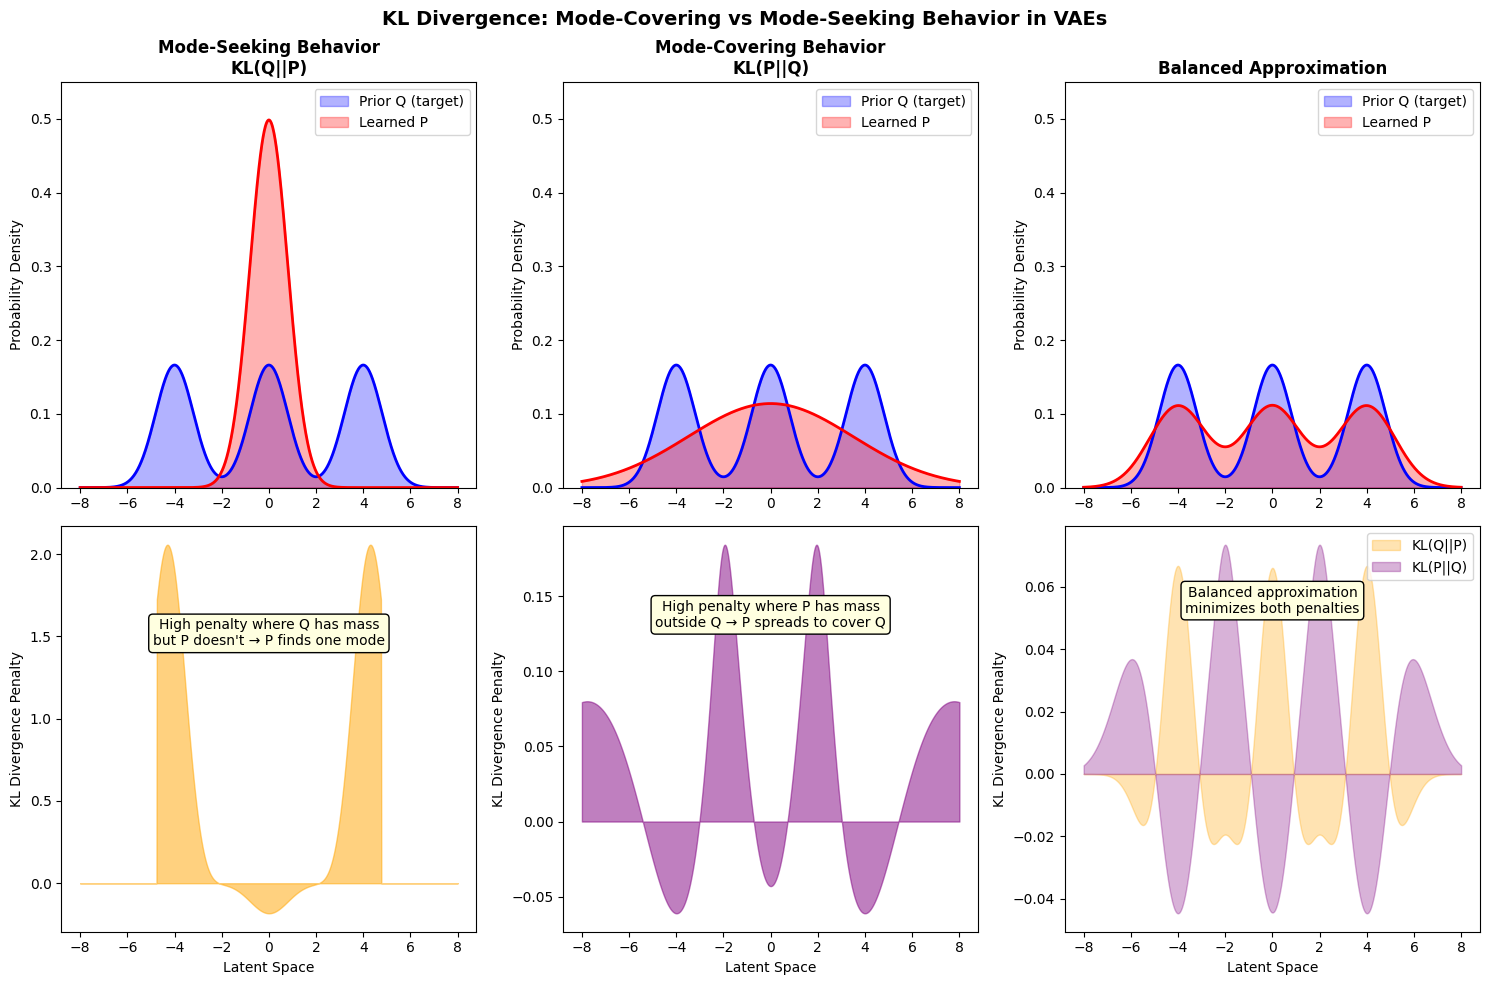

: 

In [ ]:
from scipy import stats
import matplotlib.patches as mpatches

def visualize_kl_divergence_behavior():
    """
    Visualize the difference between mode-covering (KL(P||Q)) 
    and mode-seeking (KL(Q||P)) behavior.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Define mixture of Gaussians as our true distribution Q
    x = np.linspace(-8, 8, 1000)
    
    # Q: Mixture of three Gaussians (our prior)
    q1 = stats.norm.pdf(x, -4, 0.8)
    q2 = stats.norm.pdf(x, 0, 0.8)
    q3 = stats.norm.pdf(x, 4, 0.8)
    q = (q1 + q2 + q3) / 3
    
    # Three different learned distributions P
    # Case 1: Mode-seeking (focuses on one mode)
    p_mode_seeking = stats.norm.pdf(x, 0, 0.8)
    
    # Case 2: Mode-covering (tries to cover all modes)
    p_mode_covering = stats.norm.pdf(x, 0, 3.5)
    
    # Case 3: Balanced (good approximation)
    p_balanced = (stats.norm.pdf(x, -4, 1.2) + 
                  stats.norm.pdf(x, 0, 1.2) + 
                  stats.norm.pdf(x, 4, 1.2)) / 3
    
    scenarios = [
        ("Mode-Seeking Behavior\nKL(Q||P)", p_mode_seeking, "Captures one mode precisely"),
        ("Mode-Covering Behavior\nKL(P||Q)", p_mode_covering, "Covers all modes but diffuse"),
        ("Balanced Approximation", p_balanced, "Good overall approximation")
    ]
    
    for i, (title, p, description) in enumerate(scenarios):
        # Top row: Show distributions
        ax_top = axes[0, i]
        ax_top.fill_between(x, q, alpha=0.3, color='blue', label='Prior Q (target)')
        ax_top.fill_between(x, p, alpha=0.3, color='red', label='Learned P')
        ax_top.plot(x, q, 'b-', linewidth=2)
        ax_top.plot(x, p, 'r-', linewidth=2)
        ax_top.set_title(title, fontsize=12, fontweight='bold')
        ax_top.set_ylim(0, 0.55)
        ax_top.legend()
        ax_top.set_ylabel('Probability Density')
        
        # Bottom row: Show penalty regions
        ax_bottom = axes[1, i]
        
        if "Mode-Seeking" in title:
            # KL(Q||P) heavily penalizes where Q > 0 but P ≈ 0
            penalty = np.where(p > 1e-8, q * np.log(q / p + 1e-8), 0)
            ax_bottom.fill_between(x, penalty, alpha=0.5, color='orange')
            ax_bottom.set_ylabel('KL Divergence Penalty')
            explanation = "High penalty where Q has mass\nbut P doesn't → P finds one mode"
        elif "Mode-Covering" in title:
            # KL(P||Q) heavily penalizes where P > 0 but Q ≈ 0
            penalty = np.where(q > 1e-8, p * np.log(p / q + 1e-8), 0)
            ax_bottom.fill_between(x, penalty, alpha=0.5, color='purple')
            ax_bottom.set_ylabel('KL Divergence Penalty')
            explanation = "High penalty where P has mass\noutside Q → P spreads to cover Q"
        else:
            # Show both for comparison
            penalty1 = np.where(p > 1e-8, q * np.log(q / p + 1e-8), 0)
            penalty2 = np.where(q > 1e-8, p * np.log(p / q + 1e-8), 0)
            ax_bottom.fill_between(x, penalty1, alpha=0.3, color='orange', label='KL(Q||P)')
            ax_bottom.fill_between(x, penalty2, alpha=0.3, color='purple', label='KL(P||Q)')
            ax_bottom.legend()
            ax_bottom.set_ylabel('KL Divergence Penalty')
            explanation = "Balanced approximation\nminimizes both penalties"
        
        ax_bottom.set_xlabel('Latent Space')
        ax_bottom.text(0, ax_bottom.get_ylim()[1]*0.7, explanation, 
                      ha='center', va='center', fontsize=10, 
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
    
    plt.suptitle("KL Divergence: Mode-Covering vs Mode-Seeking Behavior in VAEs", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Call the visualization
visualize_kl_divergence_behavior()